<a href="https://colab.research.google.com/github/catalinakarinip/mercadolabroal/blob/main/mercadolaboral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Script 1: Limpieza bases INE

Para actualizar las bases limpias se debe
1. Subir las bbdd originales del INE
2. Ver si la base de diccionario "variables_por_base" mantiene las columnas, y por tanto las abreviaturas corresponden
3. Cambiar nombre del archivo al compatible con la base de diccionario

El code se demora 1 min en crear todas las bases limpias!!


In [1]:
# ================= 0. MONTAR DRIVE =====================================
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ================= 1. LIBRERÍAS Y RUTA ========================================
from pathlib import Path
import pandas as pd
import re

ROOT = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio")
ORIG_DIR = ROOT / "Datos_ENE_originales"
CLEAN_DIR = ROOT / "Datos_ENE_limpios"
CLEAN_DIR.mkdir(parents=True, exist_ok=True)

MAP_FILE = ROOT / "resultados/variables_por_base.xlsx"
MAP_SHEET = 0

# ================= 2. DICCIONARIO DE ABREVIATURAS =====================
def load_abbreviations() -> dict:
    df_map = (
        pd.read_excel(MAP_FILE, sheet_name=MAP_SHEET, usecols="A:C")
        .rename(columns=str.lower)
        .dropna()
    )
    df_map["base"] = (
        df_map["base"].str.strip().str.replace(".xlsx", "", regex=False).str.lower()
    )
    df_map["var_original"] = df_map["var_original"].str.strip()
    df_map["abreviatura"] = df_map["abreviatura"].str.strip()
    return {(r.base, r.var_original): r.abreviatura for r in df_map.itertuples()}

# ================= 4. HOJAS A CONSERVAR ================================
ID_VARS = ["Año", "Trimestre"]
HOJAS_OBJETIVO = {
    "AS",
    "AP",
    "TA",
    "AN",
    "AT",
    "CO",
    "VA",
    "RM",
    "LI",
    "ML",
    "NB",
    "BI",
    "AR",
    "LR",
    "LL",
    "AI",
    "MA",
}

# ================= 5. CONVERSIÓN NÚMEROS CORREGIDA =======================

def texto_a_numero(valor: str):
    """Convierte correctamente comas decimales a float."""
    if pd.isna(valor):
        return None

    texto = str(valor).strip()

    # Si es un guión, vacío, o 'b', retornar None
    if not texto or texto in ['-', 'b']:
        return None

    # Solo cambiar coma por punto para decimales
    # 898,82 → 898.82 (NO 898820)
    texto_convertido = texto.replace(',', '.')

    try:
        return float(texto_convertido)
    except ValueError:
        return None

# ================= 6. LIMPIADOR DE HOJAS ===============================
def limpiar_hoja(df: pd.DataFrame, base_alias: str, abbr: dict) -> pd.DataFrame:
    df = df.copy()
    df.columns = df.columns.str.strip()
    columnas_a_borrar = []
    renombres = {}
    columnas = list(df.columns)

    for i, col in enumerate(columnas):
        if col in ID_VARS or "Unnamed" not in col:
            continue
        anterior = columnas[i - 1].strip() if i > 0 else ""
        if anterior in ID_VARS or not anterior:
            columnas_a_borrar.append(col)
            continue
        alias = abbr.get((base_alias, anterior))
        if alias:
            renombres[col] = f"{alias}_{base_alias}"
        else:
            columnas_a_borrar.append(col)

    df = df.drop(columns=columnas_a_borrar, errors="ignore").rename(columns=renombres)
    df = df[df[ID_VARS[0]].notna() | df[ID_VARS[1]].notna()].reset_index(drop=True)

    # Normalize quarter names so they match TRIM_OK in unify_panel.py
    quarter_map = {
        "1": "Ene - Mar",
        "2": "Abr - Jun",
        "3": "Jul - Sep",
        "4": "Oct - Dic",
        "ene-mar": "Ene - Mar",
        "abr-jun": "Abr - Jun",
        "jul-sep": "Jul - Sep",
        "oct-dic": "Oct - Dic",
        "ene - mar": "Ene - Mar",
        "abr - jun": "Abr - Jun",
        "jul - sep": "Jul - Sep",
        "oct - dic": "Oct - Dic",
    }
    df["Trimestre"] = (
        df["Trimestre"].astype(str).str.strip().str.lower().replace(quarter_map)
    )
    df["Año"] = pd.to_numeric(df["Año"], errors="coerce")

    for col in renombres.values():
        df[col] = df[col].apply(texto_a_numero)

    return df[[*ID_VARS, *renombres.values()]]

# ================= 7. PROCESAR ARCHIVOS =================================
def procesar_archivos():
    abbr = load_abbreviations()
    for src in ORIG_DIR.glob("*.xlsx"):
        base_alias = src.stem.split("_")[0].lower()
        dest = CLEAN_DIR / f"{base_alias}_limpia.xlsx"
        if dest.exists():
            print(f"↻  Reemplazando {dest.name}")
        else:
            print(f"→ Procesando {src.name} (base={base_alias})")
        xls = pd.ExcelFile(src)
        with pd.ExcelWriter(dest, engine="openpyxl") as xlw:
            hojas_guardadas = 0
            for hoja in xls.sheet_names:
                if hoja not in HOJAS_OBJETIVO:
                    continue
                try:
                    # CAMBIO: usar header=6 en lugar de header=5
                    raw = xls.parse(hoja, header=5, dtype=str)
                    limpio = limpiar_hoja(raw, base_alias, abbr)
                    if not limpio.empty:
                        limpio.to_excel(xlw, sheet_name=hoja, index=False)
                        hojas_guardadas += 1
                except Exception as e:
                    print(f"⚠️ Error en hoja '{hoja}': {e}")
            if hojas_guardadas == 0:
                print(f"⚠️ Ninguna hoja válida guardada en {src.name}")
    print("\n✅ Limpieza completada. Archivos en:", CLEAN_DIR)

if __name__ == "__main__":
    procesar_archivos()

↻  Reemplazando indicadoresprincipales_limpia.xlsx
↻  Reemplazando rama_limpia.xlsx
↻  Reemplazando informalidadtasas_limpia.xlsx
↻  Reemplazando informalidadrama_limpia.xlsx
↻  Reemplazando informalidadgrupo_limpia.xlsx
↻  Reemplazando informalidadcategoria_limpia.xlsx
↻  Reemplazando grupo_limpia.xlsx
↻  Reemplazando complementarios_limpia.xlsx
↻  Reemplazando categoria_limpia.xlsx

✅ Limpieza completada. Archivos en: /content/drive/MyDrive/Data/Mercado_Laboral/Biobio/Datos_ENE_limpios


# Script 2.1: Panel de datos

In [ ]:
# ================= 0. MONTAR DRIVE =====================================
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ================= 1. LIBRERÍAS Y PATH ========================================
from pathlib import Path
import pandas as pd
ROOT = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio")
CLEAN_DIR = ROOT / "Datos_ENE_limpios"
PANEL_FILE = ROOT / "resultados" / "panel_ENE_unificado.xlsx"

TRIM_OK = {"Ene - Mar", "Abr - Jun", "Jul - Sep", "Oct - Dic"}
MAPA = {
    "AP": "Arica y Parinacota",
    "TA": "Tarapacá",
    "AN": "Antofagasta",
    "AT": "Atacama",
    "CO": "Coquimbo",
    "VA": "Valparaíso",
    "RM": "Región Metropolitana",
    "LI": "O’Higgins",
    "ML": "Maule",
    "NB": "Ñuble",
    "BI": "Biobío",
    "AR": "Araucanía",
    "LR": "Los Ríos",
    "LL": "Los Lagos",
    "AI": "Aysén",
    "MA": "Magallanes",
    "AS": "Nacional",
}
REGIONES = set(MAPA.keys())
ID_VARS = ["Año", "Trimestre", "region_code", "region_name"]
TRIM_MAP = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}

# ================= 2.MAPEO INICIAL ===========================

def cargar_base(path: Path) -> pd.DataFrame:
    xls = pd.ExcelFile(path)
    registros = []
    for hoja in xls.sheet_names:
        if hoja not in REGIONES:
            continue
        df = pd.read_excel(xls, sheet_name=hoja)
        df = df[df["Trimestre"].isin(TRIM_OK)].copy()
        df["region_code"] = hoja
        df["region_name"] = MAPA[hoja]
        registros.append(df)
    if registros:
        return pd.concat(registros, ignore_index=True)
    return pd.DataFrame(columns=ID_VARS)


# ================= 3. CONSTRUCCIÓN DEL PANEL ===========================
def construir_panel():
    panel = None
    for archivo in CLEAN_DIR.glob("*_limpia.xlsx"):
        df_base = cargar_base(archivo)
        if df_base.empty:
            continue
        if panel is None:
            panel = df_base
        else:
            panel = pd.merge(panel, df_base, on=ID_VARS, how="outer")
    if panel is None:
        print("No se encontraron archivos limpios")
        return
    panel["Trimestre_num"] = panel["Trimestre"].map(TRIM_MAP)
    panel = (
        panel.sort_values(
            ["Año", "Trimestre_num", "region_code", "region_name"]
        )
        .drop(columns="Trimestre_num")
        .reset_index(drop=True)
    )
    panel["Periodo"] = pd.PeriodIndex(
        year=panel["Año"],
        quarter=panel["Trimestre"].map(TRIM_MAP),
        freq="Q",
    )
    panel["Fecha"] = panel["Periodo"].dt.start_time
    #panel["Periodo_str"] = panel["Periodo"].astype(str)

    PANEL_FILE.parent.mkdir(parents=True, exist_ok=True)
    if PANEL_FILE.exists():
        print(f"↻  Reemplazando {PANEL_FILE.name}")
    panel.to_excel(PANEL_FILE, index=False, sheet_name="panel_data")
    print("✅ Panel construido y guardado en:", PANEL_FILE)

if __name__ == "__main__":
    construir_panel()

<ipython-input-24-1241934044>:72: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  panel["Periodo"] = pd.PeriodIndex(


↻  Reemplazando panel_ENE_unificado.xlsx
✅ Panel construido y guardado en: /content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx


# Script 2.2: Panel BioBio vs Nacional

In [ ]:
# ================= Panel Biobío vs Nacional =====================
import pandas as pd
from pathlib import Path

# === Paths y variables ===
ROOT = Path('/content/drive/MyDrive/Data/Mercado_Laboral/Biobio')
PANEL_FILE = ROOT / 'resultados' / 'panel_ENE_unificado.xlsx'

vars_sel = [
    'T_TDO_indicadoresprincipales',
    'T_TO_indicadoresprincipales',
    'T_TP_indicadoresprincipales',
    'T_TOI_A_informalidadtasas',
    'T_TOI_H_informalidadtasas',
    'T_TOI_M_informalidadtasas',
]

TRIM_MAP = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}

# === Cargar y filtrar ===
df = pd.read_excel(PANEL_FILE, sheet_name='panel_data')
df = df[df['region_name'].isin(['Biobío', 'Nacional'])].copy()

# Añadir orden temporal
df["Trimestre_num"] = df["Trimestre"].map(TRIM_MAP)
df = df.sort_values(["Año", "Trimestre_num", "region_name"])

# Seleccionar columnas en orden
cols_final = ['Año', 'Trimestre', 'region_name'] + vars_sel
df_panel = df[cols_final]

# Guardar como nueva hoja
with pd.ExcelWriter(PANEL_FILE, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    df_panel.to_excel(writer, sheet_name='biobio_vs_nacional', index=False)

print(f"✅ Hoja «biobio_vs_nacional» creada con {len(df_panel)} filas.")


✅ Hoja «biobio_vs_nacional» creada con 122 filas.


In [ ]:
# ================= Panel Biobío vs Nacional =====================
import pandas as pd
from pathlib import Path

# === Paths y variables ===
ROOT = Path('/content/drive/MyDrive/Data/Mercado_Laboral/Biobio')
PANEL_FILE = ROOT / 'resultados' / 'panel_ENE_unificado.xlsx'

vars_sel = [
    'T_TDO_indicadoresprincipales',
    'T_TO_indicadoresprincipales',
    'T_TP_indicadoresprincipales',
    'T_TOI_A_informalidadtasas',
    'T_TOI_H_informalidadtasas',
    'T_TOI_M_informalidadtasas',
]

TRIM_MAP = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}

# === Cargar y filtrar ===
df = pd.read_excel(PANEL_FILE, sheet_name='panel_data')
df = df[df['region_name'].isin(['Biobío', 'Nacional'])].copy()

# Añadir periodo y fecha
df["Trimestre_num"] = df["Trimestre"].map(TRIM_MAP)
df["Periodo"] = pd.PeriodIndex.from_fields(
    year=df["Año"],
    quarter=df["Trimestre_num"],
    freq="Q"
)
df["Fecha"] = df["Periodo"].dt.start_time

# Ordenar y seleccionar columnas finales
df = df.sort_values(["Periodo", "region_name"])
cols_final = ['Periodo', 'Fecha', 'Año', 'Trimestre', 'region_name'] + vars_sel
df_panel = df[cols_final]

# Guardar como nueva hoja
with pd.ExcelWriter(PANEL_FILE, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    df_panel.to_excel(writer, sheet_name='biobio_vs_nacional', index=False)

print(f"✅ Hoja «biobio_vs_nacional» creada con {len(df_panel)} filas.")


✅ Hoja «biobio_vs_nacional» creada con 122 filas.


# Script 3: BBDD anual 2024

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# 1️⃣  Parámetros
archivo_excel = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
hoja_origen   = "panel_data"
anio          = 2024
hoja_filtrada = f"data_{anio}"
hoja_prom     = f"promedios_{anio}"

TRIM_MAP = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}

# 2️⃣  Leer la hoja principal y filtrar solo el año objetivo
df_anio = (
    pd.read_excel(archivo_excel, sheet_name="panel_data")
      .query("Año == @anio")
)

df_anio = pd.read_excel(archivo_excel, sheet_name=hoja_origen).query("Año == @anio").copy()

if "Periodo" not in df_anio.columns:
    df_anio["Trimestre_num"] = df_anio["Trimestre"].map(TRIM_MAP)
    df_anio["Periodo"] = pd.PeriodIndex.from_fields(df_anio["Año"], df_anio["Trimestre_num"], freq="Q")
    df_anio["Fecha"] = df_anio["Periodo"].dt.start_time
    df_anio.drop(columns="Trimestre_num", inplace=True)


# 3️⃣  Calcular promedios regionales
indicadores = [
    "T_TDO_indicadoresprincipales",
    "T_TO_indicadoresprincipales",
    "T_TP_indicadoresprincipales",
    "T_TOI_A_informalidadtasas",
    "T_TOI_H_informalidadtasas",
    "T_TOI_M_informalidadtasas",
]

promedios = (
    df_anio.groupby("region_name")[indicadores]
           .mean()
           .reset_index()
           .round(3)
)

# 4️⃣  Escribir ambas hojas dentro del mismo archivo
with pd.ExcelWriter(
        archivo_excel,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    df_anio.to_excel(writer, sheet_name=hoja_filtrada, index=False)
    promedios.to_excel(writer, sheet_name=hoja_prom, index=False)

print(f"✅ Hoja «{hoja_filtrada}» ({len(df_anio)} filas) y «{hoja_prom}» ({len(promedios)} regiones) creadas/actualizadas.")

✅ Hoja «data_2024» (68 filas) y «promedios_2024» (17 regiones) creadas/actualizadas.


# Script 4: BBDD anual 2025

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# 1️⃣  Parámetros
archivo_excel = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
hoja_origen   = "panel_data"
anio          = 2025
hoja_filtrada = f"data_{anio}"
hoja_prom     = f"promedios_{anio}"

TRIM_MAP = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}

# 2️⃣  Leer la hoja principal y filtrar solo el año objetivo
df_anio = (
    pd.read_excel(archivo_excel, sheet_name="panel_data")
      .query("Año == @anio")
)
df_anio = pd.read_excel(archivo_excel, sheet_name=hoja_origen).query("Año == @anio").copy()

if "Periodo" not in df_anio.columns:
    df_anio["Trimestre_num"] = df_anio["Trimestre"].map(TRIM_MAP)
    df_anio["Periodo"] = pd.PeriodIndex.from_fields(df_anio["Año"], df_anio["Trimestre_num"], freq="Q")
    df_anio["Fecha"] = df_anio["Periodo"].dt.start_time
    df_anio.drop(columns="Trimestre_num", inplace=True)

# 3️⃣  Calcular promedios regionales
indicadores = [
    "T_TDO_indicadoresprincipales",
    "T_TO_indicadoresprincipales",
    "T_TP_indicadoresprincipales",
    "T_TOI_A_informalidadtasas",
    "T_TOI_H_informalidadtasas",
    "T_TOI_M_informalidadtasas",
]

promedios = (
    df_anio.groupby("region_name")[indicadores]
           .mean()
           .reset_index()
           .round(3)
)

# 4️⃣  Escribir ambas hojas dentro del mismo archivo
with pd.ExcelWriter(
        archivo_excel,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    df_anio.to_excel(writer, sheet_name=hoja_filtrada, index=False)
    promedios.to_excel(writer, sheet_name=hoja_prom, index=False)

print(f"✅ Hoja «{hoja_filtrada}» ({len(df_anio)} filas) y «{hoja_prom}» ({len(promedios)} regiones) creadas/actualizadas.")

✅ Hoja «data_2025» (17 filas) y «promedios_2025» (17 regiones) creadas/actualizadas.


# Funciones

In [ ]:
# ========== CALCULAR VARIACIONES INTERANUALES ==========

from pathlib import Path
import pandas as pd

TRIM_MAP = {
    "Ene - Mar": 1,
    "Abr - Jun": 2,
    "Jul - Sep": 3,
    "Oct - Dic": 4,
}

# === Función para cargar y crear columna Periodo si no existe ===
def load_panel_variaciones(path: Path, sheet: str) -> pd.DataFrame:
    df = pd.read_excel(path, sheet_name=sheet)
    if "Periodo" not in df.columns:
        df["Trimestre_num"] = df["Trimestre"].map(TRIM_MAP)
        df["Periodo"] = pd.PeriodIndex(
            year=df["Año"],
            quarter=df["Trimestre_num"],
            freq="Q"
        )
    return df

# === Calcular variaciones ===
def add_variations(df: pd.DataFrame, variables: list[str]) -> pd.DataFrame:
    df = df.sort_values(["region_name", "Periodo"]).copy()
    for var in variables:
        # Variación interanual: diferencia con el mismo trimestre del año anterior
        df[f"{var}_da"] = df.groupby("region_name")[var].diff(periods=4)
    return df


    return df

# === Ruta y columnas a calcular ===
PANEL_FILE = Path('/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx')
SHEET_IN = "biobio_vs_nacional"
SHEET_OUT = "biobio_vs_nacional_variaciones"

# Cargar panel
df = load_panel_variaciones(PANEL_FILE, SHEET_IN)

# Seleccionar solo las columnas numéricas de interés (excluyendo Año, Fecha, etc.)
cols_num = df.select_dtypes("number").columns.difference(["Año", "Trimestre_num"])
df_var = add_variations(df, cols_num)

# Guardar como nueva hoja
with pd.ExcelWriter(PANEL_FILE, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    df_var.to_excel(writer, sheet_name=SHEET_OUT, index=False)

print(f"✅ Hoja «{SHEET_OUT}» creada con variaciones.")


✅ Hoja «biobio_vs_nacional_variaciones» creada con variaciones.


# Tablas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Tablas excel

In [ ]:
import pandas as pd
from openpyxl import load_workbook

# ─── 1. Cargar datos ──────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")

# ─── 2. Filtrar datos Biobío ──────────────────────────────────────────────────
df_bio = df[df["region_name"] == "Biobío"].copy()
orden_trimestres = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}
df_bio["orden"] = df_bio["Trimestre"].map(orden_trimestres)
df_bio = df_bio.sort_values(["Año", "orden"]).drop(columns="orden")

# ─── 3. Renombrar columnas ────────────────────────────────────────────────────
column_map = {
    "PET_indicadoresprincipales": "Población en edad de trabajar",
    "FT_TOT_indicadoresprincipales": "Fuerza de trabajo",
    "PO_TOT_indicadoresprincipales": "Personas ocupadas",
    "PDO_TOT_indicadoresprincipales": "Personas desocupadas",
    "PO_F_TOT_informalidadrama": "Personas ocupadas formales",
    "PO_I_TOT_informalidadrama": "Personas ocupadas informales",
    "FFT_TOT_indicadoresprincipales": "Fuera de la fuerza de trabajo"
}

df_bio = df_bio.rename(columns=column_map)
df_bio = df_bio.round(2)

# ─── 4. Promedio anual ────────────────────────────────────────────────────────
variables = list(column_map.values())
df_promedio_anual = df_bio[["Año"] + variables].groupby("Año").mean(numeric_only=True).reset_index()
df_promedio_anual = df_promedio_anual.round(2)

# ─── 5. Calcular crecimiento interanual ───────────────────────────────────────
df_crecimiento_anual = df_promedio_anual.copy()
for var in variables:
    df_crecimiento_anual[f"% Δ {var}"] = df_crecimiento_anual[var].pct_change().round(4) * 100

# ─── 6. Tabla trimestral con columnas seleccionadas ───────────────────────────
df_trimestral = df_bio[["Año", "Trimestre"] + variables].copy()


# ─── 6. Calcular crecimiento interanual por trimestre móvil ───────────────────
for var in variables:
    df_trimestral[f"% Δ {var}"] = (
        df_trimestral
        .groupby("Trimestre")[var]
        .pct_change(periods=1) * 100
    ).round(2)


# ─── 7. Crecimiento acumulado Ene–Mar 2018 vs 2025 ───────────────────────────
df_marzo = df_trimestral[df_trimestral["Trimestre"] == "Ene - Mar"]
df_2018 = df_marzo[df_marzo["Año"] == 2018].set_index("Año")
df_2025 = df_marzo[df_marzo["Año"] == 2025].set_index("Año")

if not df_2018.empty and not df_2025.empty:
    crecimiento = ((df_2025[variables].values[0] / df_2018[variables].values[0]) - 1) * 100
    df_crecimiento_total = pd.DataFrame({
        "Variable": variables,
        "Crecimiento acumulado (%) 2018–2025": crecimiento.round(2)
    })
else:
    df_crecimiento_total = pd.DataFrame(columns=["Variable", "Crecimiento acumulado (%) 2018–2025"])

# ─── 8. Exportar todas a un solo archivo Excel ────────────────────────────────
with pd.ExcelWriter(ruta, mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
    df_trimestral.to_excel(writer, sheet_name="biobio_trimestres", index=False)
    df_crecimiento_anual.to_excel(writer, sheet_name="biobio_promedio_anual", index=False)
    df_crecimiento_total.to_excel(writer, sheet_name="crecimiento_2018_2025", index=False)

print("✅ Exportación completada.")


/tmp/ipython-input-2-421002387.py:47: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change(periods=1) * 100
/tmp/ipython-input-2-421002387.py:47: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change(periods=1) * 100


✅ Exportación completada.


In [ ]:
import pandas as pd
from pathlib import Path
from openpyxl import load_workbook

# ─── 1. Definir ruta y leer datos ────────────────────────────────────────────
ruta = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
df = pd.read_excel(ruta, sheet_name="panel_data")

# ─── 2. Variables de conteo y sus nombres para el informe ───────────────────
count_vars = [
    "PET_indicadoresprincipales",      # Población en edad de trabajar
    "FT_TOT_indicadoresprincipales",   # Fuerza de trabajo
    "PO_TOT_indicadoresprincipales",   # Personas ocupadas
    "PDO_TOT_indicadoresprincipales",  # Personas desocupadas
    "PO_F_TOT_informalidadrama",       # Ocupadas formales
    "PO_I_TOT_informalidadrama",       # Ocupadas informales
    "FFT_TOT_indicadoresprincipales"   # Fuera de la fuerza de trabajo
]
friendly = {
    "PET_indicadoresprincipales": "Población en edad de trabajar",
    "FT_TOT_indicadoresprincipales": "Fuerza de trabajo",
    "PO_TOT_indicadoresprincipales": "Personas ocupadas",
    "PDO_TOT_indicadoresprincipales": "Personas desocupadas",
    "PO_F_TOT_informalidadrama": "Ocupadas formales",
    "PO_I_TOT_informalidadrama": "Ocupadas informales",
    "FFT_TOT_indicadoresprincipales": "Fuera de la fuerza de trabajo"
}

# ─── 3. Filtrar solo Q1 2018 y Q1 2025, incluyendo "Nacional" ──────────────
periodos = ["2018Q1", "2025Q1"]
df2 = df[df["Periodo"].isin(periodos)].copy()

# ─── 4. Normalizar nombres de región (quitar comillas) ──────────────────────
def clean(s):
    return s.replace("'", "").replace("’", "").replace("‘", "").replace("`", "").strip() \
           if isinstance(s, str) else s

df2["region_name"] = df2["region_name"].apply(clean)

# ─── 5. Agrupar por región y periodo sumando los conteos ────────────────────
df_tot = (
    df2
    .groupby(["region_name", "Periodo"])[count_vars]
    .sum()
    .reset_index()
)

# ─── 6. Pivot para tener columnas para cada periodo ─────────────────────────
df_piv = df_tot.pivot(index="region_name", columns="Periodo", values=count_vars)

# ─── 7. Calcular crecimiento porcentual 2018Q1→2025Q1 ───────────────────────
rows = []
for region, row in df_piv.iterrows():
    rec = {"Región": region}
    for var in count_vars:
        inicial = row[(var, "2018Q1")]
        final   = row[(var, "2025Q1")]
        if pd.notna(inicial) and inicial != 0:
            valor = ((final - inicial) / inicial) * 100
            rec[f"Crecimiento 2018–2025 ({friendly[var]})"] = round(valor, 2)
        else:
            rec[f"Crecimiento 2018–2025 ({friendly[var]})"] = pd.NA
    rows.append(rec)

df_growth = pd.DataFrame(rows)

# ─── 8. Exportar a nueva hoja Excel ──────────────────────────────────────────
with pd.ExcelWriter(ruta, mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
    df_growth.to_excel(
        writer,
        sheet_name="crec_personas_regiones_2018_2025",
        index=False
    )

print("✅ Hoja 'crec_personas_regiones_2018_2025' creada con éxito.")


/usr/local/lib/python3.11/dist-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


✅ Hoja 'crec_personas_regiones_2018_2025' creada con éxito.


# Tablas imagenes


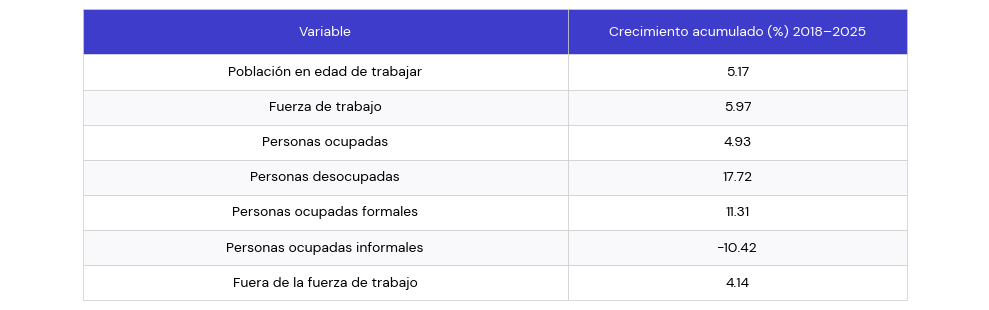

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path

# ─── 1. Configurar fuente DM Sans ─────────────────────────────────────────────
font_path = "/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf"
if Path(font_path).exists():
    fm.fontManager.addfont(font_path)
    dm_font = fm.FontProperties(fname=font_path)
else:
    dm_font = fm.FontProperties()

# ─── 2. Cargar tabla ──────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="crecimiento_2018_2025")

# ─── 3. Formatear porcentaje con símbolo y coma ───────────────────────────────
df["Crecimiento acumulado (%) 2018–2025"] = df[
    "Crecimiento acumulado (%) 2018–2025"
].map(lambda x: f"{x:,.2f}")

# ─── 4. Crear tabla como imagen con estilo ────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 3.2))  # Aumenta altura del canvas
ax.axis("off")

column_labels = df.columns.tolist()
cell_data = df.values.tolist()

tabla = ax.table(
    cellText=[column_labels] + cell_data,
    cellLoc='center',
    loc='center'
)

tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1.1, 2.1)  # También puedes ajustar aquí

# Estilo de celdas
for (row, col), cell in tabla.get_celld().items():
    if row == 0:
        cell.set_facecolor("#3E3CCA")
        cell.set_text_props(color='white', weight='bold', fontproperties=dm_font)
        cell.set_height(0.18)  # Encabezado más alto
    else:
        cell.set_facecolor("#f9f9fb" if row % 2 == 0 else "white")
        cell.set_text_props(fontproperties=dm_font)
        cell.set_height(0.14)  # Aumenta la altura de filas
    cell.set_edgecolor("#CCCCCC")
    cell.set_linewidth(0.5)
    cell.set_width(0.5 if col == 0 else 0.35)

plt.tight_layout()
#plt.savefig("/content/tabla_crecimiento_acumulado.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()


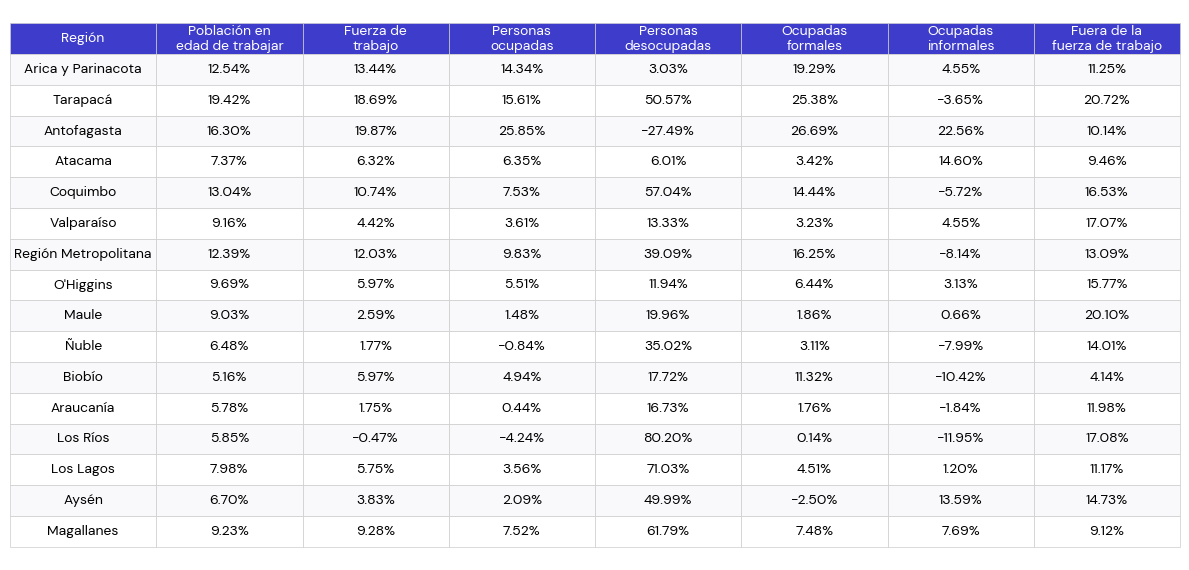

✅ Tabla ordenada (norte→sur) guardada en /content/tabla_crecimiento_norte_sur.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path

# ─── 1. Configurar fuente DM Sans ────────────────────────────────────────────
font_path = Path("/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf")
if font_path.exists():
    fm.fontManager.addfont(str(font_path))
    dm_font = fm.FontProperties(fname=str(font_path))
else:
    dm_font = fm.FontProperties()

# ─── 2. Cargar panel y filtrar Q1 2018 & Q1 2025 ─────────────────────────────
ruta = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
df = pd.read_excel(ruta, sheet_name="panel_data")
periodos = ["2018Q1","2025Q1"]
df2 = df[df["Periodo"].isin(periodos)].copy()
df2["region_name"] = (
    df2["region_name"].astype(str)
       .str.replace("’","'")
       .str.strip()
)

# ─── 3. Variables y etiquetas amigables ─────────────────────────────────────
count_vars = [
    "PET_indicadoresprincipales",
    "FT_TOT_indicadoresprincipales",
    "PO_TOT_indicadoresprincipales",
    "PDO_TOT_indicadoresprincipales",
    "PO_F_TOT_informalidadrama",
    "PO_I_TOT_informalidadrama",
    "FFT_TOT_indicadoresprincipales"
]
friendly = {
    "PET_indicadoresprincipales": "Población en\nedad de trabajar",
    "FT_TOT_indicadoresprincipales": "Fuerza de\ntrabajo",
    "PO_TOT_indicadoresprincipales": "Personas\nocupadas",
    "PDO_TOT_indicadoresprincipales": "Personas\ndesocupadas",
    "PO_F_TOT_informalidadrama": "Ocupadas\nformales",
    "PO_I_TOT_informalidadrama": "Ocupadas\ninformales",
    "FFT_TOT_indicadoresprincipales": "Fuera de la\nfuerza de trabajo"
}

# ─── 4. Pivot directo sin agregación ─────────────────────────────────────────
df_piv = (
    df2
    .set_index(["region_name","Periodo"])[count_vars]
    .unstack("Periodo")
)

# ─── 5. Calcular crecimiento % 2018→2025 ────────────────────────────────────
rows = []
for region, row in df_piv.iterrows():
    rec = {"Región": region}
    for var in count_vars:
        ini = row[(var, "2018Q1")]
        fin = row[(var, "2025Q1")]
        if pd.notna(ini) and ini != 0:
            pct = ((fin - ini) / ini) * 100
            rec[friendly[var]] = f"{pct:.2f}%"
        else:
            rec[friendly[var]] = ""
    rows.append(rec)

df_growth = pd.DataFrame(rows)

# ─── 6. Ordenar regiones de norte a sur ─────────────────────────────────────
orden_geo = [
    "Arica y Parinacota","Tarapacá","Antofagasta","Atacama",
    "Coquimbo","Valparaíso","Región Metropolitana","O'Higgins",
    "Maule","Ñuble","Biobío","Araucanía","Los Ríos",
    "Los Lagos","Aysén","Magallanes"
]

df_growth = df_growth.set_index("Región").reindex(orden_geo).reset_index()

# ─── 7. Dibujar tabla con matplotlib ────────────────────────────────────────
n_rows = len(df_growth)
fig, ax = plt.subplots(figsize=(12, 1 + 0.3 * n_rows))
ax.axis("off")

col_labels = ["Región"] + [friendly[v] for v in count_vars]
cell_data  = df_growth.values.tolist()

tabla = ax.table(
    cellText=[col_labels] + cell_data,
    cellLoc="center",
    loc="center"
)
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1, 1.5)

for (r, c), cell in tabla.get_celld().items():
    if r == 0:
        cell.set_facecolor("#3E3CCA")
        cell.set_text_props(color="white", weight="bold", fontproperties=dm_font)
    else:
        cell.set_facecolor("#f9f9fb" if r % 2 == 1 else "white")
        cell.set_text_props(fontproperties=dm_font)
    cell.set_edgecolor("#CCCCCC")
    cell.set_linewidth(0.5)

plt.tight_layout()
output_path = Path("/content/tabla_crecimiento_norte_sur.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

print(f"✅ Tabla ordenada (norte→sur) guardada en {output_path}")


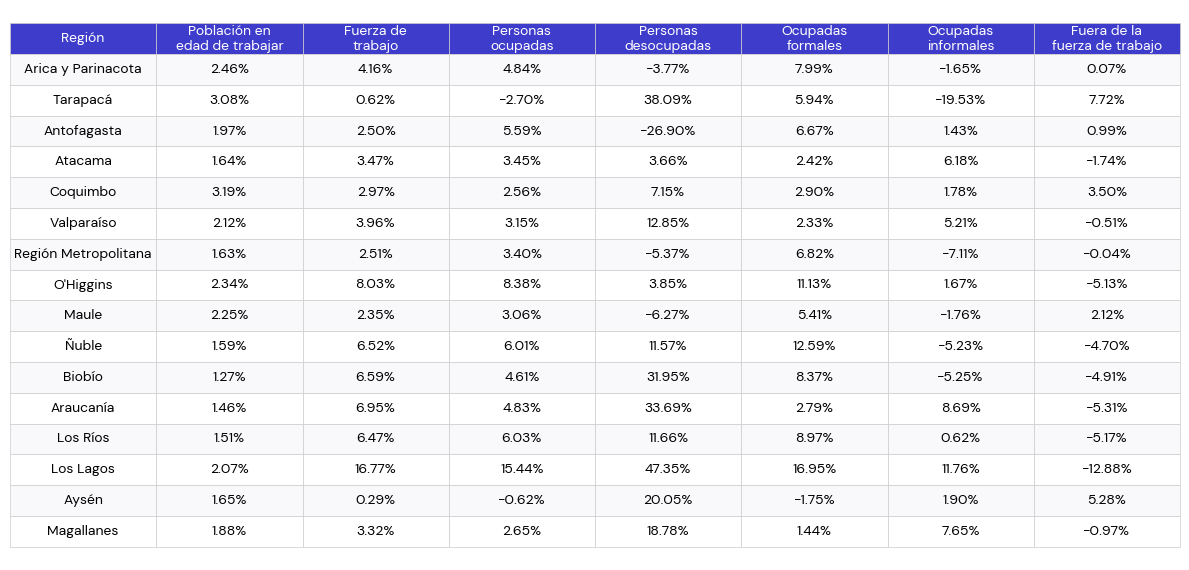

✅ Tabla ordenada (norte→sur) guardada en /content/tabla_crecimiento_norte_sur23.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path

# ─── 1. Configurar fuente DM Sans ────────────────────────────────────────────
font_path = Path("/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf")
if font_path.exists():
    fm.fontManager.addfont(str(font_path))
    dm_font = fm.FontProperties(fname=str(font_path))
else:
    dm_font = fm.FontProperties()

# ─── 2. Cargar panel y filtrar Q1 2018 & Q1 2025 ─────────────────────────────
ruta = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
df = pd.read_excel(ruta, sheet_name="panel_data")
periodos = ["2023Q1","2025Q1"]
df2 = df[df["Periodo"].isin(periodos)].copy()
df2["region_name"] = (
    df2["region_name"].astype(str)
       .str.replace("’","'")
       .str.strip()
)

# ─── 3. Variables y etiquetas amigables ─────────────────────────────────────
count_vars = [
    "PET_indicadoresprincipales",
    "FT_TOT_indicadoresprincipales",
    "PO_TOT_indicadoresprincipales",
    "PDO_TOT_indicadoresprincipales",
    "PO_F_TOT_informalidadrama",
    "PO_I_TOT_informalidadrama",
    "FFT_TOT_indicadoresprincipales"
]
friendly = {
    "PET_indicadoresprincipales": "Población en\nedad de trabajar",
    "FT_TOT_indicadoresprincipales": "Fuerza de\ntrabajo",
    "PO_TOT_indicadoresprincipales": "Personas\nocupadas",
    "PDO_TOT_indicadoresprincipales": "Personas\ndesocupadas",
    "PO_F_TOT_informalidadrama": "Ocupadas\nformales",
    "PO_I_TOT_informalidadrama": "Ocupadas\ninformales",
    "FFT_TOT_indicadoresprincipales": "Fuera de la\nfuerza de trabajo"
}

# ─── 4. Pivot directo sin agregación ─────────────────────────────────────────
df_piv = (
    df2
    .set_index(["region_name","Periodo"])[count_vars]
    .unstack("Periodo")
)

# ─── 5. Calcular crecimiento % 2018→2025 ────────────────────────────────────
rows = []
for region, row in df_piv.iterrows():
    rec = {"Región": region}
    for var in count_vars:
        ini = row[(var, "2023Q1")]
        fin = row[(var, "2025Q1")]
        if pd.notna(ini) and ini != 0:
            pct = ((fin - ini) / ini) * 100
            rec[friendly[var]] = f"{pct:.2f}%"
        else:
            rec[friendly[var]] = ""
    rows.append(rec)

df_growth = pd.DataFrame(rows)

# ─── 6. Ordenar regiones de norte a sur ─────────────────────────────────────
orden_geo = [
    "Arica y Parinacota","Tarapacá","Antofagasta","Atacama",
    "Coquimbo","Valparaíso","Región Metropolitana","O'Higgins",
    "Maule","Ñuble","Biobío","Araucanía","Los Ríos",
    "Los Lagos","Aysén","Magallanes"
]

df_growth = df_growth.set_index("Región").reindex(orden_geo).reset_index()

# ─── 7. Dibujar tabla con matplotlib ────────────────────────────────────────
n_rows = len(df_growth)
fig, ax = plt.subplots(figsize=(12, 1 + 0.3 * n_rows))
ax.axis("off")

col_labels = ["Región"] + [friendly[v] for v in count_vars]
cell_data  = df_growth.values.tolist()

tabla = ax.table(
    cellText=[col_labels] + cell_data,
    cellLoc="center",
    loc="center"
)
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1, 1.5)

for (r, c), cell in tabla.get_celld().items():
    if r == 0:
        cell.set_facecolor("#3E3CCA")
        cell.set_text_props(color="white", weight="bold", fontproperties=dm_font)
    else:
        cell.set_facecolor("#f9f9fb" if r % 2 == 1 else "white")
        cell.set_text_props(fontproperties=dm_font)
    cell.set_edgecolor("#CCCCCC")
    cell.set_linewidth(0.5)

plt.tight_layout()
output_path = Path("/content/tabla_crecimiento_norte_sur23.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

print(f"✅ Tabla ordenada (norte→sur) guardada en {output_path}")


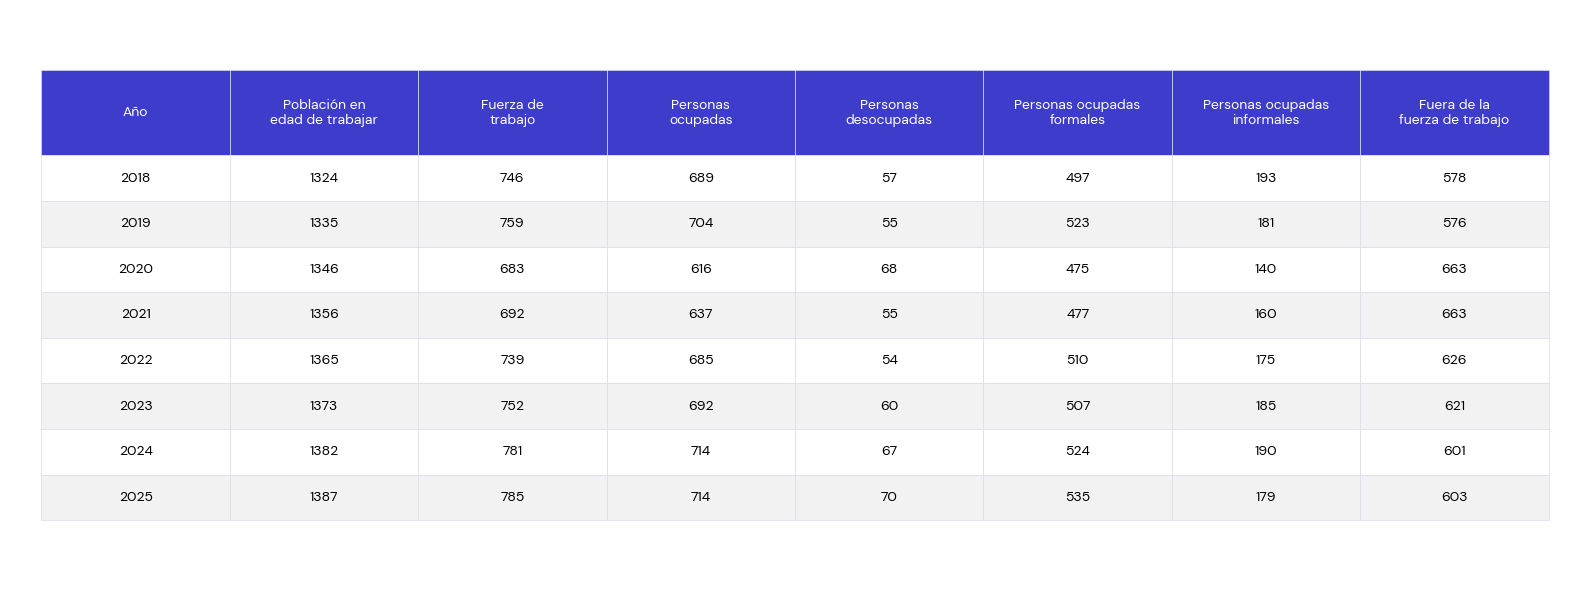

<ipython-input-34-568559369>:147: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


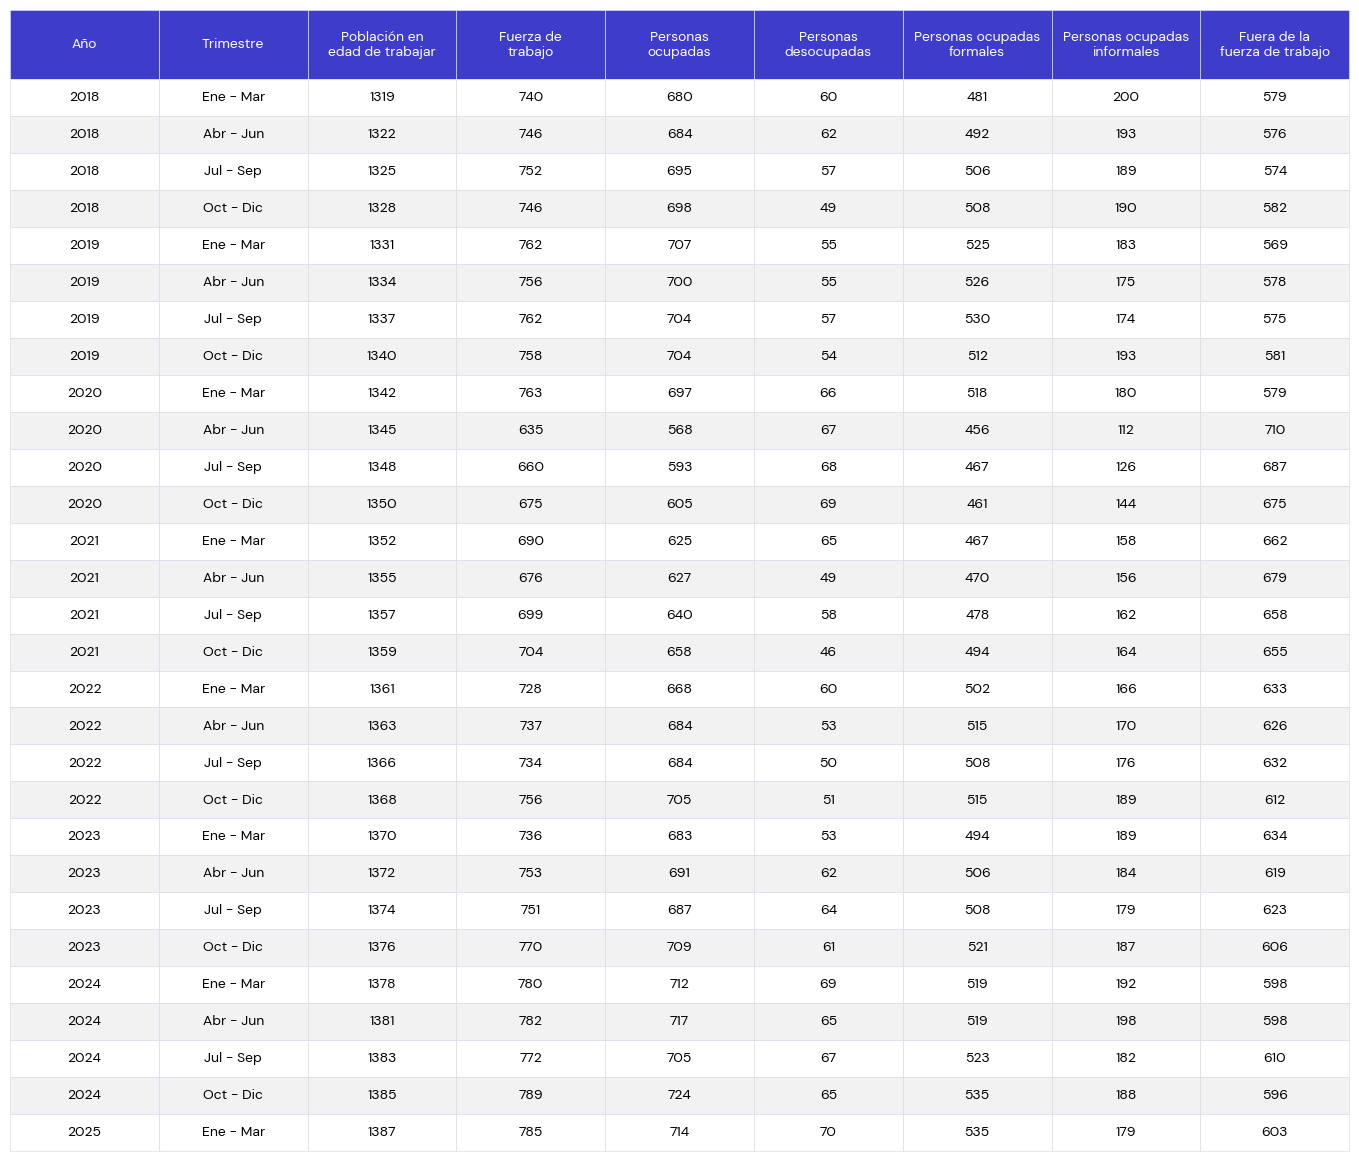

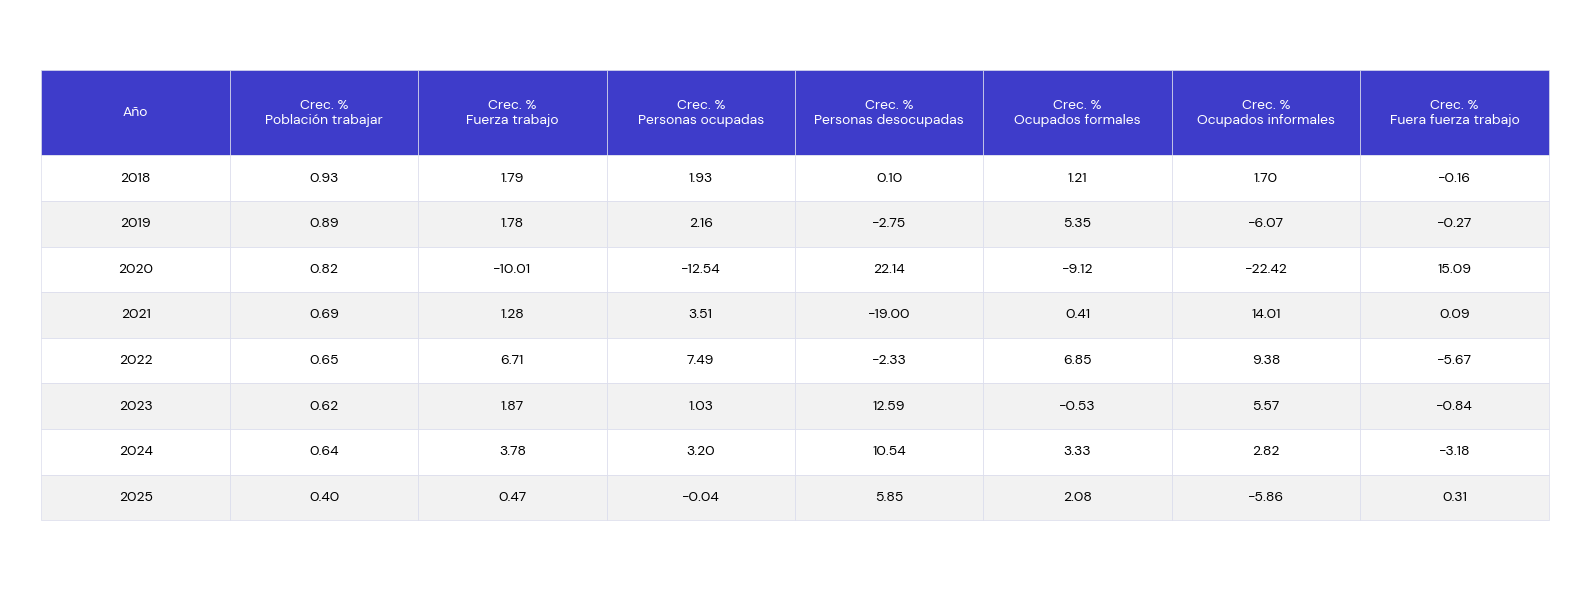

<ipython-input-34-568559369>:147: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


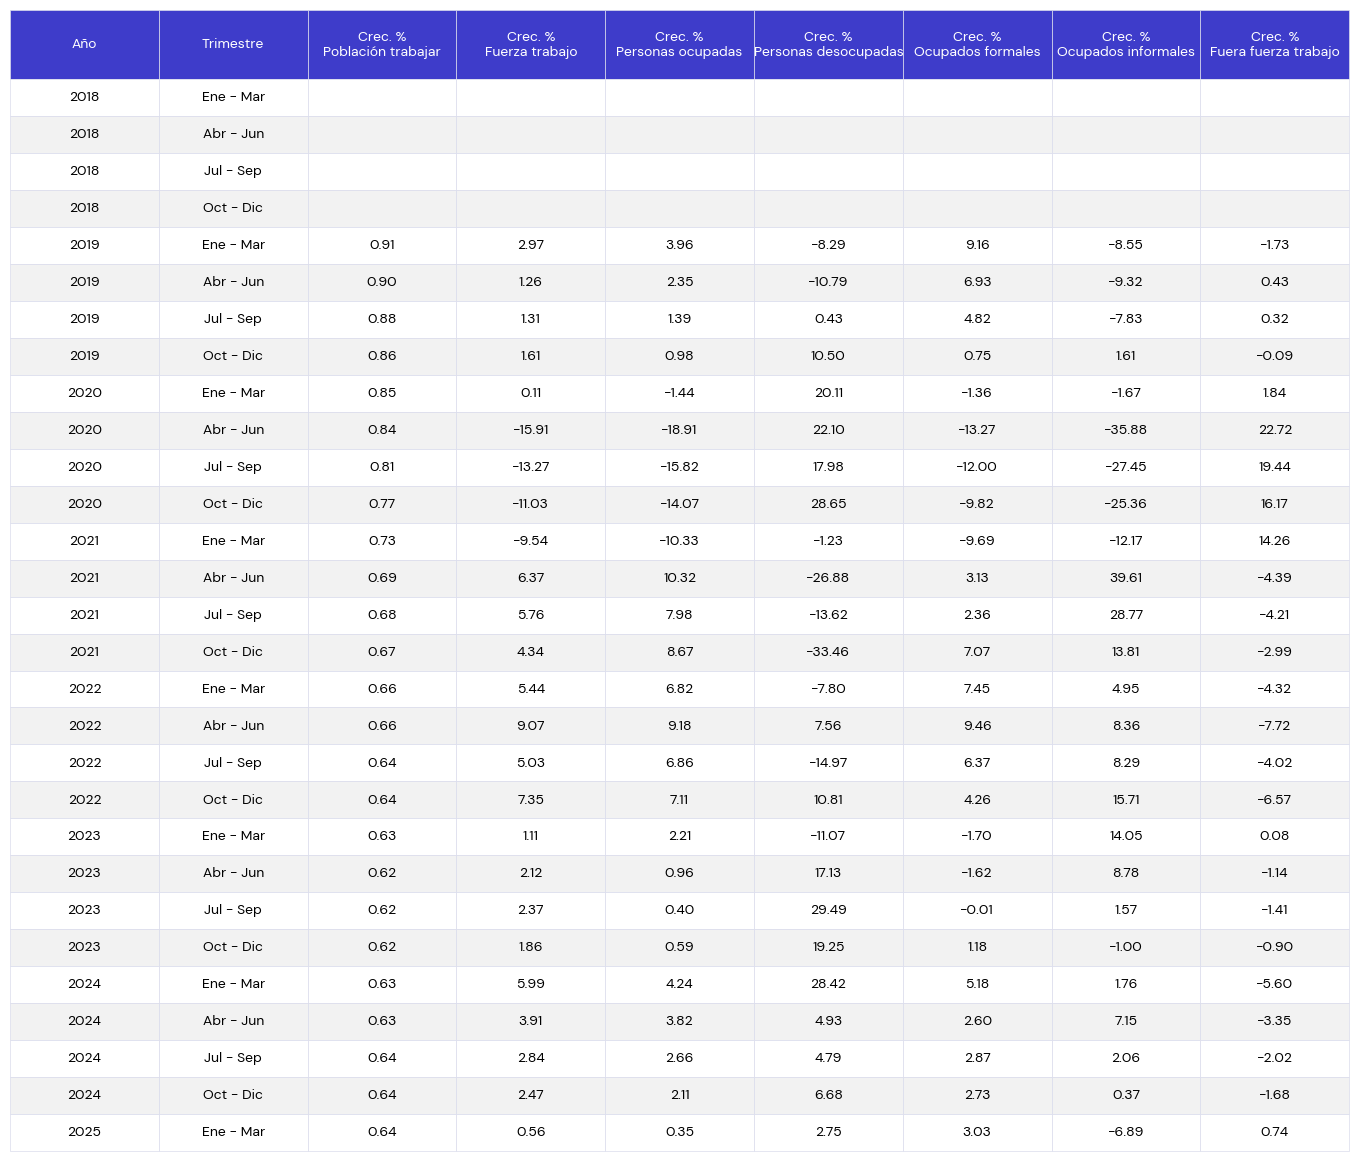

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path

# ─── 1. Fuente personalizada (opcional) ───────────────────────────────────────
font_path = "/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf"
if Path(font_path).exists():
    fm.fontManager.addfont(font_path)
    dm_font = fm.FontProperties(fname=font_path)
else:
    dm_font = fm.FontProperties()

# ─── 2. Cargar y preparar datos ───────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df_bio = df[df["region_name"] == "Biobío"].copy()

orden_trimestres = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}
df_bio["orden"] = df_bio["Trimestre"].map(orden_trimestres)
df_bio = df_bio.sort_values(["Año", "orden"]).drop(columns="orden")

column_map = {
    "PET_indicadoresprincipales": "Población en\nedad de trabajar",
    "FT_TOT_indicadoresprincipales": "Fuerza de\ntrabajo",
    "PO_TOT_indicadoresprincipales": "Personas\nocupadas",
    "PDO_TOT_indicadoresprincipales": "Personas\ndesocupadas",
    "PO_F_TOT_informalidadrama": "Personas ocupadas\nformales",
    "PO_I_TOT_informalidadrama": "Personas ocupadas\ninformales",
    "FFT_TOT_indicadoresprincipales": "Fuera de la\nfuerza de trabajo"
}
variables = list(column_map.values())
column_keys = list(column_map.keys())

# ─── 3. Datos anuales completos ───────────────────────────────────────────────
df_anual_full = df_bio[["Año"] + column_keys].groupby("Año").mean(numeric_only=True).reset_index()
df_anual_full = df_anual_full.rename(columns=column_map)

# ─── 4. Tabla 1: Promedios anuales desde 2018, redondeados ────────────────────
df_anual = df_anual_full[df_anual_full["Año"] >= 2018].copy()
df_anual["Año"] = df_anual["Año"].astype(int).astype(str)
# Redondear correctamente y convertir a entero
for var in variables:
    df_anual[var] = df_anual[var].fillna(0).round().astype(int).astype(str)

# ─── 5. Tabla 2: Trimestral desde 2018, redondeados ───────────────────────────
df_trim = df_bio[df_bio["Año"] >= 2018][["Año", "Trimestre"] + column_keys].copy()
df_trim = df_trim.rename(columns=column_map)
# Redondear correctamente y convertir a entero
for var in variables:
    df_trim[var] = df_trim[var].fillna(0).round().astype(int).astype(str)

# ─── 6. Tabla 3: Crecimiento % anual desde base completa ──────────────────────
df_var_anual = df_anual_full.copy()
for var in variables:
    df_var_anual[f"Crecimiento % {var}"] = df_var_anual[var].pct_change() * 100

# Crear encabezados más cortos para las variaciones
var_columns_map = {
    f"Crecimiento % {variables[0]}": "Crec. %\nPoblación trabajar",
    f"Crecimiento % {variables[1]}": "Crec. %\nFuerza trabajo",
    f"Crecimiento % {variables[2]}": "Crec. %\nPersonas ocupadas",
    f"Crecimiento % {variables[3]}": "Crec. %\nPersonas desocupadas",
    f"Crecimiento % {variables[4]}": "Crec. %\nOcupados formales",
    f"Crecimiento % {variables[5]}": "Crec. %\nOcupados informales",
    f"Crecimiento % {variables[6]}": "Crec. %\nFuera fuerza trabajo"
}

df_var_anual = df_var_anual[["Año"] + [f"Crecimiento % {v}" for v in variables]]
df_var_anual = df_var_anual.rename(columns=var_columns_map)
df_var_anual = df_var_anual[df_var_anual["Año"] >= 2018].copy()
df_var_anual["Año"] = df_var_anual["Año"].astype(int).astype(str)
# Mantener 2 decimales en las variaciones
crecimiento_cols = [col for col in df_var_anual.columns if col.startswith("Crec.")]
for col in crecimiento_cols:
    df_var_anual[col] = df_var_anual[col].round(2)

# ─── 7. Tabla 4: Crecimiento % trimestral desde base completa ─────────────────
df_var_trim = df_bio[df_bio["Año"] >= 2018][["Año", "Trimestre"] + column_keys].copy()
df_var_trim = df_var_trim.rename(columns=column_map)
for var in variables:
    df_var_trim[f"Crecimiento % {var}"] = (
        df_var_trim.groupby("Trimestre")[var].pct_change() * 100
    )

# Crear encabezados más cortos para las variaciones trimestrales
var_columns_map_trim = {
    f"Crecimiento % {variables[0]}": "Crec. %\nPoblación trabajar",
    f"Crecimiento % {variables[1]}": "Crec. %\nFuerza trabajo",
    f"Crecimiento % {variables[2]}": "Crec. %\nPersonas ocupadas",
    f"Crecimiento % {variables[3]}": "Crec. %\nPersonas desocupadas",
    f"Crecimiento % {variables[4]}": "Crec. %\nOcupados formales",
    f"Crecimiento % {variables[5]}": "Crec. %\nOcupados informales",
    f"Crecimiento % {variables[6]}": "Crec. %\nFuera fuerza trabajo"
}

df_var_trim = df_var_trim[["Año", "Trimestre"] + [f"Crecimiento % {v}" for v in variables]]
df_var_trim = df_var_trim.rename(columns=var_columns_map_trim)
# Mantener 2 decimales en las variaciones trimestrales
crecimiento_cols_trim = [col for col in df_var_trim.columns if col.startswith("Crec.")]
for col in crecimiento_cols_trim:
    df_var_trim[col] = df_var_trim[col].round(2)

# ─── 8. Función para mostrar tablas como imagen ───────────────────────────────
def mostrar_tabla(df, title=""):
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.axis("off")

    # Convertir DataFrame a strings para mostrar
    df_display = df.copy()
    for col in df_display.columns:
        if col not in ["Año", "Trimestre"]:
            # Si es columna numérica, formatear apropiadamente
            if df_display[col].dtype in ['float64', 'int64', 'float32', 'int32']:
                if any('Crec.' in str(c) for c in df_display.columns):
                    # Es tabla de variaciones, mantener 2 decimales
                    df_display[col] = df_display[col].apply(lambda x: f"{x:.2f}" if pd.notna(x) else "")
                else:
                    # Es tabla de valores absolutos, sin decimales
                    df_display[col] = df_display[col].apply(lambda x: f"{int(x)}" if pd.notna(x) else "")

    tabla = ax.table(
        cellText=[df_display.columns.tolist()] + df_display.astype(str).values.tolist(),
        cellLoc='center',
        loc='center'
    )
    tabla.auto_set_font_size(False)
    tabla.set_fontsize(11)
    tabla.scale(1.2, 2.0)

    for (row, col), cell in tabla.get_celld().items():
        if row == 0:
            cell.set_facecolor("#3E3CCA")
            cell.set_text_props(color='white', weight='bold', fontproperties=dm_font)
            cell.set_height(0.15)
        else:
            cell.set_facecolor("white" if row % 2 else "#f2f2f2")
            cell.set_text_props(fontproperties=dm_font)
            cell.set_height(0.08)
        cell.set_edgecolor("#DADCEC")
        cell.set_linewidth(0.5)
        cell.set_width(0.12)

    if title:
        plt.title(title, fontsize=14, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()

# ─── 9. Mostrar todas las tablas ──────────────────────────────────────────────
mostrar_tabla(df_anual)
mostrar_tabla(df_trim)
mostrar_tabla(df_var_anual)
mostrar_tabla(df_var_trim)

# Gráficos linea y barras

🔍 Buscando fuentes DM Sans en Google Drive...
   📁 Revisando: /content/drive/MyDrive/Data/fonts
   ✅ Encontrada: DMSans-Regular.ttf
   ✅ Encontrada: DMSans-Bold.ttf
   ✅ Encontrada: DMSans-Italic.ttf
✅ Registrada: DMSans-Regular.ttf → 'DM Sans'
✅ Registrada: DMSans-Bold.ttf → 'DM Sans'
✅ Registrada: DMSans-Italic.ttf → 'DM Sans'

🎯 Configurando 'DM Sans' como fuente principal
✅ DM Sans configurado exitosamente


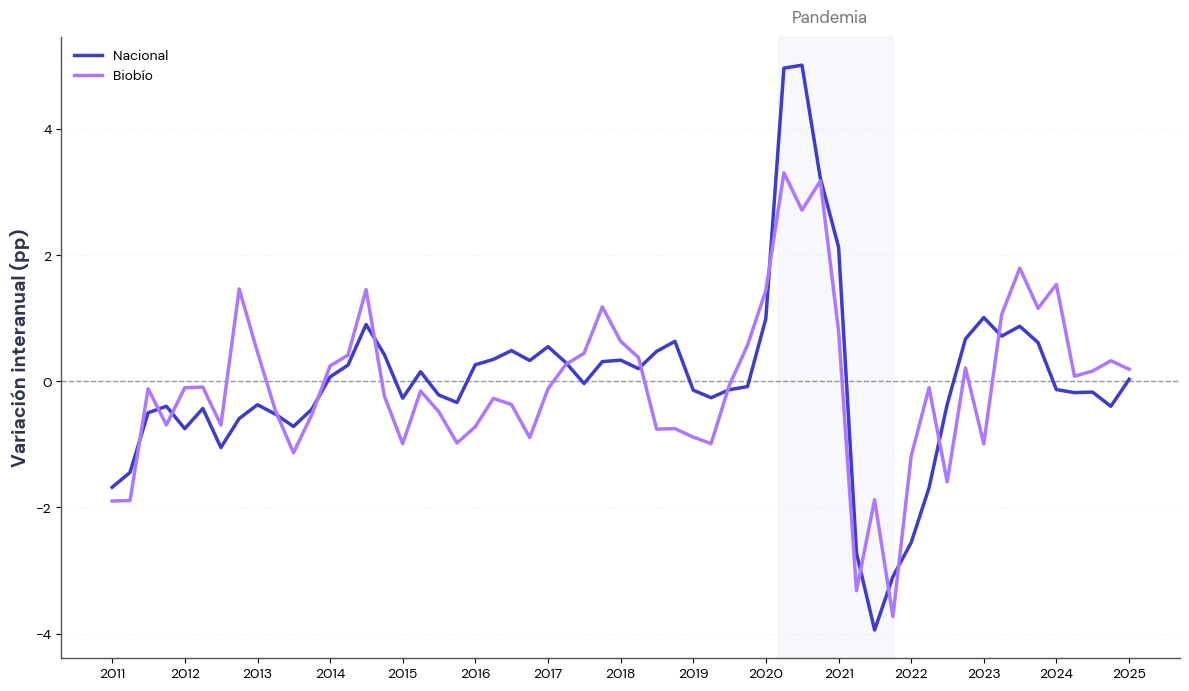


🎨 Fuente configurada: DM Sans
🎨 Fuente en título: DM Sans
📊 Total fuentes registradas: 3


In [ ]:
# ─── 1. Cargar DM Sans desde Google Drive ─────────────────────────────────────
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np

# Rutas donde buscar las fuentes DM Sans en tu Drive
FONT_PATHS = [
    "/content/drive/MyDrive/Data/fonts/",  # Carpeta fonts en Data
]

# Nombres de archivos de fuente a buscar
FONT_FILES = [
    "DMSans-Regular.ttf",
    "DMSans-Bold.ttf",
    "DMSans-Italic.ttf",
]

print("🔍 Buscando fuentes DM Sans en Google Drive...")
found_fonts = []

# Buscar fuentes en las rutas especificadas
for base_path in FONT_PATHS:
    font_dir = Path(base_path)
    if font_dir.exists():
        print(f"   📁 Revisando: {font_dir}")
        for font_file in FONT_FILES:
            font_path = font_dir / font_file
            if font_path.exists():
                found_fonts.append(font_path)
                print(f"   ✅ Encontrada: {font_file}")
    else:
        print(f"   ⚠️ No existe: {font_dir}")

# ─── 2. Registrar fuentes encontradas ──────────────────────────────────────────
registered_fonts = []
dm_font_name = None

for font_path in found_fonts:
    try:
        # Registrar la fuente
        fm.fontManager.addfont(str(font_path))
        registered_fonts.append(font_path)

        # Obtener el nombre real de la fuente
        font_props = fm.FontProperties(fname=str(font_path))
        font_name = font_props.get_name()

        if not dm_font_name:  # Usar la primera fuente como principal
            dm_font_name = font_name

        print(f"✅ Registrada: {font_path.name} → '{font_name}'")

    except Exception as e:
        print(f"❌ Error registrando {font_path.name}: {e}")

# ─── 3. Configurar matplotlib para usar DM Sans ───────────────────────────────
if dm_font_name:
    print(f"\n🎯 Configurando '{dm_font_name}' como fuente principal")

    # Método 1: Configurar rcParams
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': [dm_font_name, 'DejaVu Sans', 'Arial', 'Liberation Sans']
    })

    # Método 2: Crear FontProperties para uso directo
    dm_font_props = fm.FontProperties(family=dm_font_name)
    dm_font_bold = fm.FontProperties(family=dm_font_name, weight='bold')

    print("✅ DM Sans configurado exitosamente")


# ─── 4. Configuración de datos y paleta ───────────────────────────────────────
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
OUT_FILE   = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo.png")

PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",
]

# ─── 5. Cargar y procesar datos ────────────────────────────────────────────────
df = pd.read_excel(PANEL_PATH, sheet_name="biobio_vs_nacional")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df.sort_values("Fecha", inplace=True)

# Extraer trimestre móvil
df["Trimestre"] = df["Fecha"].dt.strftime("%b-%Y")

def variacion_interanual_trimestral(df_region):
    df_region = df_region.sort_values("Fecha").copy()

    # Calcular la variación interanual (pp): mismo trimestre, un año antes
    df_region["var"] = (
        df_region["T_TDO_indicadoresprincipales"]
        - df_region["T_TDO_indicadoresprincipales"].shift(4)
    )

    return df_region

nac = variacion_interanual_trimestral(df[df["region_name"] == "Nacional"].copy())
bio = variacion_interanual_trimestral(df[df["region_name"] == "Biobío"].copy())

# ─── 6. Crear gráfico con DM Sans ──────────────────────────────────────────────

import matplotlib.dates as mdates
from matplotlib.dates import date2num

fig, ax = plt.subplots(figsize=(12, 7))

# Pandemia: sombreado
ax.axvspan(
    date2num(pd.to_datetime("2020-03-01")),
    date2num(pd.to_datetime("2021-10-01")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# Líneas
ax.plot(nac["Fecha"], nac["var"], label="Nacional", color=PALETTE[3], linewidth=2.5, zorder=2)
ax.plot(bio["Fecha"], bio["var"], label="Biobío", color=PALETTE[6], linewidth=2.5, zorder=2)

# Línea 0
ax.axhline(0, color=PALETTE[0], linestyle="--", linewidth=1, alpha=0.6, zorder=1)

# Texto pandemia
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 1.03,
    "Pandemia",
    fontproperties=dm_font_props,
    fontsize=12,
    ha="center", va="bottom",
    color="#666666", alpha=0.9
)

# Ejes
ax.set_ylabel("Variación interanual (pp)",
              fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

# Fuente en ticks
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Estética
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

# Leyenda
ax.legend(frameon=False, loc="upper left", fontsize=12, prop=dm_font_props)

plt.tight_layout()
plt.show()



# ─── 7. Verificar fuente y mostrar ─────────────────────────────────────────────
print(f"\n🎨 Fuente configurada: {dm_font_name}")
print(f"🎨 Fuente en título: {ax.title.get_fontname()}")
print(f"📊 Total fuentes registradas: {len(registered_fonts)}")

plt.show()



🔍 Buscando fuentes DM Sans en Google Drive...
   📁 Revisando: /content/drive/MyDrive/Data/fonts
   ✅ Encontrada: DMSans-Regular.ttf
   ✅ Encontrada: DMSans-Bold.ttf
   ✅ Encontrada: DMSans-Italic.ttf
✅ Registrada: DMSans-Regular.ttf → 'DM Sans'
✅ Registrada: DMSans-Bold.ttf → 'DM Sans'
✅ Registrada: DMSans-Italic.ttf → 'DM Sans'

🎯 Configurando 'DM Sans' como fuente principal
✅ DM Sans configurado exitosamente

🎨 Fuente configurada: DM Sans
📊 Total fuentes registradas: 3


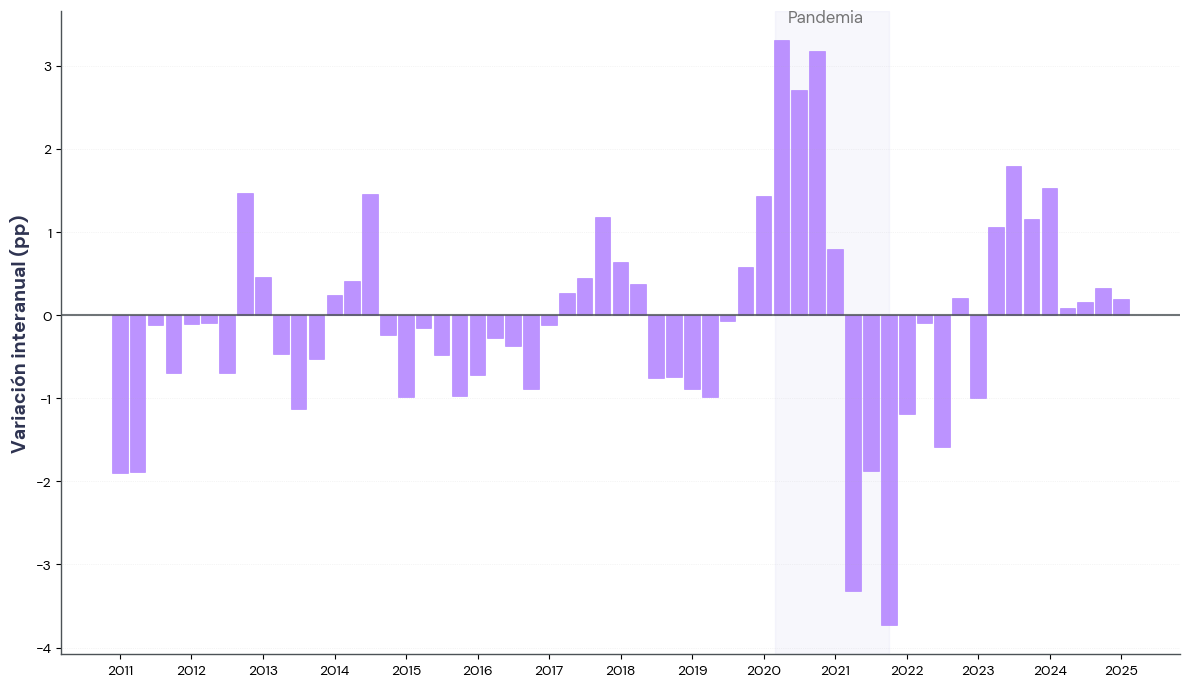

In [ ]:
# ─── 1. Cargar DM Sans desde Google Drive ─────────────────────────────────────
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np

# Rutas donde buscar las fuentes DM Sans en tu Drive
FONT_PATHS = [
    "/content/drive/MyDrive/Data/fonts/",  # Carpeta fonts en Data
]

# Nombres de archivos de fuente a buscar
FONT_FILES = [
    "DMSans-Regular.ttf",
    "DMSans-Bold.ttf",
    "DMSans-Italic.ttf",
]

print("🔍 Buscando fuentes DM Sans en Google Drive...")
found_fonts = []

# Buscar fuentes en las rutas especificadas
for base_path in FONT_PATHS:
    font_dir = Path(base_path)
    if font_dir.exists():
        print(f"   📁 Revisando: {font_dir}")
        for font_file in FONT_FILES:
            font_path = font_dir / font_file
            if font_path.exists():
                found_fonts.append(font_path)
                print(f"   ✅ Encontrada: {font_file}")
    else:
        print(f"   ⚠️ No existe: {font_dir}")

# ─── 2. Registrar fuentes encontradas ──────────────────────────────────────────
registered_fonts = []
dm_font_name = None

for font_path in found_fonts:
    try:
        # Registrar la fuente
        fm.fontManager.addfont(str(font_path))
        registered_fonts.append(font_path)

        # Obtener el nombre real de la fuente
        font_props = fm.FontProperties(fname=str(font_path))
        font_name = font_props.get_name()

        if not dm_font_name:  # Usar la primera fuente como principal
            dm_font_name = font_name

        print(f"✅ Registrada: {font_path.name} → '{font_name}'")

    except Exception as e:
        print(f"❌ Error registrando {font_path.name}: {e}")

# ─── 3. Configurar matplotlib para usar DM Sans ───────────────────────────────
if dm_font_name:
    print(f"\n🎯 Configurando '{dm_font_name}' como fuente principal")

    # Método 1: Configurar rcParams
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': [dm_font_name, 'DejaVu Sans', 'Arial', 'Liberation Sans']
    })

    # Método 2: Crear FontProperties para uso directo
    dm_font_props = fm.FontProperties(family=dm_font_name)
    dm_font_bold = fm.FontProperties(family=dm_font_name, weight='bold')

    print("✅ DM Sans configurado exitosamente")


# ─── 4. Configuración de datos y paleta ───────────────────────────────────────
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
OUT_FILE   = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo_barras.png")

PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",
]

# ─── 5. Cargar y procesar datos ────────────────────────────────────────────────
df = pd.read_excel(PANEL_PATH, sheet_name="biobio_vs_nacional")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df.sort_values("Fecha", inplace=True)

# Extraer trimestre móvil
df["Trimestre"] = df["Fecha"].dt.strftime("%b-%Y")

def variacion_interanual_pp(df_region):
    df_region = df_region.sort_values("Fecha").copy()

    # Cálculo correcto: variación interanual entre trimestres calendario (Q1 vs Q1, etc.)
    df_region["var"] = (
        df_region["T_TDO_indicadoresprincipales"]
        - df_region["T_TDO_indicadoresprincipales"].shift(4)
    )

    return df_region

# Solo procesar Biobío
bio = variacion_interanual_pp(df[df["region_name"] == "Biobío"].copy())

# ─── 6. Crear gráfico de barras con DM Sans ───────────────────────────────────

import matplotlib.dates as mdates
from matplotlib.dates import date2num

fig, ax = plt.subplots(figsize=(12, 7))

# Crear barras
bars = ax.bar(bio["Fecha"], bio["var"],
              color=PALETTE[6], alpha=0.8,
              width=80, edgecolor=PALETTE[6], linewidth=0.5)

# Colorear barras según valor (positivo/negativo)
for i, (bar, val) in enumerate(zip(bars, bio["var"])):
    if val >= 0:
        bar.set_color(PALETTE[6])  # Color principal para positivos
    else:
        bar.set_color(PALETTE[6])  # Color alternativo para negativos

# Pandemia: sombreado
ax.axvspan(
    date2num(pd.to_datetime("2020-03-01")),
    date2num(pd.to_datetime("2021-10-01")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# Línea 0
ax.axhline(0, color=PALETTE[0], linestyle="-", linewidth=1.5, alpha=0.8, zorder=3)

# Texto pandemia
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 0.95,
    "Pandemia",
    fontproperties=dm_font_props,
    fontsize=12,
    ha="center", va="bottom",
    color="#666666", alpha=0.9
)

# Ejes
ax.set_ylabel("Variación interanual (pp)",
              fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

# Fuente en ticks
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Estética
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)


plt.tight_layout()

# ─── 7. Verificar fuente y mostrar ─────────────────────────────────────────────
print(f"\n🎨 Fuente configurada: {dm_font_name}")
print(f"📊 Total fuentes registradas: {len(registered_fonts)}")

plt.show()

# Opcional: Guardar el gráfico
# plt.savefig(OUT_FILE, dpi=300, bbox_inches='tight', facecolor='white')

🔍 Buscando fuentes DM Sans en Google Drive...
   📁 Revisando: /content/drive/MyDrive/Data/fonts
   ✅ Encontrada: DMSans-Regular.ttf
   ✅ Encontrada: DMSans-Bold.ttf
   ✅ Encontrada: DMSans-Italic.ttf
✅ Registrada: DMSans-Regular.ttf → 'DM Sans'
✅ Registrada: DMSans-Bold.ttf → 'DM Sans'
✅ Registrada: DMSans-Italic.ttf → 'DM Sans'

🎯 Configurando 'DM Sans' como fuente principal
✅ DM Sans configurado exitosamente

🎨 Fuente configurada: DM Sans
📊 Total fuentes registradas: 3

📋 Datos procesados:
Año | TDO Promedio | Cambio (pp)
-----------------------------------
2011 | 8.33% | -1.15
2012 | 8.47% | +0.14
2013 | 8.05% | -0.42
2014 | 8.52% | +0.47
2015 | 7.87% | -0.65
2016 | 7.31% | -0.56
2017 | 7.76% | +0.44
2018 | 7.63% | -0.12
2019 | 7.29% | -0.34
2020 | 9.95% | +2.66
2021 | 7.92% | -2.03
2022 | 7.25% | -0.67
2023 | 8.00% | +0.75
2024 | 8.53% | +0.53
2025 | 8.98% | +0.46


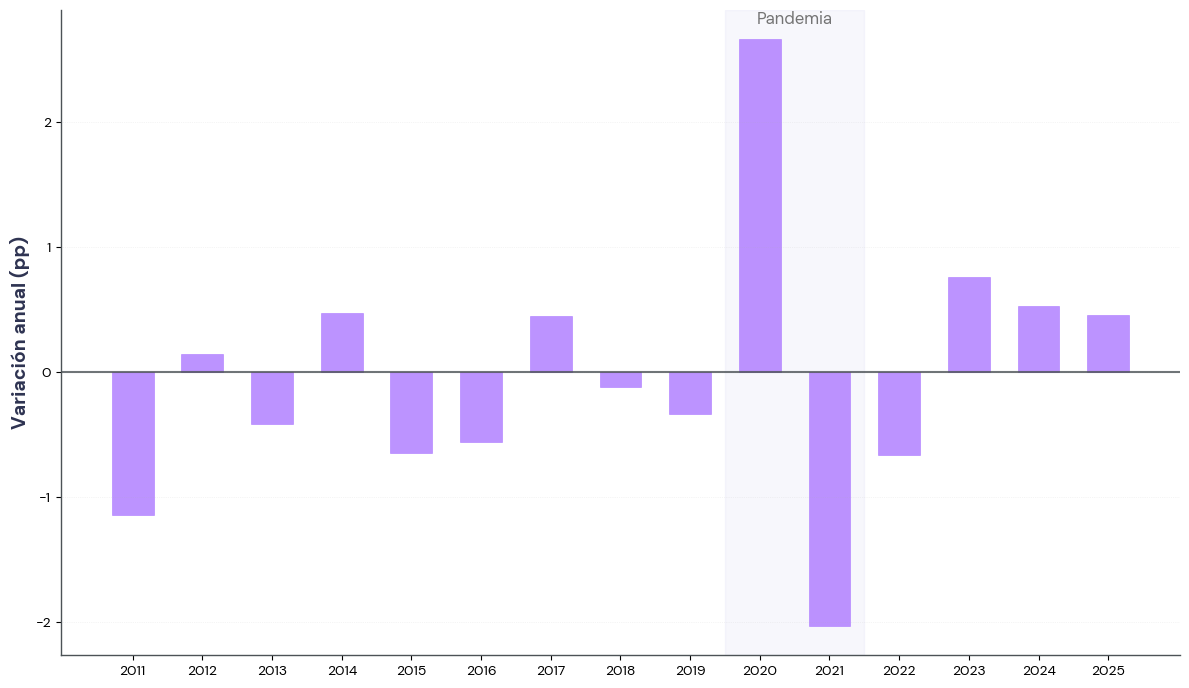

In [ ]:
# ─── 1. Cargar DM Sans desde Google Drive ─────────────────────────────────────
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np

# Rutas donde buscar las fuentes DM Sans en tu Drive
FONT_PATHS = [
    "/content/drive/MyDrive/Data/fonts/",  # Carpeta fonts en Data
]

# Nombres de archivos de fuente a buscar
FONT_FILES = [
    "DMSans-Regular.ttf",
    "DMSans-Bold.ttf",
    "DMSans-Italic.ttf",
]

print("🔍 Buscando fuentes DM Sans en Google Drive...")
found_fonts = []

# Buscar fuentes en las rutas especificadas
for base_path in FONT_PATHS:
    font_dir = Path(base_path)
    if font_dir.exists():
        print(f"   📁 Revisando: {font_dir}")
        for font_file in FONT_FILES:
            font_path = font_dir / font_file
            if font_path.exists():
                found_fonts.append(font_path)
                print(f"   ✅ Encontrada: {font_file}")
    else:
        print(f"   ⚠️ No existe: {font_dir}")

# ─── 2. Registrar fuentes encontradas ──────────────────────────────────────────
registered_fonts = []
dm_font_name = None

for font_path in found_fonts:
    try:
        # Registrar la fuente
        fm.fontManager.addfont(str(font_path))
        registered_fonts.append(font_path)

        # Obtener el nombre real de la fuente
        font_props = fm.FontProperties(fname=str(font_path))
        font_name = font_props.get_name()

        if not dm_font_name:  # Usar la primera fuente como principal
            dm_font_name = font_name

        print(f"✅ Registrada: {font_path.name} → '{font_name}'")

    except Exception as e:
        print(f"❌ Error registrando {font_path.name}: {e}")

# ─── 3. Configurar matplotlib para usar DM Sans ───────────────────────────────
if dm_font_name:
    print(f"\n🎯 Configurando '{dm_font_name}' como fuente principal")

    # Método 1: Configurar rcParams
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': [dm_font_name, 'DejaVu Sans', 'Arial', 'Liberation Sans']
    })

    # Método 2: Crear FontProperties para uso directo
    dm_font_props = fm.FontProperties(family=dm_font_name)
    dm_font_bold = fm.FontProperties(family=dm_font_name, weight='bold')

    print("✅ DM Sans configurado exitosamente")


# ─── 4. Configuración de datos y paleta ───────────────────────────────────────
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
OUT_FILE   = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo_barras.png")

PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",
]

# ─── 5. Cargar y procesar datos ────────────────────────────────────────────────
df = pd.read_excel(PANEL_PATH, sheet_name="biobio_vs_nacional")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df.sort_values("Fecha", inplace=True)

# Filtrar solo Biobío
bio_df = df[df["region_name"] == "Biobío"].copy()

# Extraer año
bio_df["Año"] = bio_df["Fecha"].dt.year

# Calcular promedio anual del TDO por año
bio_anual = bio_df.groupby("Año")["T_TDO_indicadoresprincipales"].mean().reset_index()
bio_anual.columns = ["Año", "TDO_promedio"]

# Calcular cambio interanual en puntos porcentuales
bio_anual["cambio_pp"] = bio_anual["TDO_promedio"].diff()

# Eliminar el primer año (no tiene cambio)
bio = bio_anual.dropna().copy()

# ─── 6. Crear gráfico de barras con DM Sans ───────────────────────────────────

fig, ax = plt.subplots(figsize=(12, 7))

# Crear barras
bars = ax.bar(bio["Año"], bio["cambio_pp"],
              color=PALETTE[6], alpha=0.8,
              width=0.6, edgecolor=PALETTE[6], linewidth=0.5)

# Colorear barras según valor (positivo/negativo)
for i, (bar, val) in enumerate(zip(bars, bio["cambio_pp"])):
    if val >= 0:
        bar.set_color(PALETTE[6])  # Color principal para positivos
    else:
        bar.set_color(PALETTE[6])  # Color alternativo para negativos

# Pandemia: sombreado (años 2020-2021)
ax.axvspan(2019.5, 2021.5, color="#3e3cca", alpha=0.04, zorder=0)

# Línea 0
ax.axhline(0, color=PALETTE[0], linestyle="-", linewidth=1.5, alpha=0.8, zorder=3)

# Texto pandemia
ax.text(2020.5, ax.get_ylim()[1] * 0.95, "Pandemia",
        fontproperties=dm_font_props, fontsize=12,
        ha="center", va="bottom", color="#666666", alpha=0.9)

# Ejes
ax.set_ylabel("Variación anual (pp)",
              fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])
ax.set_xlabel("")

# Configurar eje X para años
ax.set_xticks(bio["Año"])
ax.set_xticklabels([str(int(año)) for año in bio["Año"]])
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

# Fuente en ticks
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Estética
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)


plt.tight_layout()

# ─── 7. Verificar fuente, mostrar datos y gráfico ──────────────────────────────
print(f"\n🎨 Fuente configurada: {dm_font_name}")
print(f"📊 Total fuentes registradas: {len(registered_fonts)}")

# Mostrar tabla de datos
print(f"\n📋 Datos procesados:")
print("Año | TDO Promedio | Cambio (pp)")
print("-" * 35)
for _, row in bio.iterrows():
    print(f"{int(row['Año'])} | {row['TDO_promedio']:.2f}% | {row['cambio_pp']:+.2f}")

plt.show()

# Opcional: Guardar el gráfico
# plt.savefig(OUT_FILE, dpi=300, bbox_inches='tight', facecolor='white')

🔍 Buscando fuentes DM Sans en Google Drive...
   📁 Revisando: /content/drive/MyDrive/Data/fonts
   ✅ Encontrada: DMSans-Regular.ttf
   ✅ Encontrada: DMSans-Bold.ttf
   ✅ Encontrada: DMSans-Italic.ttf
✅ Registrada: DMSans-Regular.ttf → 'DM Sans'
✅ Registrada: DMSans-Bold.ttf → 'DM Sans'
✅ Registrada: DMSans-Italic.ttf → 'DM Sans'

🎯 Configurando 'DM Sans' como fuente principal
✅ DM Sans configurado exitosamente

🎨 Fuente configurada: DM Sans
📊 Total fuentes registradas: 3


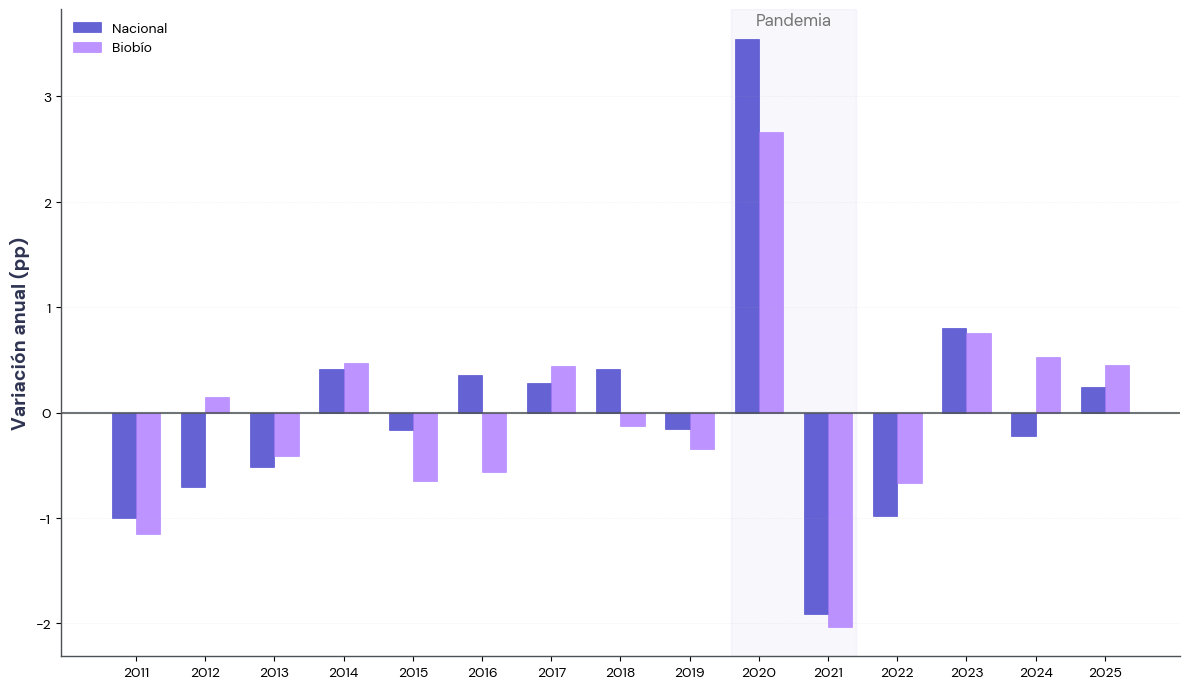

In [ ]:
# ─── 1. Cargar DM Sans desde Google Drive ─────────────────────────────────────
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np

# Rutas donde buscar las fuentes DM Sans en tu Drive
FONT_PATHS = [
    "/content/drive/MyDrive/Data/fonts/",  # Carpeta fonts en Data
]

# Nombres de archivos de fuente a buscar
FONT_FILES = [
    "DMSans-Regular.ttf",
    "DMSans-Bold.ttf",
    "DMSans-Italic.ttf",
]

print("🔍 Buscando fuentes DM Sans en Google Drive...")
found_fonts = []

# Buscar fuentes en las rutas especificadas
for base_path in FONT_PATHS:
    font_dir = Path(base_path)
    if font_dir.exists():
        print(f"   📁 Revisando: {font_dir}")
        for font_file in FONT_FILES:
            font_path = font_dir / font_file
            if font_path.exists():
                found_fonts.append(font_path)
                print(f"   ✅ Encontrada: {font_file}")
    else:
        print(f"   ⚠️ No existe: {font_dir}")

# ─── 2. Registrar fuentes encontradas ──────────────────────────────────────────
registered_fonts = []
dm_font_name = None

for font_path in found_fonts:
    try:
        # Registrar la fuente
        fm.fontManager.addfont(str(font_path))
        registered_fonts.append(font_path)

        # Obtener el nombre real de la fuente
        font_props = fm.FontProperties(fname=str(font_path))
        font_name = font_props.get_name()

        if not dm_font_name:  # Usar la primera fuente como principal
            dm_font_name = font_name

        print(f"✅ Registrada: {font_path.name} → '{font_name}'")

    except Exception as e:
        print(f"❌ Error registrando {font_path.name}: {e}")

# ─── 3. Configurar matplotlib para usar DM Sans ───────────────────────────────
if dm_font_name:
    print(f"\n🎯 Configurando '{dm_font_name}' como fuente principal")

    # Método 1: Configurar rcParams
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': [dm_font_name, 'DejaVu Sans', 'Arial', 'Liberation Sans']
    })

    # Método 2: Crear FontProperties para uso directo
    dm_font_props = fm.FontProperties(family=dm_font_name)
    dm_font_bold = fm.FontProperties(family=dm_font_name, weight='bold')

    print("✅ DM Sans configurado exitosamente")


# ─── 4. Configuración de datos y paleta ───────────────────────────────────────
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
OUT_FILE   = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo_barras.png")

PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",
]

# ─── 5. Cargar y procesar datos ────────────────────────────────────────────────
df = pd.read_excel(PANEL_PATH, sheet_name="biobio_vs_nacional")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df.sort_values("Fecha", inplace=True)

# Extraer año
df["Año"] = df["Fecha"].dt.year

# Procesar tanto Nacional como Biobío
def procesar_region(df_region, region_name):
    # Calcular promedio anual del TDO por año
    anual = df_region.groupby("Año")["T_TDO_indicadoresprincipales"].mean().reset_index()
    anual.columns = ["Año", "TDO_promedio"]

    # Calcular cambio interanual en puntos porcentuales
    anual["cambio_pp"] = anual["TDO_promedio"].diff()
    anual["region"] = region_name

    # Eliminar el primer año (no tiene cambio)
    return anual.dropna().copy()

# Procesar ambas regiones
nac = procesar_region(df[df["region_name"] == "Nacional"].copy(), "Nacional")
bio = procesar_region(df[df["region_name"] == "Biobío"].copy(), "Biobío")

# Combinar datos
datos_combinados = pd.concat([nac, bio], ignore_index=True)

# ─── 6. Crear gráfico de barras comparativo con DM Sans ──────────────────────

fig, ax = plt.subplots(figsize=(12, 7))

# Preparar datos para barras agrupadas
años = nac["Año"].values
x_pos = np.arange(len(años))
width = 0.35

# Crear barras agrupadas
bars_nac = ax.bar(x_pos - width/2, nac["cambio_pp"], width,
                  label="Nacional", color=PALETTE[3], alpha=0.8,
                  edgecolor=PALETTE[3], linewidth=0.5)

bars_bio = ax.bar(x_pos + width/2, bio["cambio_pp"], width,
                  label="Biobío", color=PALETTE[6], alpha=0.8,
                  edgecolor=PALETTE[6], linewidth=0.5)


# Pandemia: sombreado
# Encontrar posiciones de 2020 y 2021
años_list = list(años)
if 2020 in años_list and 2021 in años_list:
    pos_2020 = años_list.index(2020)
    pos_2021 = años_list.index(2021)
    ax.axvspan(pos_2020 - 0.4, pos_2021 + 0.4,
               color="#3e3cca", alpha=0.04, zorder=0)

# Línea 0
ax.axhline(0, color=PALETTE[0], linestyle="-", linewidth=1.5, alpha=0.8, zorder=3)

# Texto pandemia
if 2020 in años_list:
    pos_pandemia = años_list.index(2020) + 0.5
    ax.text(pos_pandemia, ax.get_ylim()[1] * 0.95, "Pandemia",
            fontproperties=dm_font_props, fontsize=12,
            ha="center", va="bottom", color="#666666", alpha=0.9)

# Ejes
ax.set_ylabel("Variación anual (pp)",
              fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])
ax.set_xlabel("")

# Configurar eje X
ax.set_xticks(x_pos)
ax.set_xticklabels([str(int(año)) for año in años])
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

# Fuente en ticks
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Estética
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

# Leyenda
ax.legend(frameon=False, loc="upper left", fontsize=12, prop=dm_font_props)


plt.tight_layout()

# ─── 7. Verificar fuente, mostrar datos y gráfico ──────────────────────────────
print(f"\n🎨 Fuente configurada: {dm_font_name}")
print(f"📊 Total fuentes registradas: {len(registered_fonts)}")


plt.show()

# Opcional: Guardar el gráfico
# plt.savefig(OUT_FILE, dpi=300, bbox_inches='tight', facecolor='white')

In [ ]:
# ================= 0. MONTAR DRIVE =====================================
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


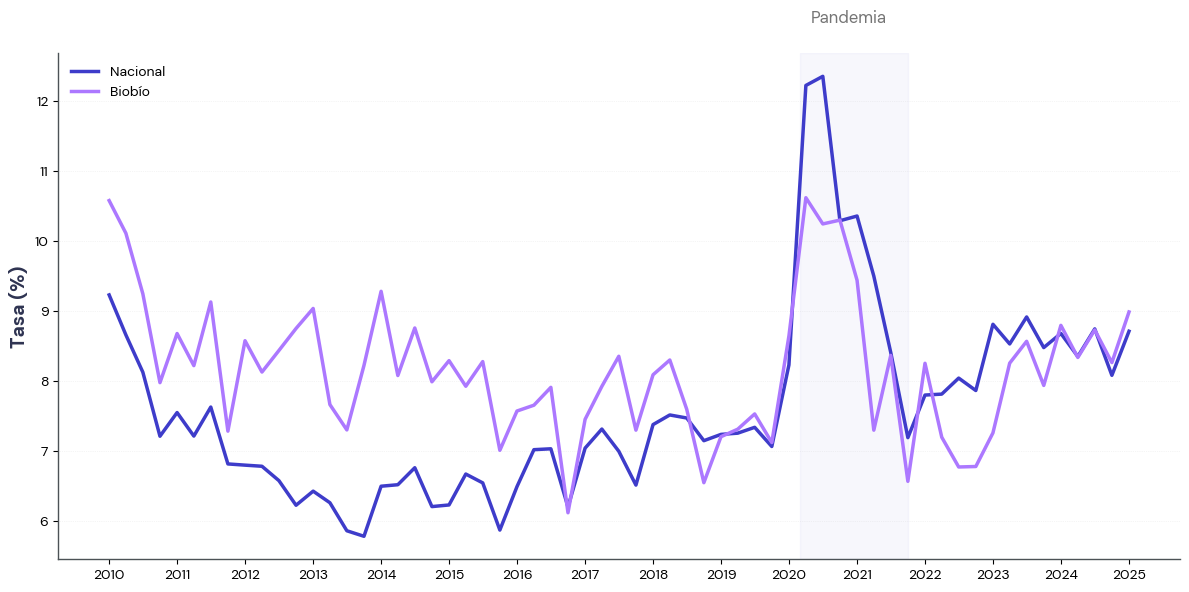

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})


# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar Nacional y Biobío ────────────────────────────────────────────────
df_nac = df[df["region_name"] == "Nacional"]
df_bio = df[df["region_name"] == "Biobío"]

import matplotlib.dates as mdates
from matplotlib.dates import date2num

# ─── Crear gráfico ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))

# Sombreado leve para pandemia (muy tenue y atrás)
ax.axvspan(
    date2num(pd.to_datetime("2020-03-01")),
    date2num(pd.to_datetime("2021-10-01")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# Líneas
ax.plot(df_nac["Fecha"], df_nac["T_TDO_indicadoresprincipales"],label="Nacional", color="#3e3cca", linewidth=2.5)
ax.plot(df_bio["Fecha"], df_bio["T_TDO_indicadoresprincipales"],label="Biobío", color="#ac78ff", linewidth=2.5)


# Texto “Pandemia” desplazado hacia arriba
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 1.03,  # un poquito más alto
    "Pandemia",
    fontproperties=dm_font_props,
    fontsize=12,
    ha="center",
    va="bottom",
    color="#666666",
    alpha=0.9
)


# Eje Y
ax.set_ylabel("Tasa (%)", fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])

# Eje X
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)  # más grande
ax.tick_params(axis='y', labelsize=11)

# Ticks con DM Sans
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Fondo: líneas horizontales muy delgadas
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

# Quita bordes
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

# Leyenda
ax.legend(
    frameon=False, loc="upper left", fontsize=12, prop=dm_font_props
)

plt.tight_layout()
plt.show()


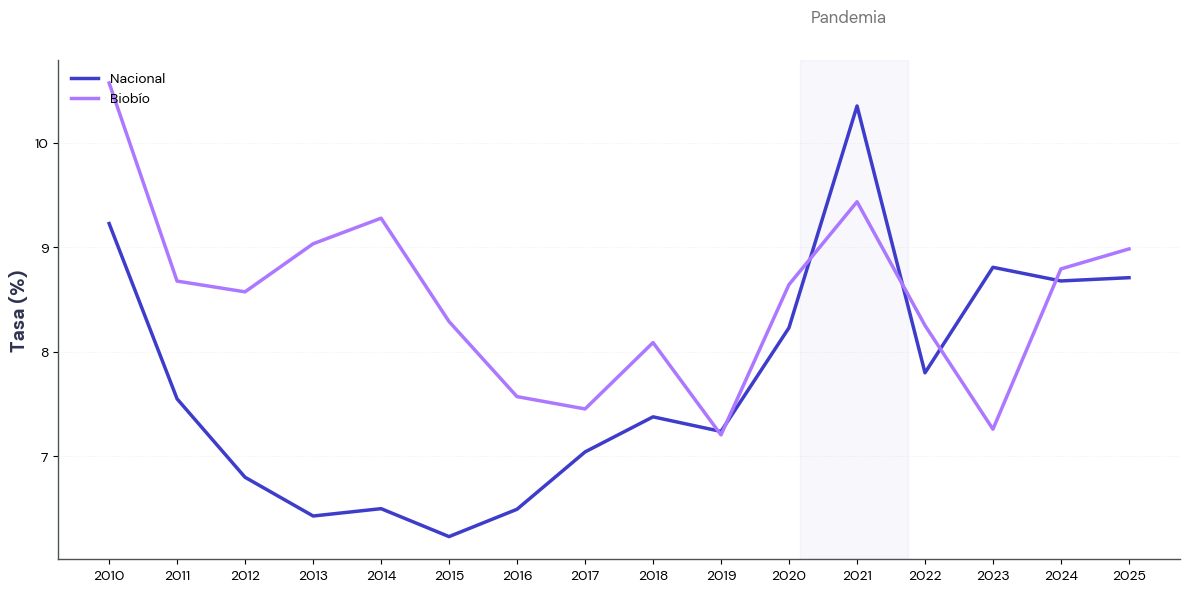

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path
from matplotlib.dates import date2num

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar solo Trimestre "Ene - Mar" ───────────────────────────────────────
df_q1 = df[df['Trimestre'] == "Ene - Mar"]

# ─── Filtrar Nacional y Biobío ────────────────────────────────────────────────
df_nac_q1 = df_q1[df_q1["region_name"] == "Nacional"]
df_bio_q1 = df_q1[df_q1["region_name"] == "Biobío"]

# ─── Crear gráfico ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))

# Sombreado leve para pandemia (muy tenue y atrás)
ax.axvspan(
    date2num(pd.to_datetime("2020-03-01")),
    date2num(pd.to_datetime("2021-10-01")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# Líneas
ax.plot(df_nac_q1["Fecha"], df_nac_q1["T_TDO_indicadoresprincipales"], label="Nacional", color="#3e3cca", linewidth=2.5)
ax.plot(df_bio_q1["Fecha"], df_bio_q1["T_TDO_indicadoresprincipales"], label="Biobío", color="#ac78ff", linewidth=2.5)

# Texto “Pandemia” desplazado hacia arriba
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 1.03,  # un poquito más alto
    "Pandemia",
    fontproperties=dm_font_props,
    fontsize=12,
    ha="center",
    va="bottom",
    color="#666666",
    alpha=0.9
)

# Eje Y
ax.set_ylabel("Tasa (%)", fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])

# Eje X
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)  # más grande
ax.tick_params(axis='y', labelsize=11)

# Ticks con DM Sans
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Fondo: líneas horizontales muy delgadas
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

# Quita bordes
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

# Leyenda
ax.legend(
    frameon=False, loc="upper right", fontsize=12, prop=dm_font_props
)

plt.tight_layout()
plt.show()



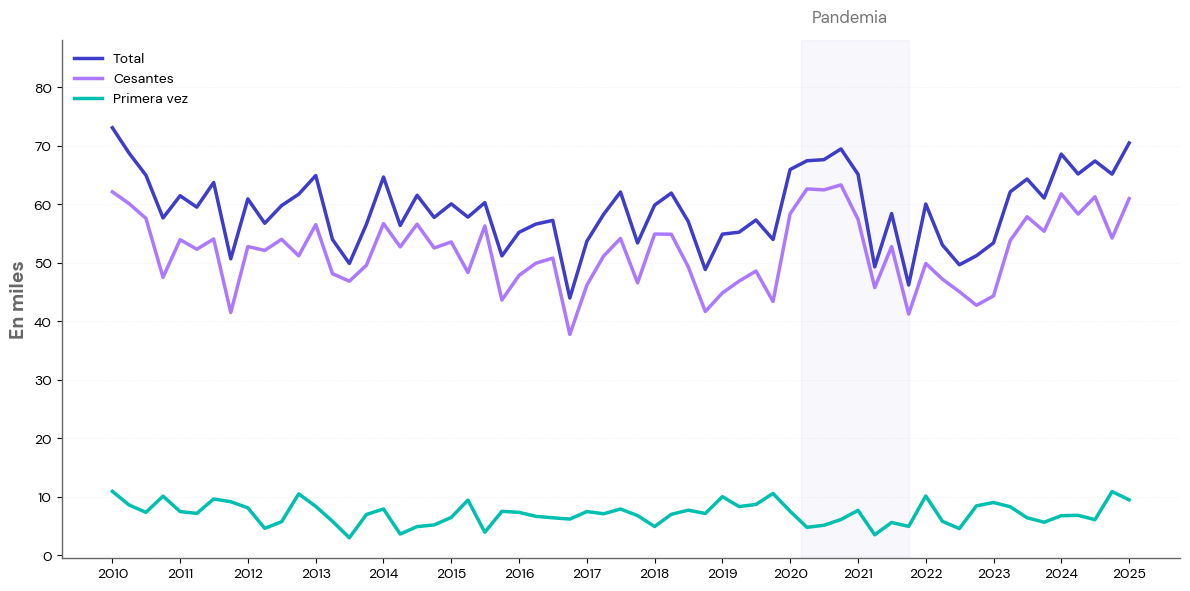

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path
from matplotlib.dates import date2num

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar solo la región del Biobío ────────────────────────────────────────
df_bio = df[df["region_name"] == "Biobío"]

# ─── Crear gráfico ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))

# Sombreado leve para pandemia (muy tenue y atrás)
ax.axvspan(
    date2num(pd.to_datetime("2020-03-01")),
    date2num(pd.to_datetime("2021-10-01")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# Líneas para las series de tiempo
ax.plot(df_bio["Fecha"], df_bio["PDO_TOT_indicadoresprincipales"], label="Total", color="#3e3cca", linewidth=2.5)
ax.plot(df_bio["Fecha"], df_bio["PDO_CES_indicadoresprincipales"], label="Cesantes", color="#ac78ff", linewidth=2.5)
ax.plot(df_bio["Fecha"], df_bio["PDO_BTP1_indicadoresprincipales"], label="Primera vez", color="#00bfae", linewidth=2.5)

# Texto “Pandemia” desplazado hacia arriba
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 1.18,  # Aumentamos el factor para mover el texto más arriba
    "Pandemia",
    fontproperties=dm_font_props,
    fontsize=12,
    ha="center",
    va="bottom",
    color="#666666",
    alpha=0.9
)

# Eje Y
ax.set_ylabel("En miles", fontproperties=dm_font_bold, fontsize=14, color="#666666")

# Eje X
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)  # más grande
ax.tick_params(axis='y', labelsize=11)

# Ticks con DM Sans
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Fondo: líneas horizontales muy delgadas
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

# Quita bordes
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color("#666666")
ax.spines["bottom"].set_color("#666666")
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

# Ajustar límite superior del eje Y para alargarlo
ax.set_ylim(bottom=ax.get_ylim()[0], top=ax.get_ylim()[1] * 1.15)

# Leyenda
ax.legend(
    frameon=False, loc="upper left", fontsize=12, prop=dm_font_props
)

plt.tight_layout()
plt.show()


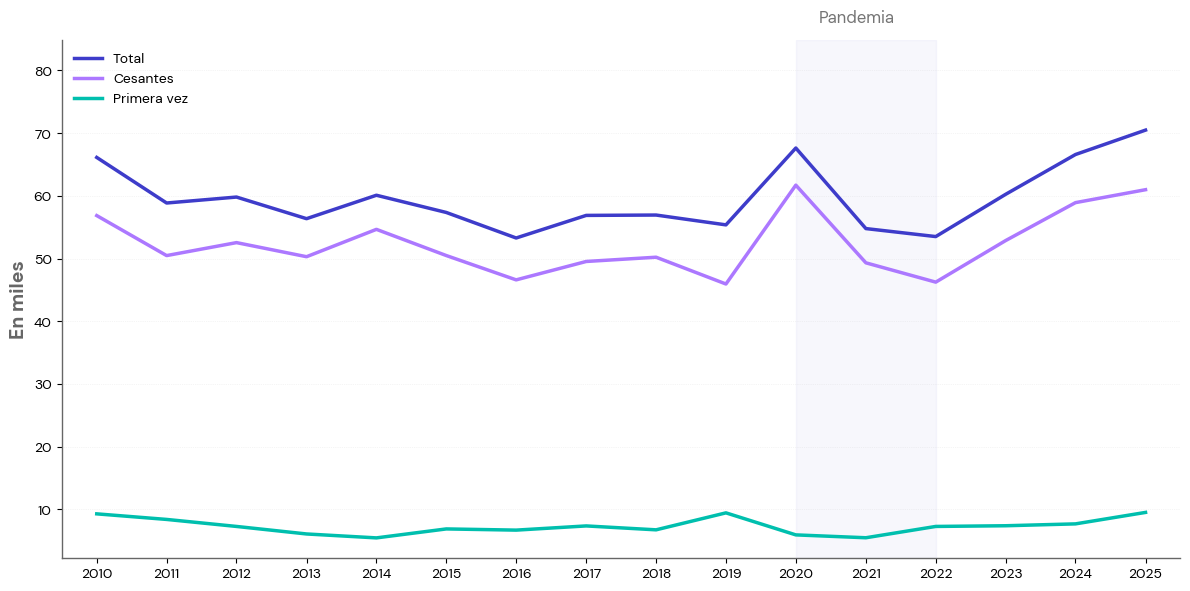

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path
from matplotlib.dates import date2num

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar solo la región del Biobío desde 2010 ────────────────────────────
df_bio = df[df["region_name"] == "Biobío"]
df_bio = df_bio[df_bio["Fecha"] >= "2010-01-01"]

# ─── Calcular promedios anuales ───────────────────────────────────────────────
df_bio['Año'] = df_bio['Fecha'].dt.year

promedios_anuales = df_bio.groupby('Año').agg({
    'PDO_TOT_indicadoresprincipales': 'mean',
    'PDO_CES_indicadoresprincipales': 'mean',
    'PDO_BTP1_indicadoresprincipales': 'mean'
}).reset_index()

# Crear fechas para el eje X (usando enero de cada año)
promedios_anuales['Fecha'] = pd.to_datetime(promedios_anuales['Año'].astype(str) + '-01-01')

# ─── Crear gráfico ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))

# Sombreado leve para pandemia (muy tenue y atrás)
ax.axvspan(
    date2num(pd.to_datetime("2020-01-01")),
    date2num(pd.to_datetime("2021-12-31")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# Líneas para las series de tiempo con marcadores
ax.plot(promedios_anuales["Fecha"], promedios_anuales["PDO_TOT_indicadoresprincipales"],
        label="Total", color="#3e3cca", linewidth=2.5, marker='o', markersize=0)
ax.plot(promedios_anuales["Fecha"], promedios_anuales["PDO_CES_indicadoresprincipales"],
        label="Cesantes", color="#ac78ff", linewidth=2.5, marker='s', markersize=0)
ax.plot(promedios_anuales["Fecha"], promedios_anuales["PDO_BTP1_indicadoresprincipales"],
        label="Primera vez", color="#00bfae", linewidth=2.5, marker='^', markersize=0)

# Texto "Pandemia" desplazado hacia arriba
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 1.18,
    "Pandemia",
    fontproperties=dm_font_props,
    fontsize=12,
    ha="center",
    va="bottom",
    color="#666666",
    alpha=0.9
)

# Eje Y
ax.set_ylabel("En miles", fontproperties=dm_font_bold, fontsize=14, color="#666666")

# Eje X
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Cada 2 años para mejor legibilidad
ax.xaxis.set_minor_locator(mdates.YearLocator(1))  # Marcas menores cada año
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

# Ticks con DM Sans
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Fondo: líneas horizontales muy delgadas
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

# Quita bordes
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color("#666666")
ax.spines["bottom"].set_color("#666666")
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

# Ajustar límite superior del eje Y para alargarlo
ax.set_ylim(bottom=ax.get_ylim()[0], top=ax.get_ylim()[1] * 1.15)

# Establecer límites del eje X (con margen antes de 2010)
ax.set_xlim(pd.to_datetime("2009-07-01"), pd.to_datetime(f"{promedios_anuales['Año'].max() }-06-30"))

# Leyenda
ax.legend(
    frameon=False, loc="upper left", fontsize=12, prop=dm_font_props
)


plt.tight_layout()
plt.show()



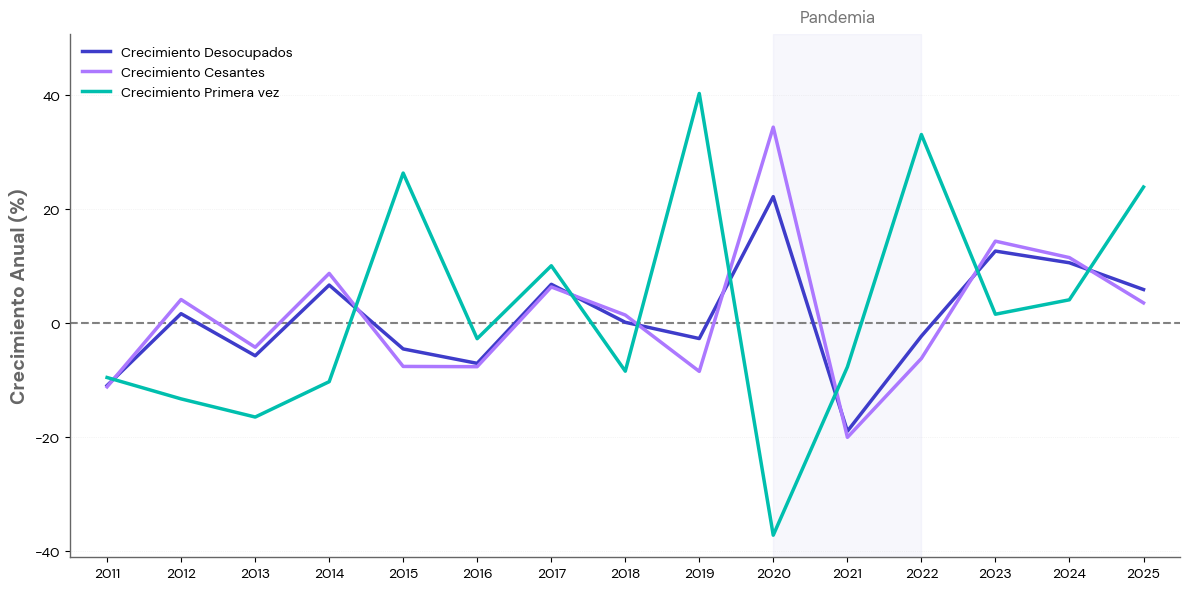

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path
from matplotlib.dates import date2num

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar solo la región del Biobío desde 2010 ────────────────────────────
df_bio = df[df["region_name"] == "Biobío"]
df_bio = df_bio[df_bio["Fecha"] >= "2010-01-01"]

# ─── Calcular promedios anuales ───────────────────────────────────────────────
df_bio['Año'] = df_bio['Fecha'].dt.year

promedios_anuales = df_bio.groupby('Año').agg({
    'PDO_TOT_indicadoresprincipales': 'mean',
    'PDO_CES_indicadoresprincipales': 'mean',
    'PDO_BTP1_indicadoresprincipales': 'mean'
}).reset_index()

# Crear fechas para el eje X (usando enero de cada año)
promedios_anuales['Fecha'] = pd.to_datetime(promedios_anuales['Año'].astype(str))

# ─── Calcular Crecimiento Anual (porcentaje) ───────────────────────────────────
promedios_anuales['Crecimiento_PDO_TOT'] = promedios_anuales['PDO_TOT_indicadoresprincipales'].pct_change() * 100
promedios_anuales['Crecimiento_PDO_CES'] = promedios_anuales['PDO_CES_indicadoresprincipales'].pct_change() * 100
promedios_anuales['Crecimiento_PDO_BTP1'] = promedios_anuales['PDO_BTP1_indicadoresprincipales'].pct_change() * 100

# ─── Crear gráfico de Crecimientos ─────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))

# Sombreado leve para pandemia (muy tenue y atrás)
ax.axvspan(
    date2num(pd.to_datetime("2020-01-01")),
    date2num(pd.to_datetime("2021-12-31")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# Líneas para las tasas de crecimiento anual
ax.plot(promedios_anuales["Fecha"], promedios_anuales["Crecimiento_PDO_TOT"],
        label="Crecimiento Desocupados", color="#3e3cca", linewidth=2.5, marker='o', markersize=0)
ax.plot(promedios_anuales["Fecha"], promedios_anuales["Crecimiento_PDO_CES"],
        label="Crecimiento Cesantes", color="#ac78ff", linewidth=2.5, marker='s', markersize=0)
ax.plot(promedios_anuales["Fecha"], promedios_anuales["Crecimiento_PDO_BTP1"],
        label="Crecimiento Primera vez", color="#00bfae", linewidth=2.5, marker='^', markersize=0)

# Línea punteada en el eje X en 0 (sin crecimiento)
ax.axhline(0, color='gray', linestyle='--', linewidth=1.5, zorder=1)


# Texto "Pandemia" desplazado hacia arriba
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 1.18,
    "Pandemia",
    fontproperties=dm_font_props,
    fontsize=12,
    ha="center",
    va="bottom",
    color="#666666",
    alpha=0.9
)

# Eje Y
ax.set_ylabel("Crecimiento Anual (%)", fontproperties=dm_font_bold, fontsize=14, color="#666666")

# Eje X
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Cada 2 años para mejor legibilidad
ax.xaxis.set_minor_locator(mdates.YearLocator(1))  # Marcas menores cada año
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

# Ticks con DM Sans
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Fondo: líneas horizontales muy delgadas
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

# Quita bordes
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color("#666666")
ax.spines["bottom"].set_color("#666666")
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

# Ajustar límite superior del eje Y para alargarlo
ax.set_ylim(bottom=ax.get_ylim()[0], top=ax.get_ylim()[1] * 1.15)

# Establecer límites del eje X (con margen antes de 2010)
ax.set_xlim(pd.to_datetime("2010-07-01"), pd.to_datetime(f"{promedios_anuales['Año'].max()}-06-30"))

# Leyenda
ax.legend(
    frameon=False, loc="upper left", fontsize=12, prop=dm_font_props
)

plt.tight_layout()
plt.show()


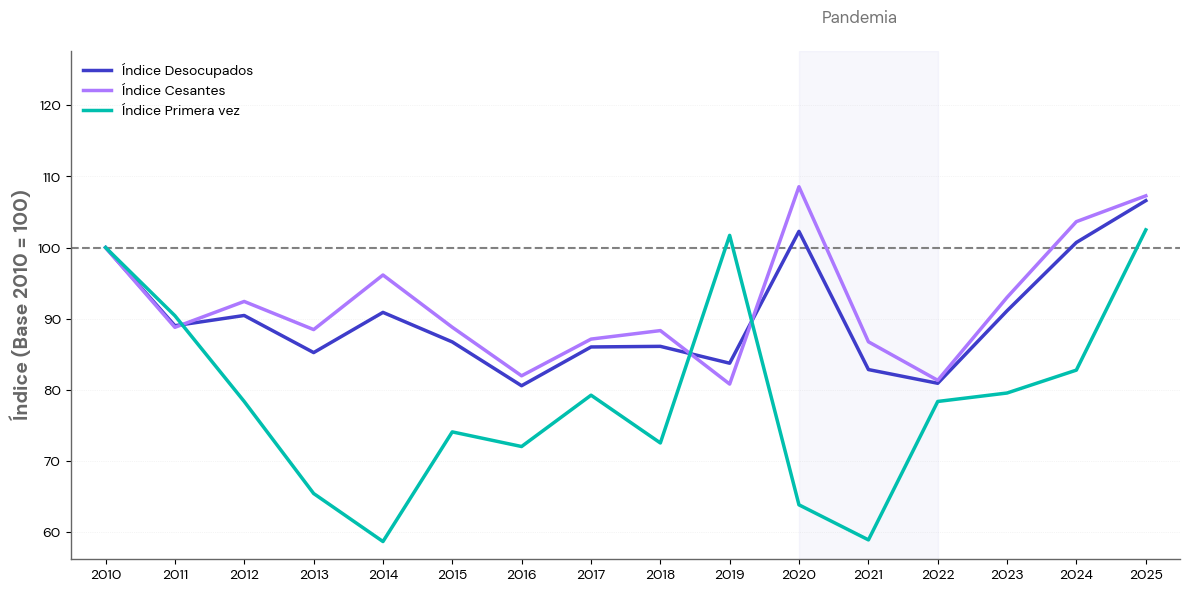

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path
from matplotlib.dates import date2num

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar solo la región del Biobío desde 2010 ────────────────────────────
df_bio = df[df["region_name"] == "Biobío"]
df_bio = df_bio[df_bio["Fecha"] >= "2010-01-01"]

# ─── Calcular promedios anuales ───────────────────────────────────────────────
df_bio['Año'] = df_bio['Fecha'].dt.year

promedios_anuales = df_bio.groupby('Año').agg({
    'PDO_TOT_indicadoresprincipales': 'mean',
    'PDO_CES_indicadoresprincipales': 'mean',
    'PDO_BTP1_indicadoresprincipales': 'mean'
}).reset_index()

# Crear fechas para el eje X (usando enero de cada año)
promedios_anuales['Fecha'] = pd.to_datetime(promedios_anuales['Año'].astype(str))

# ─── Indexar los valores a base 2010 ───────────────────────────────────────────
base_2010 = promedios_anuales[promedios_anuales['Año'] == 2010]

# Dividir por el valor de 2010 y multiplicar por 100 para indexar a base 100
promedios_anuales['Indexado_PDO_TOT'] = (promedios_anuales['PDO_TOT_indicadoresprincipales'] / base_2010['PDO_TOT_indicadoresprincipales'].values[0]) * 100
promedios_anuales['Indexado_PDO_CES'] = (promedios_anuales['PDO_CES_indicadoresprincipales'] / base_2010['PDO_CES_indicadoresprincipales'].values[0]) * 100
promedios_anuales['Indexado_PDO_BTP1'] = (promedios_anuales['PDO_BTP1_indicadoresprincipales'] / base_2010['PDO_BTP1_indicadoresprincipales'].values[0]) * 100

# ─── Crear gráfico de Índices ─────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))

# Sombreado leve para pandemia (muy tenue y atrás)
ax.axvspan(
    date2num(pd.to_datetime("2020-01-01")),
    date2num(pd.to_datetime("2021-12-31")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# Líneas para los índices desde 2010
ax.plot(promedios_anuales["Fecha"], promedios_anuales["Indexado_PDO_TOT"],
        label="Índice Desocupados", color="#3e3cca", linewidth=2.5, marker='o', markersize=0)
ax.plot(promedios_anuales["Fecha"], promedios_anuales["Indexado_PDO_CES"],
        label="Índice Cesantes", color="#ac78ff", linewidth=2.5, marker='s', markersize=0)
ax.plot(promedios_anuales["Fecha"], promedios_anuales["Indexado_PDO_BTP1"],
        label="Índice Primera vez", color="#00bfae", linewidth=2.5, marker='^', markersize=0)

# Línea punteada en el eje X en 100 (base 2010)
ax.axhline(100, color='gray', linestyle='--', linewidth=1.5, zorder=1)

# Texto "Pandemia" desplazado hacia arriba
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 1.18,
    "Pandemia",
    fontproperties=dm_font_props,
    fontsize=12,
    ha="center",
    va="bottom",
    color="#666666",
    alpha=0.9
)

# Eje Y
ax.set_ylabel("Índice (Base 2010 = 100)", fontproperties=dm_font_bold, fontsize=14, color="#666666")

# Eje X
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Cada 2 años para mejor legibilidad
ax.xaxis.set_minor_locator(mdates.YearLocator(1))  # Marcas menores cada año
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

# Ticks con DM Sans
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Fondo: líneas horizontales muy delgadas
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

# Quita bordes
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color("#666666")
ax.spines["bottom"].set_color("#666666")
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

# Ajustar límite superior del eje Y para alargarlo
ax.set_ylim(bottom=ax.get_ylim()[0], top=ax.get_ylim()[1] * 1.15)

# Establecer límites del eje X (con margen antes de 2010)
ax.set_xlim(pd.to_datetime("2009-07-01"), pd.to_datetime(f"{promedios_anuales['Año'].max()}-06-30"))

# Leyenda
ax.legend(
    frameon=False, loc="upper left", fontsize=12, prop=dm_font_props
)

plt.tight_layout()
plt.show()


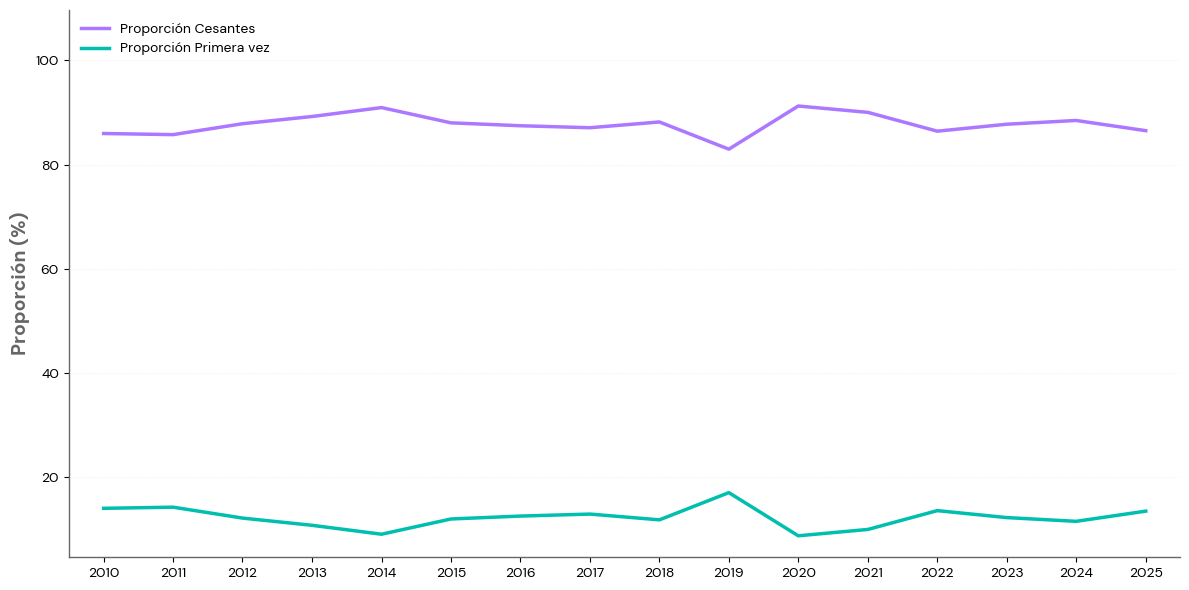

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path
from matplotlib.dates import date2num

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar solo la región del Biobío desde 2010 ────────────────────────────
df_bio = df[df["region_name"] == "Biobío"]
df_bio = df_bio[df_bio["Fecha"] >= "2010-01-01"]

# ─── Calcular promedios anuales ───────────────────────────────────────────────
df_bio['Año'] = df_bio['Fecha'].dt.year

promedios_anuales = df_bio.groupby('Año').agg({
    'PDO_TOT_indicadoresprincipales': 'mean',
    'PDO_CES_indicadoresprincipales': 'mean',
    'PDO_BTP1_indicadoresprincipales': 'mean'
}).reset_index()

# Crear fechas para el eje X (usando enero de cada año)
promedios_anuales['Fecha'] = pd.to_datetime(promedios_anuales['Año'].astype(str))

# ─── Calcular participación relativa ────────────────────────────────────────
# Calculamos la proporción de cesantes y de desocupados por primera vez
promedios_anuales['Proporción_Cesantes'] = promedios_anuales['PDO_CES_indicadoresprincipales'] / promedios_anuales['PDO_TOT_indicadoresprincipales'] * 100
promedios_anuales['Proporción_Primeravez'] = promedios_anuales['PDO_BTP1_indicadoresprincipales'] / promedios_anuales['PDO_TOT_indicadoresprincipales'] * 100

# ─── Crear gráfico de proporciones ───────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))

# Líneas para las proporciones
ax.plot(promedios_anuales["Fecha"], promedios_anuales["Proporción_Cesantes"],
        label="Proporción Cesantes", color="#ac78ff", linewidth=2.5, marker='s', markersize=0)
ax.plot(promedios_anuales["Fecha"], promedios_anuales["Proporción_Primeravez"],
        label="Proporción Primera vez", color="#00bfae", linewidth=2.5, marker='^', markersize=0)

# Eje Y
ax.set_ylabel("Proporción (%)", fontproperties=dm_font_bold, fontsize=14, color="#666666")

# Eje X
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Cada 2 años para mejor legibilidad
ax.xaxis.set_minor_locator(mdates.YearLocator(1))  # Marcas menores cada año
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

# Ticks con DM Sans
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Fondo: líneas horizontales muy delgadas
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

# Quita bordes
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color("#666666")
ax.spines["bottom"].set_color("#666666")
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

# Ajustar límite superior del eje Y para alargarlo
ax.set_ylim(bottom=ax.get_ylim()[0], top=ax.get_ylim()[1] * 1.15)

# Establecer límites del eje X (con margen antes de 2010)
ax.set_xlim(pd.to_datetime("2009-07-01"), pd.to_datetime(f"{promedios_anuales['Año'].max()}-06-30"))

# Leyenda
ax.legend(
    frameon=False, loc="upper left", fontsize=12, prop=dm_font_props
)

plt.tight_layout()
plt.show()


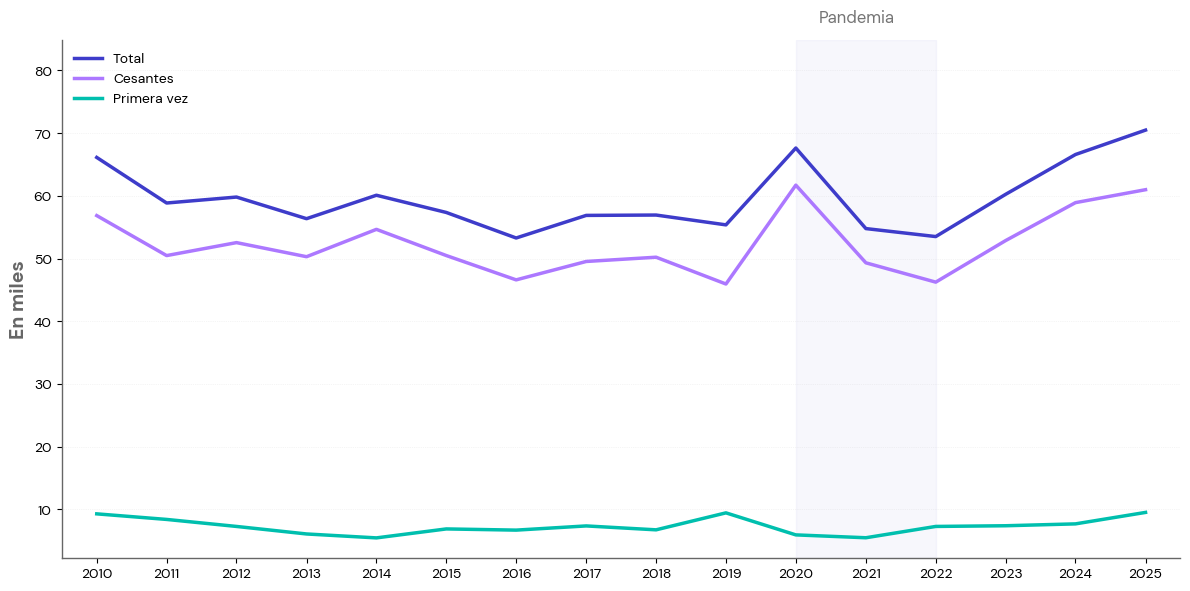

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path
from matplotlib.dates import date2num

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar solo la región del Biobío desde 2010 ────────────────────────────
df_bio = df[df["region_name"] == "Biobío"]
df_bio = df_bio[df_bio["Fecha"] >= "2010-01-01"]

# ─── Calcular promedios anuales ───────────────────────────────────────────────
df_bio['Año'] = df_bio['Fecha'].dt.year

promedios_anuales = df_bio.groupby('Año').agg({
    'PDO_TOT_indicadoresprincipales': 'mean',
    'PDO_CES_indicadoresprincipales': 'mean',
    'PDO_BTP1_indicadoresprincipales': 'mean'
}).reset_index()

# Crear fechas para el eje X (usando enero de cada año)
promedios_anuales['Fecha'] = pd.to_datetime(promedios_anuales['Año'].astype(str) + '-01-01')

# ─── Crear gráfico ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))  # Ajustar el tamaño de la figura

# Sombreado leve para pandemia (muy tenue y atrás)
ax.axvspan(
    date2num(pd.to_datetime("2020-01-01")),
    date2num(pd.to_datetime("2021-12-31")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# Líneas para las series de tiempo con marcadores
ax.plot(promedios_anuales["Fecha"], promedios_anuales["PDO_TOT_indicadoresprincipales"],
        label="Total", color="#3e3cca", linewidth=2.5, marker='o', markersize=0)
ax.plot(promedios_anuales["Fecha"], promedios_anuales["PDO_CES_indicadoresprincipales"],
        label="Cesantes", color="#ac78ff", linewidth=2.5, marker='s', markersize=0)
ax.plot(promedios_anuales["Fecha"], promedios_anuales["PDO_BTP1_indicadoresprincipales"],
        label="Primera vez", color="#00bfae", linewidth=2.5, marker='^', markersize=0)

# Texto "Pandemia" desplazado hacia arriba
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 1.18,
    "Pandemia",
    fontproperties=dm_font_props,
    fontsize=12,
    ha="center",
    va="bottom",
    color="#666666",
    alpha=0.9
)

# Eje Y
ax.set_ylabel("En miles", fontproperties=dm_font_bold, fontsize=14, color="#666666")

# Eje X
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Cada 1 año para mejor legibilidad
ax.xaxis.set_minor_locator(mdates.YearLocator(1))  # Marcas menores cada año
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

# Ticks con DM Sans
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Fondo: líneas horizontales muy delgadas
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

# Quitar bordes
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color("#666666")
ax.spines["bottom"].set_color("#666666")
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

# Ajustar límite superior del eje Y para alargarlo
ax.set_ylim(bottom=ax.get_ylim()[0], top=ax.get_ylim()[1] * 1.15)

# Establecer límites del eje X (con margen antes de 2010)
ax.set_xlim(pd.to_datetime("2009-07-01"), pd.to_datetime(f"{promedios_anuales['Año'].max() }-06-30"))

# Leyenda
ax.legend(
    frameon=False, loc="upper left", fontsize=12, prop=dm_font_props
)

# Fondo blanco para el gráfico
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()


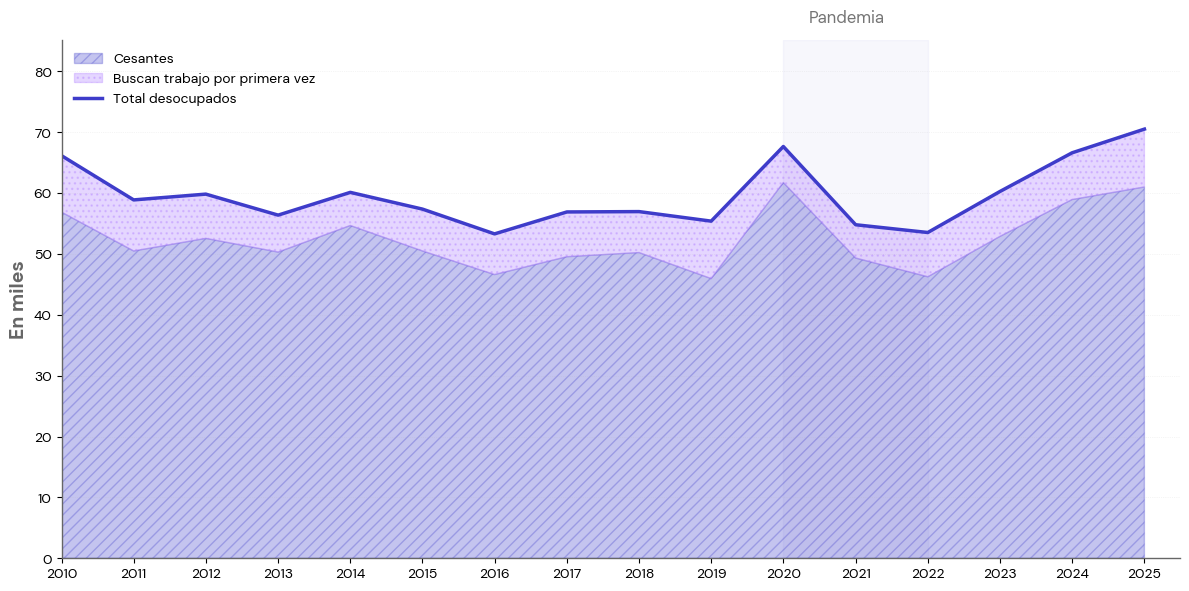

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path
from matplotlib.dates import date2num

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar solo la región del Biobío desde 2010 ────────────────────────────
df_bio = df[df["region_name"] == "Biobío"]
df_bio = df_bio[df_bio["Fecha"] >= "2010-01-01"]

# ─── Calcular promedios anuales ───────────────────────────────────────────────
df_bio['Año'] = df_bio['Fecha'].dt.year

promedios_anuales = df_bio.groupby('Año').agg({
    'PDO_TOT_indicadoresprincipales': 'mean',
    'PDO_CES_indicadoresprincipales': 'mean',
    'PDO_BTP1_indicadoresprincipales': 'mean'
}).reset_index()

# Crear fechas para el eje X (usando enero de cada año)
promedios_anuales['Fecha'] = pd.to_datetime(promedios_anuales['Año'].astype(str) + '-01-01')

# ─── Crear gráfico ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))  # Ajustar el tamaño de la figura

# Sombreado leve para pandemia (muy tenue y atrás)
ax.axvspan(
    date2num(pd.to_datetime("2020-01-01")),
    date2num(pd.to_datetime("2021-12-31")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# Áreas con patrones de achurado para mostrar participación de cesantes y los que buscan trabajo por primera vez
ax.fill_between(promedios_anuales['Fecha'],
                0,
                promedios_anuales['PDO_CES_indicadoresprincipales'],
                color='#3E3CCA', alpha=0.3, hatch='///', label='Cesantes')

ax.fill_between(promedios_anuales['Fecha'],
                promedios_anuales['PDO_CES_indicadoresprincipales'],
                promedios_anuales['PDO_TOT_indicadoresprincipales'],
                color='#AC78FF', alpha=0.3, hatch='...', label='Buscan trabajo por primera vez')

# Líneas para las series de tiempo con marcadores
ax.plot(promedios_anuales["Fecha"], promedios_anuales["PDO_TOT_indicadoresprincipales"],
        label="Total desocupados", color="#3e3cca", linewidth=2.5, marker='o', markersize=0)

# Texto "Pandemia" desplazado hacia arriba
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 1.18,
    "Pandemia",
    fontproperties=dm_font_props,
    fontsize=12,
    ha="center",
    va="bottom",
    color="#666666",
    alpha=0.9
)

# Eje Y
ax.set_ylabel("En miles", fontproperties=dm_font_bold, fontsize=14, color="#666666")

# Eje X
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Cada 1 año para mejor legibilidad
ax.xaxis.set_minor_locator(mdates.YearLocator(1))  # Marcas menores cada año
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

# Ticks con DM Sans
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Fondo: líneas horizontales muy delgadas
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

# Quitar bordes
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color("#666666")
ax.spines["bottom"].set_color("#666666")
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

# Ajustar límite superior del eje Y para alargarlo
ax.set_ylim(bottom=0, top=ax.get_ylim()[1] * 1.15)  # Asegurarse de que el eje Y comience en 0

# Establecer límites del eje X (con margen antes de 2010)
ax.set_xlim(pd.to_datetime("2010-01-01"), pd.to_datetime(f"{promedios_anuales['Año'].max() }-06-30"))

# Leyenda
ax.legend(
    frameon=False, loc="upper left", fontsize=12, prop=dm_font_props
)

# Fondo blanco para el gráfico
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()


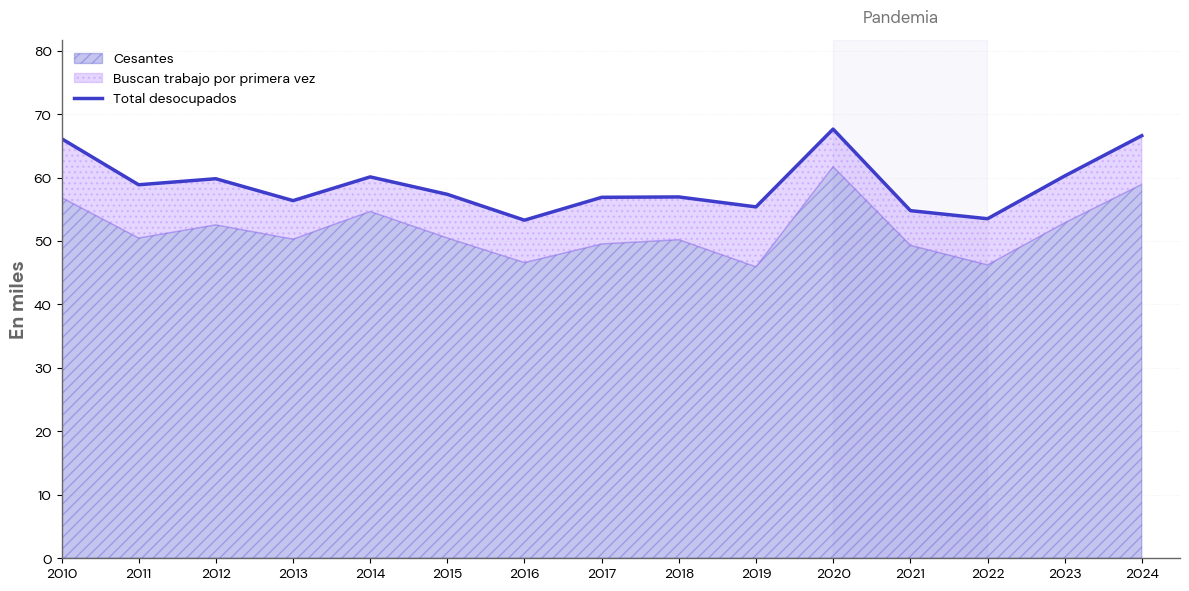

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path
from matplotlib.dates import date2num

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar solo la región del Biobío desde 2010 ────────────────────────────
df_bio = df[df["region_name"] == "Biobío"]
df_bio = df_bio[df_bio["Fecha"] >= "2010-01-01"]

# ─── Calcular promedios anuales ───────────────────────────────────────────────
df_bio['Año'] = df_bio['Fecha'].dt.year

promedios_anuales = df_bio.groupby('Año').agg({
    'PDO_TOT_indicadoresprincipales': 'mean',
    'PDO_CES_indicadoresprincipales': 'mean',
    'PDO_BTP1_indicadoresprincipales': 'mean'
}).reset_index()

# Crear fechas para el eje X (usando enero de cada año)
promedios_anuales['Fecha'] = pd.to_datetime(promedios_anuales['Año'].astype(str) + '-01-01')

# ─── Filtrar hasta el año 2024 ────────────────────────────────────────────────
promedios_hasta_2024 = promedios_anuales[promedios_anuales["Año"] <= 2024]

# ─── Crear gráfico ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))

# Sombreado leve para pandemia
ax.axvspan(
    date2num(pd.to_datetime("2020-01-01")),
    date2num(pd.to_datetime("2021-12-31")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# Áreas achuradas
ax.fill_between(promedios_hasta_2024['Fecha'],
                0,
                promedios_hasta_2024['PDO_CES_indicadoresprincipales'],
                color='#3E3CCA', alpha=0.3, hatch='///', label='Cesantes')

ax.fill_between(promedios_hasta_2024['Fecha'],
                promedios_hasta_2024['PDO_CES_indicadoresprincipales'],
                promedios_hasta_2024['PDO_TOT_indicadoresprincipales'],
                color='#AC78FF', alpha=0.3, hatch='...', label='Buscan trabajo por primera vez')

# Línea total
ax.plot(promedios_hasta_2024["Fecha"],
        promedios_hasta_2024["PDO_TOT_indicadoresprincipales"],
        label="Total desocupados", color="#3e3cca", linewidth=2.5, marker='o', markersize=0)

# Texto pandemia
ax.text(pd.to_datetime("2020-11-15"),
        ax.get_ylim()[1] * 1.18,
        "Pandemia",
        fontproperties=dm_font_props,
        fontsize=12,
        ha="center",
        va="bottom",
        color="#666666",
        alpha=0.9)

# Ejes
ax.set_ylabel("En miles", fontproperties=dm_font_bold, fontsize=14, color="#666666")
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Estética
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color("#666666")
ax.spines["bottom"].set_color("#666666")
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)
ax.set_ylim(bottom=0, top=ax.get_ylim()[1] * 1.15)

# Limitar eje X hasta 2024
ax.set_xlim(pd.to_datetime("2010-01-01"), pd.to_datetime("2024-06-30"))

# Leyenda
ax.legend(frameon=False, loc="upper left", fontsize=12, prop=dm_font_props)

# Fondo blanco
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()



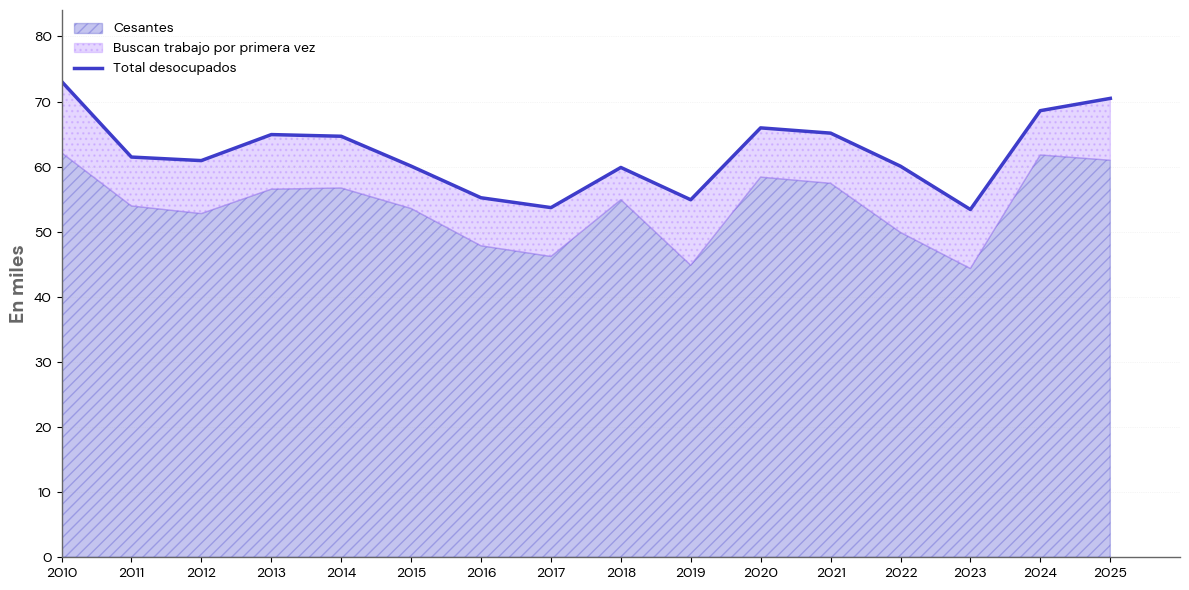

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path
from matplotlib.dates import date2num

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar solo la región del Biobío desde 2010 ────────────────────────────
df_bio = df[df["region_name"] == "Biobío"]
df_q1 = df_bio[
    (df_bio['Año'] >= 2010) &
    (df_bio['Año'] <= 2025) &
    (df_bio['Periodo'].str.contains("Q1"))
].copy()


# ─── Crear gráfico ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))

# Áreas achuradas
ax.fill_between(df_q1['Fecha'],
                0,
                df_q1['PDO_CES_indicadoresprincipales'],
                color='#3E3CCA', alpha=0.3, hatch='///', label='Cesantes')

ax.fill_between(df_q1['Fecha'],
                df_q1['PDO_CES_indicadoresprincipales'],
                df_q1['PDO_TOT_indicadoresprincipales'],
                color='#AC78FF', alpha=0.3, hatch='...', label='Buscan trabajo por primera vez')

# Línea total
ax.plot(df_q1["Fecha"],
        df_q1["PDO_TOT_indicadoresprincipales"],
        label="Total desocupados", color="#3e3cca", linewidth=2.5, marker='o', markersize=0)

# Eje Y
ax.set_ylabel("En miles", fontproperties=dm_font_bold, fontsize=14, color="#666666")

# Eje X
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

# Etiquetas con DM Sans
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Fondo: líneas horizontales
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

# Bordes y estilo
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color("#666666")
ax.spines["bottom"].set_color("#666666")
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

# Escala eje Y
ax.set_ylim(bottom=0, top=df_q1['PDO_TOT_indicadoresprincipales'].max() * 1.15)

# Escala eje X
ax.set_xlim(pd.to_datetime("2010-01-01"), pd.to_datetime("2025-12-31"))

# Leyenda
ax.legend(frameon=False, loc="upper left", fontsize=12, prop=dm_font_props)

# Fondo blanco
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()


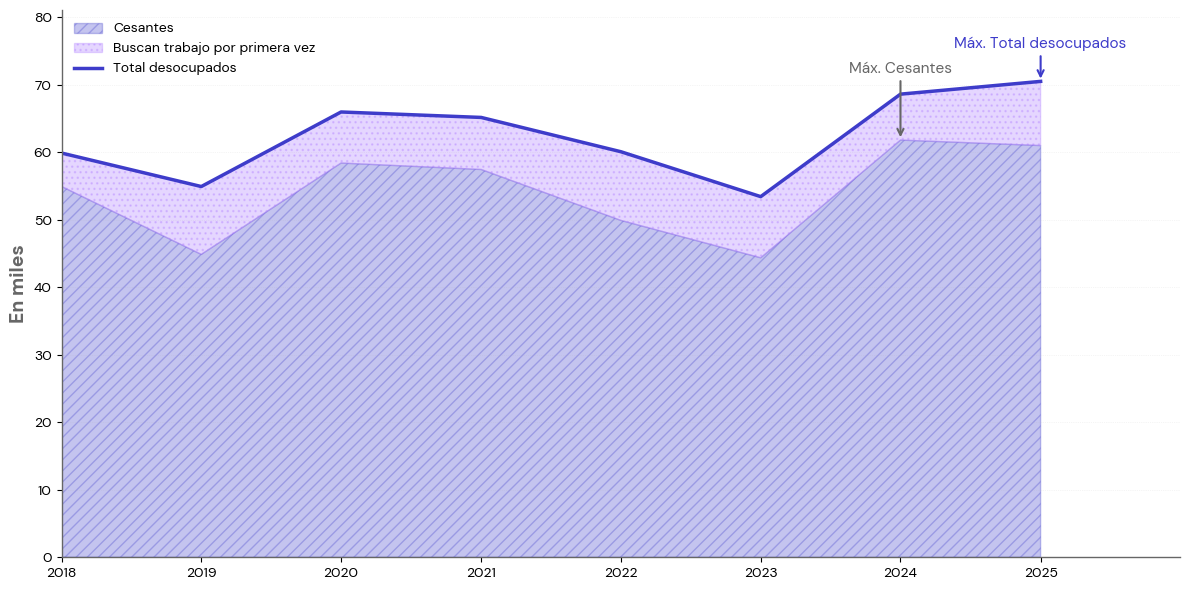

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path
from matplotlib.dates import date2num

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar solo la región del Biobío desde 2010 ────────────────────────────
df_bio = df[df["region_name"] == "Biobío"]
df_q1 = df_bio[
    (df_bio['Año'] >= 2018) &
    (df_bio['Año'] <= 2025) &
    (df_bio['Periodo'].str.contains("Q1"))
].copy()


# ─── Crear gráfico ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))

# Áreas achuradas
ax.fill_between(df_q1['Fecha'],
                0,
                df_q1['PDO_CES_indicadoresprincipales'],
                color='#3E3CCA', alpha=0.3, hatch='///', label='Cesantes')

ax.fill_between(df_q1['Fecha'],
                df_q1['PDO_CES_indicadoresprincipales'],
                df_q1['PDO_TOT_indicadoresprincipales'],
                color='#AC78FF', alpha=0.3, hatch='...', label='Buscan trabajo por primera vez')

# Línea total
ax.plot(df_q1["Fecha"],
        df_q1["PDO_TOT_indicadoresprincipales"],
        label="Total desocupados", color="#3e3cca", linewidth=2.5, marker='o', markersize=0)

# ─── Marcar máximos ────────────────────────────────────────────────────────────
# 1. Máximo total desocupados
max_total_idx = df_q1["PDO_TOT_indicadoresprincipales"].idxmax()
max_total_fecha = df_q1.loc[max_total_idx, "Fecha"]
max_total_valor = df_q1.loc[max_total_idx, "PDO_TOT_indicadoresprincipales"]

ax.annotate(
    "Máx. Total desocupados",
    xy=(max_total_fecha, max_total_valor),
    xytext=(max_total_fecha, max_total_valor + 5),
    textcoords="data",
    arrowprops=dict(arrowstyle="->", color="#3e3cca", lw=1.5),
    fontproperties=dm_font_props,
    fontsize=11,
    color="#3e3cca",
    ha="center"
)

# 2. Máximo cesantes
max_ces_idx = df_q1["PDO_CES_indicadoresprincipales"].idxmax()
max_ces_fecha = df_q1.loc[max_ces_idx, "Fecha"]
max_ces_valor = df_q1.loc[max_ces_idx, "PDO_CES_indicadoresprincipales"]

ax.annotate(
    "Máx. Cesantes",
    xy=(max_ces_fecha, max_ces_valor),
    xytext=(max_ces_fecha, max_ces_valor + 10),
    textcoords="data",
    arrowprops=dict(arrowstyle="->", color="#666666", lw=1.5),
    fontproperties=dm_font_props,
    fontsize=11,
    color="#666666",
    ha="center"
)

# Eje Y
ax.set_ylabel("En miles", fontproperties=dm_font_bold, fontsize=14, color="#666666")

# Eje X
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

# Etiquetas con DM Sans
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Fondo: líneas horizontales
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

# Bordes y estilo
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color("#666666")
ax.spines["bottom"].set_color("#666666")
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

# Escala eje Y
ax.set_ylim(bottom=0, top=df_q1['PDO_TOT_indicadoresprincipales'].max() * 1.15)

# Escala eje X
ax.set_xlim(pd.to_datetime("2018-01-01"), pd.to_datetime("2025-12-31"))

# Leyenda
ax.legend(frameon=False, loc="upper left", fontsize=12, prop=dm_font_props)

# Fondo blanco
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()


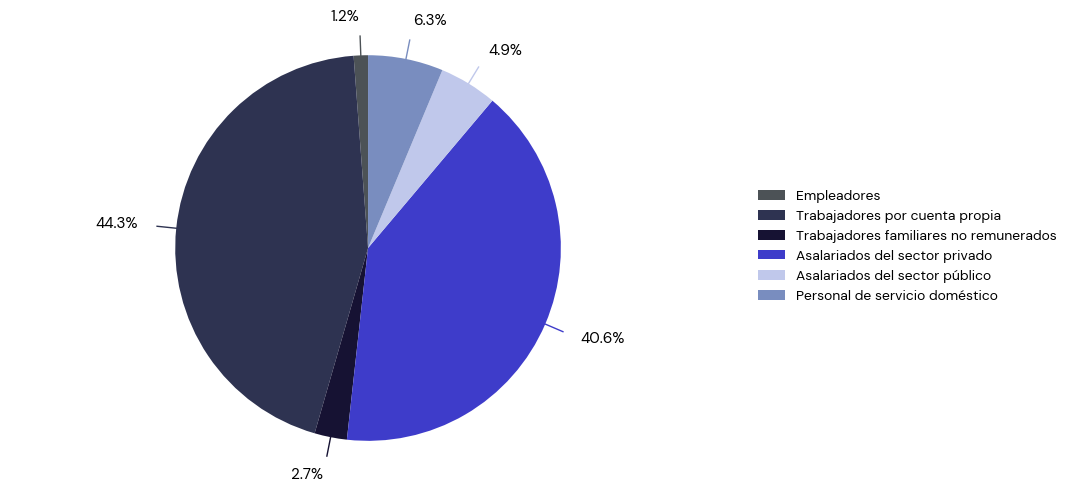

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.font_manager as fm
from pathlib import Path
import numpy as np

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar solo la región del Biobío y el primer trimestre de 2025 ─────────
df_bio = df[(df["region_name"] == "Biobío") & (df["Periodo"] == "2025Q1")]

# ─── Variables y etiquetas ────────────────────────────────────────────────────
variables = [
    "PO_I_EMP_informalidadcategoria",
    "PO_I_CP_informalidadcategoria",
    "PO_I_FNR_informalidadcategoria",
    "PO_I_PRV_informalidadcategoria",
    "PO_I_PUB_informalidadcategoria",
    "PO_I_PSD_informalidadcategoria"
]

etiquetas = [
    "Empleadores",
    "Trabajadores por cuenta propia",
    "Trabajadores familiares no remunerados",
    "Asalariados del sector privado",
    "Asalariados del sector público",
    "Personal de servicio doméstico"
]

valores = df_bio[variables].iloc[0].values
colores = ["#4c5256", "#2e3351", "#161233", "#3e3cca", "#c0c8eb", "#798dbf"]

# ─── Crear gráfico ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))

# Pie sin labels ni título
wedges, texts = ax.pie(valores, startangle=90, colors=colores, labels=['']*len(etiquetas), wedgeprops={'edgecolor': 'none', 'linewidth': 0})

# Porcentajes fuera de la torta, conectados con línea
porcentajes = 100 * valores / valores.sum()
for i, (p, w) in enumerate(zip(porcentajes, wedges)):
    ang = (w.theta2 + w.theta1) / 2.
    x = np.cos(np.deg2rad(ang))
    y = np.sin(np.deg2rad(ang))
    ha = 'left' if x > 0 else 'right'
    ax.text(x * 1.2, y * 1.2, f'{p:.1f}%', ha=ha, va='center', fontsize=11, fontproperties=dm_font_props)
    ax.plot([x * 0.9, x * 1.1], [y * 0.9, y * 1.1], color=colores[i], lw=1)

# Leyenda con color e identificación
from matplotlib.patches import Patch
leyenda = [Patch(facecolor=color, label=f'{etiqueta}')
           for etiqueta, valor, color in zip(etiquetas, valores, colores)]

ax.legend(handles=leyenda,
          loc='center left',
          bbox_to_anchor=(1.05, 0.5),
          frameon=False,
          prop=dm_font_props,
          fontsize=11)


# Ajuste general
plt.axis('equal')
plt.subplots_adjust(left=0.05, right=0.75)
plt.show()


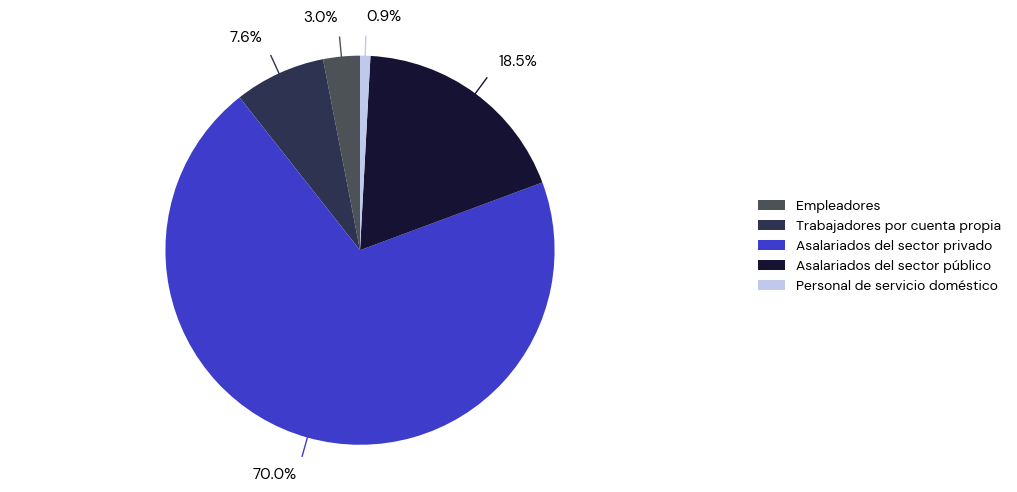

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.font_manager as fm
from pathlib import Path
import numpy as np

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar solo la región del Biobío y el primer trimestre de 2025 ─────────
df_bio = df[(df["region_name"] == "Biobío") & (df["Periodo"] == "2025Q1")]

# ─── Variables y etiquetas ────────────────────────────────────────────────────
variables = [
    "PO_F_EMP_informalidadcategoria",
    "PO_F_CP_informalidadcategoria",
    "PO_F_PRV_informalidadcategoria",
    "PO_F_PUB_informalidadcategoria",
    "PO_F_PSD_informalidadcategoria"
]

etiquetas = [
    "Empleadores",
    "Trabajadores por cuenta propia",
    "Asalariados del sector privado",
    "Asalariados del sector público",
    "Personal de servicio doméstico"
]

valores = df_bio[variables].iloc[0].values
colores = ["#4c5256", "#2e3351", "#3e3cca", "#161233", "#c0c8eb"]

# ─── Crear gráfico ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))

# Pie sin labels ni título
wedges, texts = ax.pie(valores, startangle=90, colors=colores, labels=['']*len(etiquetas), wedgeprops={'edgecolor': 'none', 'linewidth': 0})

# Porcentajes fuera de la torta, conectados con línea
porcentajes = 100 * valores / valores.sum()
for i, (p, w) in enumerate(zip(porcentajes, wedges)):
    ang = (w.theta2 + w.theta1) / 2.
    x = np.cos(np.deg2rad(ang))
    y = np.sin(np.deg2rad(ang))
    ha = 'left' if x > 0 else 'right'
    ax.text(x * 1.2, y * 1.2, f'{p:.1f}%', ha=ha, va='center', fontsize=11, fontproperties=dm_font_props)
    ax.plot([x * 0.9, x * 1.1], [y * 0.9, y * 1.1], color=colores[i], lw=1)

# Leyenda con color e identificación
from matplotlib.patches import Patch
leyenda = [Patch(facecolor=color, label=f'{etiqueta}')
           for etiqueta, valor, color in zip(etiquetas, valores, colores)]

ax.legend(handles=leyenda,
          loc='center left',
          bbox_to_anchor=(1.05, 0.5),
          frameon=False,
          prop=dm_font_props,
          fontsize=11)


# Ajuste general
plt.axis('equal')
plt.subplots_adjust(left=0.05, right=0.75)
plt.show()


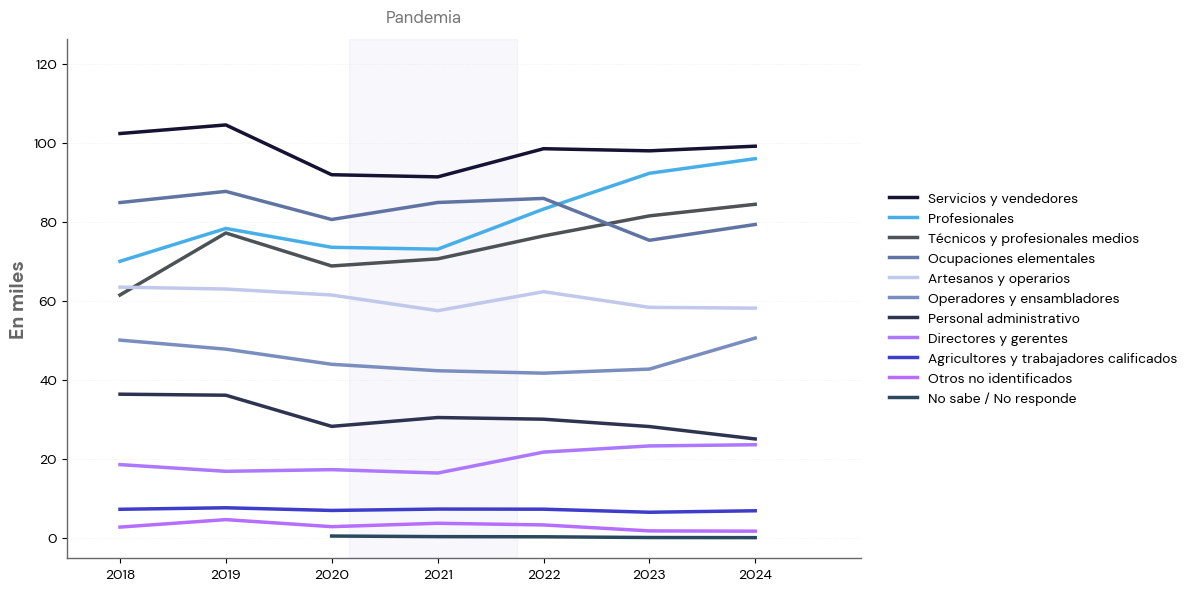

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path
from matplotlib.dates import date2num
from matplotlib.patches import Rectangle

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar solo la región del Biobío desde 2018 ────────────────────────────
df_bio = df[df["region_name"] == "Biobío"]
df_bio = df_bio[df_bio["Fecha"] >= "2018-01-01"]
df_bio['Año'] = df_bio['Fecha'].dt.year

# ─── Calcular promedios anuales ───────────────────────────────────────────────
columnas_y_nombres = [
    ("PO_F_DGA_informalidadgrupo", "Directores y gerentes"),
    ("PO_F_PRO_informalidadgrupo", "Profesionales"),
    ("PO_F_TEC_informalidadgrupo", "Técnicos y profesionales medios"),
    ("PO_F_ADM_informalidadgrupo", "Personal administrativo"),
    ("PO_F_SERV_informalidadgrupo", "Servicios y vendedores"),
    ("PO_F_AGRI_informalidadgrupo", "Agricultores y trabajadores calificados"),
    ("PO_F_ARTES_informalidadgrupo", "Artesanos y operarios"),
    ("PO_F_OPER_informalidadgrupo", "Operadores y ensambladores"),
    ("PO_F_ELEM_informalidadgrupo", "Ocupaciones elementales"),
    ("PO_F_OTR_informalidadgrupo", "Otros no identificados"),
    ("PO_F_UNDEF_informalidadgrupo", "No sabe / No responde")
]

colores = [
    "#ac78ff", "#48aee8", "#4c5256", "#2e3351", "#161233",
    "#3e3cca", "#c0c8eb", "#798dbf", "#6074a3", "#b56eff", "#2a495e"
]

columnas = [col for col, _ in columnas_y_nombres]

promedios_anuales = df_bio.groupby('Año')[columnas].mean().reset_index()
promedios_anuales['Fecha'] = pd.to_datetime(promedios_anuales['Año'].astype(str) + '-01-01')
promedios_anuales = promedios_anuales[promedios_anuales["Año"] <= 2024]


# ─── Crear gráfico ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))

# Sombreado pandemia
ax.axvspan(
    date2num(pd.to_datetime("2020-03-01")),
    date2num(pd.to_datetime("2021-10-01")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# Preparar datos para trazado ordenado
ultimos_valores = []
for (col, nombre), color in zip(columnas_y_nombres, colores):
    y_ultimo = promedios_anuales[col].iloc[-1]
    ultimos_valores.append((y_ultimo, col, nombre, color))

# Ordenar de mayor a menor según valor final
ultimos_valores.sort(reverse=True)

# Trazar líneas y recolectar handles para leyenda
handles = []
labels = []
for _, col, nombre, color in ultimos_valores:
    line, = ax.plot(promedios_anuales["Fecha"], promedios_anuales[col],
                    label=nombre, color=color, linewidth=2.5, marker=None)
    handles.append(line)
    labels.append(nombre)


# Texto "Pandemia" desplazado hacia arriba
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 1.18,
    "Pandemia",
    fontproperties=dm_font_props,
    fontsize=12,
    ha="center",
    va="bottom",
    color="#666666",
    alpha=0.9
)

# Leyenda externa ordenada
ax.legend(
    handles=handles,
    labels=labels,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    prop=dm_font_props,
    fontsize=11
)


# Ajustar el layout para dejar espacio a la derecha
plt.tight_layout(rect=[0, 0, 0.85, 1])


# Ejes y estilos
ax.set_ylabel("En miles", fontproperties=dm_font_bold, fontsize=14, color="#666666")
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color("#666666")
ax.spines["bottom"].set_color("#666666")
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

ax.set_ylim(bottom=ax.get_ylim()[0], top=ax.get_ylim()[1] * 1.15)
ax.set_xlim(pd.to_datetime("2017-07-01"), pd.to_datetime("2024-12-31"))

fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()


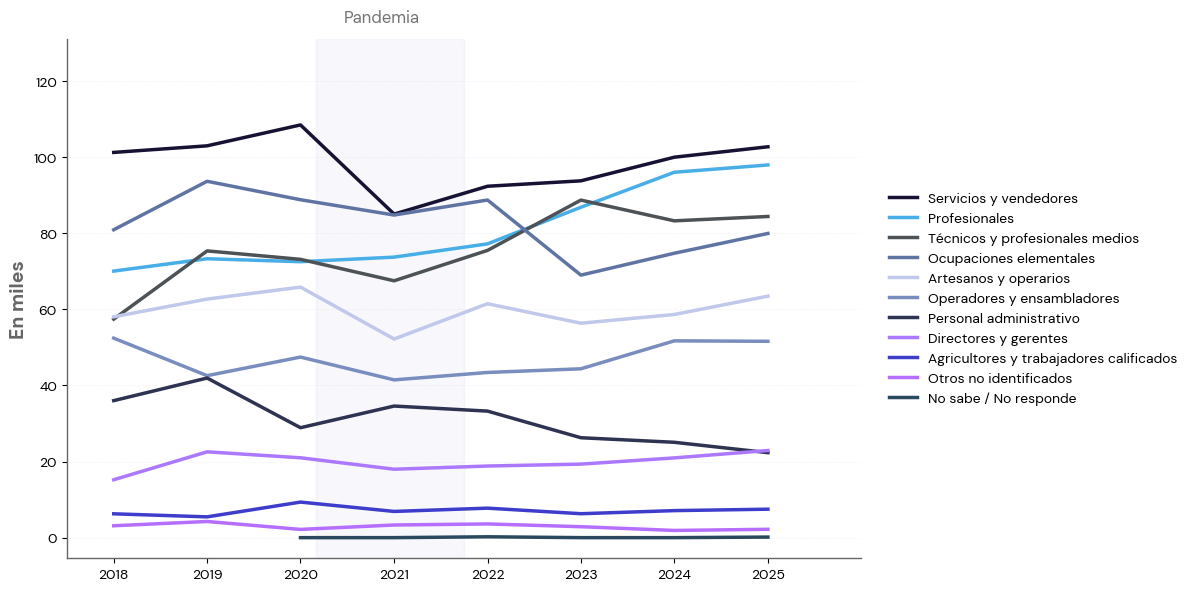

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path
from matplotlib.dates import date2num
from matplotlib.patches import Rectangle

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar solo la región del Biobío desde 2018 ────────────────────────────
df_bio = df[df["region_name"] == "Biobío"]
df_bio = df_bio[df_bio["Fecha"] >= "2018-01-01"]
df_bio['Año'] = df_bio['Fecha'].dt.year
df_bio = df_bio[df_bio["Trimestre"] == "Ene - Mar"]
df_bio = df_bio[df_bio["Año"] <= 2025]

# ─── Calcular promedios anuales ───────────────────────────────────────────────
columnas_y_nombres = [
    ("PO_F_DGA_informalidadgrupo", "Directores y gerentes"),
    ("PO_F_PRO_informalidadgrupo", "Profesionales"),
    ("PO_F_TEC_informalidadgrupo", "Técnicos y profesionales medios"),
    ("PO_F_ADM_informalidadgrupo", "Personal administrativo"),
    ("PO_F_SERV_informalidadgrupo", "Servicios y vendedores"),
    ("PO_F_AGRI_informalidadgrupo", "Agricultores y trabajadores calificados"),
    ("PO_F_ARTES_informalidadgrupo", "Artesanos y operarios"),
    ("PO_F_OPER_informalidadgrupo", "Operadores y ensambladores"),
    ("PO_F_ELEM_informalidadgrupo", "Ocupaciones elementales"),
    ("PO_F_OTR_informalidadgrupo", "Otros no identificados"),
    ("PO_F_UNDEF_informalidadgrupo", "No sabe / No responde")
]

colores = [
    "#ac78ff", "#48aee8", "#4c5256", "#2e3351", "#161233",
    "#3e3cca", "#c0c8eb", "#798dbf", "#6074a3", "#b56eff", "#2a495e"
]

columnas = [col for col, _ in columnas_y_nombres]

promedios_q1 = df_bio.copy()
promedios_q1['Fecha'] = pd.to_datetime(promedios_q1['Año'].astype(str) + '-01-01')


# ─── Crear gráfico ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))

# Sombreado pandemia
ax.axvspan(
    date2num(pd.to_datetime("2020-03-01")),
    date2num(pd.to_datetime("2021-10-01")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# Preparar datos para trazado ordenado
ultimos_valores = []
for (col, nombre), color in zip(columnas_y_nombres, colores):
    y_ultimo = promedios_anuales[col].iloc[-1]
    ultimos_valores.append((y_ultimo, col, nombre, color))

# Ordenar de mayor a menor según valor final
ultimos_valores.sort(reverse=True)

# Trazar líneas y recolectar handles para leyenda
handles = []
labels = []
for _, col, nombre, color in ultimos_valores:
    line, = ax.plot(promedios_q1["Fecha"], promedios_q1[col],
                    label=nombre, color=color, linewidth=2.5, marker=None)
    handles.append(line)
    labels.append(nombre)


# Texto "Pandemia" desplazado hacia arriba
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 1.18,
    "Pandemia",
    fontproperties=dm_font_props,
    fontsize=12,
    ha="center",
    va="bottom",
    color="#666666",
    alpha=0.9
)

# Leyenda externa ordenada
ax.legend(
    handles=handles,
    labels=labels,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    prop=dm_font_props,
    fontsize=11
)


# Ajustar el layout para dejar espacio a la derecha
plt.tight_layout(rect=[0, 0, 0.85, 1])


# Ejes y estilos
ax.set_ylabel("En miles", fontproperties=dm_font_bold, fontsize=14, color="#666666")
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color("#666666")
ax.spines["bottom"].set_color("#666666")
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

ax.set_ylim(bottom=ax.get_ylim()[0], top=ax.get_ylim()[1] * 1.15)
ax.set_xlim(pd.to_datetime("2017-07-01"), pd.to_datetime("2025-12-31"))

fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()


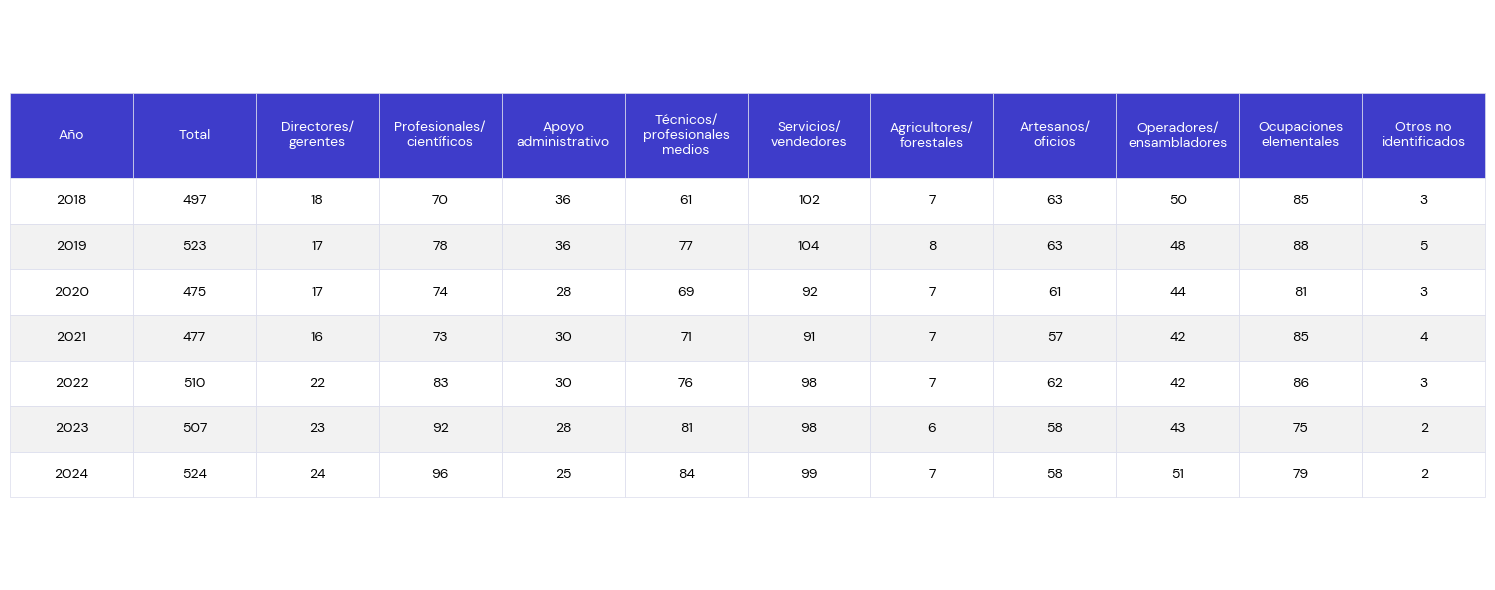

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path

# ─── 1. Fuente personalizada (opcional) ───────────────────────────────────────
font_path = "/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf"
if Path(font_path).exists():
    fm.fontManager.addfont(font_path)
    dm_font = fm.FontProperties(fname=font_path)
else:
    dm_font = fm.FontProperties()

# ─── 2. Cargar y preparar datos ───────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")

# Filtrar por región Biobío
df_bio = df[df["region_name"] == "Biobío"].copy()

# Verificar trimestres y ordenar
orden_trimestres = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}
df_bio["orden"] = df_bio["Trimestre"].map(orden_trimestres)
df_bio = df_bio.sort_values(["Año", "orden"]).drop(columns="orden")

# ─── 3. Mapeo de columnas ─────────────────────────────────────────────────────
column_map = {
    "PO_F_TOT_informalidadgrupo": "Total",
    "PO_F_DGA_informalidadgrupo": "Directores/\ngerentes",
    "PO_F_PRO_informalidadgrupo": "Profesionales/\ncientíficos",
    "PO_F_ADM_informalidadgrupo": "Apoyo\nadministrativo",
    "PO_F_TEC_informalidadgrupo": "Técnicos/\nprofesionales\nmedios",
    "PO_F_SERV_informalidadgrupo": "Servicios/\nvendedores",
    "PO_F_AGRI_informalidadgrupo": "Agricultores/\nforestales",
    "PO_F_ARTES_informalidadgrupo": "Artesanos/\noficios",
    "PO_F_OPER_informalidadgrupo": "Operadores/\nensambladores",
    "PO_F_ELEM_informalidadgrupo": "Ocupaciones\nelementales",
    "PO_F_OTR_informalidadgrupo": "Otros no\nidentificados",
}


variables = list(column_map.values())
column_keys = list(column_map.keys())

# ─── 4. Verificar que las columnas tengan datos ──────────────────────────────
for key in column_keys:
    non_null_count = df_bio[key].notna().sum()
    total_count = len(df_bio)

# ─── 5. Datos anuales completos ───────────────────────────────────────────────
# Crear subset con columnas necesarias
subset_cols = ["Año"] + column_keys
df_subset = df_bio[subset_cols].copy()

# Agrupación anual
df_anual_full = df_subset.groupby("Año").mean(numeric_only=True).reset_index()
df_anual_full = df_anual_full.rename(columns=column_map)

# ─── 6. Tabla 1: Promedios anuales desde 2018 ─────────────────────────────────
df_anual = df_anual_full[(df_anual_full["Año"] >= 2018) & (df_anual_full["Año"] <= 2024)].copy()
df_anual["Año"] = df_anual["Año"].astype(int).astype(str)
for var in variables:
    if var in df_anual.columns:
        df_anual[var] = df_anual[var].fillna(0).round().astype(int).astype(str)

# ─── 8. Función para mostrar tablas ───────────────────────────────────────────
def mostrar_tabla(df, title=""):
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.axis("off")

    df_display = df.copy()
    for col in df_display.columns:
        if col not in ["Año"]:
            if df_display[col].dtype in ['float64', 'int64', 'float32', 'int32']:
                df_display[col] = df_display[col].apply(lambda x: f"{int(x)}" if pd.notna(x) else "")

    tabla = ax.table(
        cellText=[df_display.columns.tolist()] + df_display.astype(str).values.tolist(),
        cellLoc='center',
        loc='center'
    )
    tabla.auto_set_font_size(False)
    tabla.set_fontsize(11)
    tabla.scale(1.2, 2.0)

    for (row, col), cell in tabla.get_celld().items():
        if row == 0:
            cell.set_facecolor("#3E3CCA")
            cell.set_text_props(color='white', weight='bold', fontproperties=dm_font)
            cell.set_height(0.15)
        else:
            cell.set_facecolor("white" if row % 2 else "#f2f2f2")
            cell.set_text_props(fontproperties=dm_font)
            cell.set_height(0.08)
        cell.set_edgecolor("#DADCEC")
        cell.set_linewidth(0.5)
        cell.set_width(0.12)

    if title:
        plt.title(title, fontsize=14, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()

# ─── 9. Mostrar tabla anual ─────────────────────────────────────────────────
mostrar_tabla(df_anual)


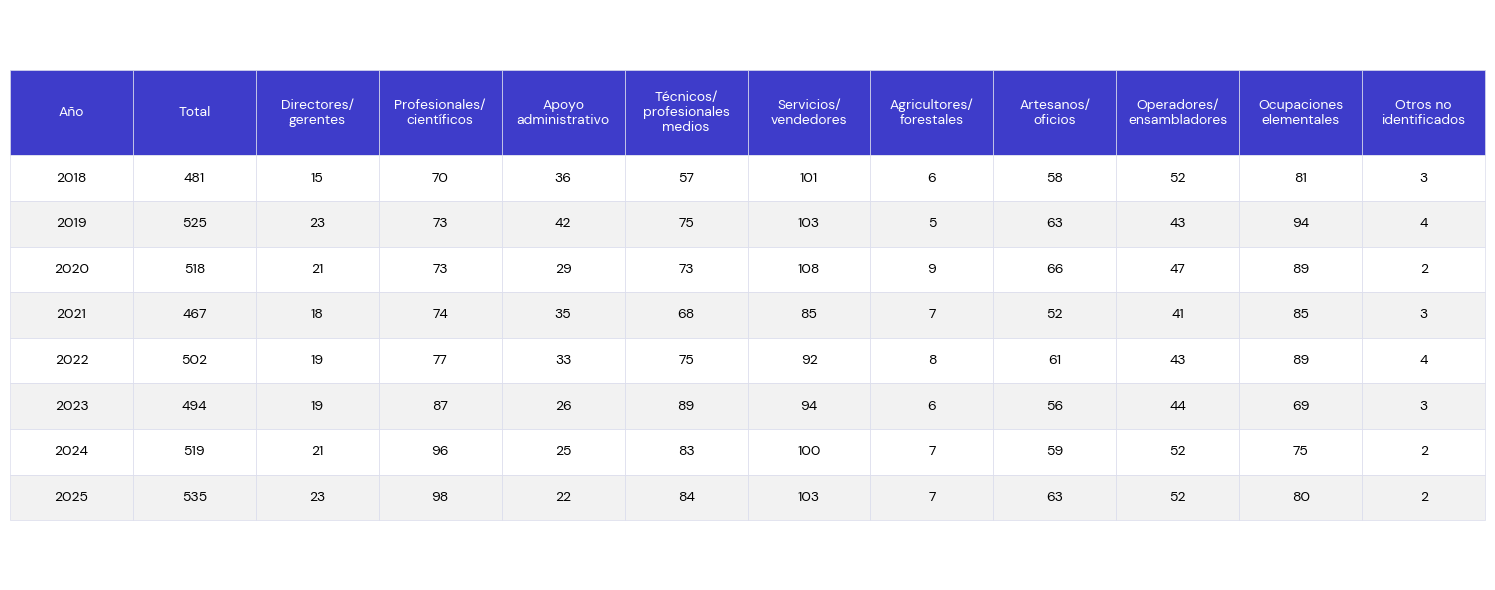

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path

# ─── 1. Fuente personalizada (opcional) ───────────────────────────────────────
font_path = "/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf"
if Path(font_path).exists():
    fm.fontManager.addfont(font_path)
    dm_font = fm.FontProperties(fname=font_path)
else:
    dm_font = fm.FontProperties()

# ─── 2. Cargar y preparar datos ───────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")

# Filtrar por región Biobío
df_bio = df[df["region_name"] == "Biobío"].copy()

# Verificar trimestres y ordenar
orden_trimestres = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}
df_bio["orden"] = df_bio["Trimestre"].map(orden_trimestres)
df_bio = df_bio.sort_values(["Año", "orden"]).drop(columns="orden")

# ─── 3. Mapeo de columnas ─────────────────────────────────────────────────────
column_map = {
    "PO_F_TOT_informalidadgrupo": "Total",
    "PO_F_DGA_informalidadgrupo": "Directores/\ngerentes",
    "PO_F_PRO_informalidadgrupo": "Profesionales/\ncientíficos",
    "PO_F_ADM_informalidadgrupo": "Apoyo\nadministrativo",
    "PO_F_TEC_informalidadgrupo": "Técnicos/\nprofesionales\nmedios",
    "PO_F_SERV_informalidadgrupo": "Servicios/\nvendedores",
    "PO_F_AGRI_informalidadgrupo": "Agricultores/\nforestales",
    "PO_F_ARTES_informalidadgrupo": "Artesanos/\noficios",
    "PO_F_OPER_informalidadgrupo": "Operadores/\nensambladores",
    "PO_F_ELEM_informalidadgrupo": "Ocupaciones\nelementales",
    "PO_F_OTR_informalidadgrupo": "Otros no\nidentificados",
}


variables = list(column_map.values())
column_keys = list(column_map.keys())

# ─── 4. Verificar que las columnas tengan datos ──────────────────────────────
for key in column_keys:
    non_null_count = df_bio[key].notna().sum()
    total_count = len(df_bio)

# ─── 5. Filtrar solo Q1 de cada año entre 2018 y 2025 ─────────────────────────
df_q1 = df_bio[
    (df_bio["Trimestre"] == "Ene - Mar") &
    (df_bio["Año"].between(2018, 2025))
].copy()

# ─── 6. Seleccionar y renombrar columnas ──────────────────────────────────────
subset_cols = ["Año"] + column_keys
df_q1 = df_q1[subset_cols].copy()
df_q1 = df_q1.rename(columns=column_map)

# Redondear y formatear valores como enteros para mostrar
df_q1["Año"] = df_q1["Año"].astype(int).astype(str)
for var in variables:
    if var in df_q1.columns:
        df_q1[var] = df_q1[var].fillna(0).round().astype(int).astype(str)

# ─── 8. Función para mostrar tablas ───────────────────────────────────────────
def mostrar_tabla(df, title=""):
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.axis("off")

    df_display = df.copy()
    for col in df_display.columns:
        if col not in ["Año"]:
            if df_display[col].dtype in ['float64', 'int64', 'float32', 'int32']:
                df_display[col] = df_display[col].apply(lambda x: f"{int(x)}" if pd.notna(x) else "")

    tabla = ax.table(
        cellText=[df_display.columns.tolist()] + df_display.astype(str).values.tolist(),
        cellLoc='center',
        loc='center'
    )
    tabla.auto_set_font_size(False)
    tabla.set_fontsize(11)
    tabla.scale(1.2, 2.0)

    for (row, col), cell in tabla.get_celld().items():
        if row == 0:
            cell.set_facecolor("#3E3CCA")
            cell.set_text_props(color='white', weight='bold', fontproperties=dm_font)
            cell.set_height(0.15)
        else:
            cell.set_facecolor("white" if row % 2 else "#f2f2f2")
            cell.set_text_props(fontproperties=dm_font)
            cell.set_height(0.08)
        cell.set_edgecolor("#DADCEC")
        cell.set_linewidth(0.5)
        cell.set_width(0.12)

    if title:
        plt.title(title, fontsize=14, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()

# ─── 9. Mostrar tabla anual ─────────────────────────────────────────────────
mostrar_tabla(df_q1)


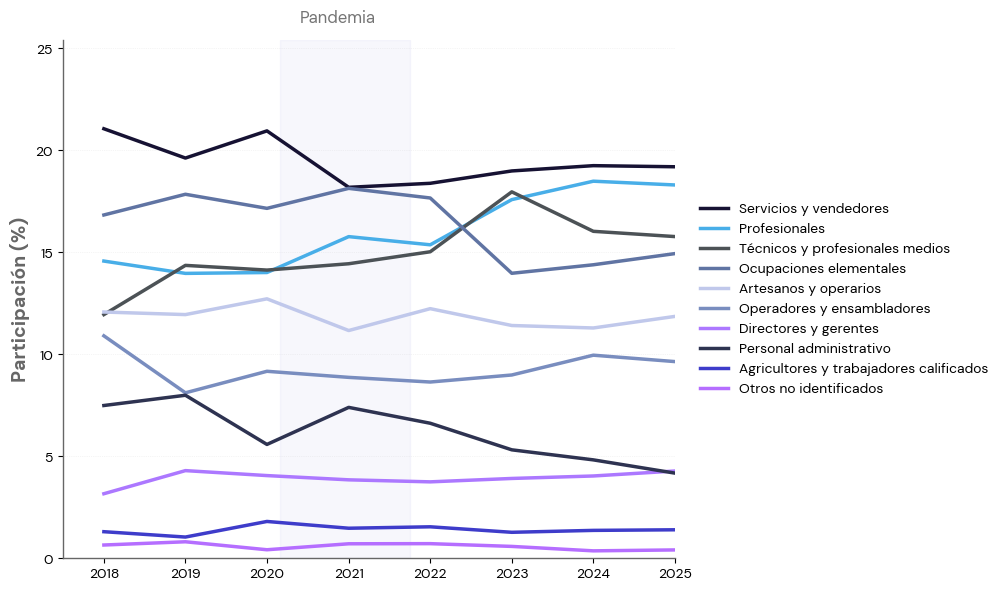

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path
from matplotlib.dates import date2num

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

# Usar fuente encontrada o una por defecto
if found_fonts:
    dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
else:
    dm_font_name = "DejaVu Sans"

dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar Biobío desde 2018 y solo Q1 ───────────────────────────────────────
df_bio = df[df["region_name"] == "Biobío"].copy()
df_bio = df_bio[df_bio["Fecha"] >= "2018-01-01"]
df_bio = df_bio[df_bio["Trimestre"] == "Ene - Mar"].copy()
df_bio["Año"] = df_bio["Fecha"].dt.year
df_bio["Fecha"] = pd.to_datetime(df_bio["Año"].astype(str) + "-01-01")

# ─── Calcular participación porcentual ────────────────────────────────────────
cols_informalidad = [
    'PO_F_DGA_informalidadgrupo',
    'PO_F_PRO_informalidadgrupo',
    'PO_F_ADM_informalidadgrupo',
    'PO_F_TEC_informalidadgrupo',
    'PO_F_SERV_informalidadgrupo',
    'PO_F_AGRI_informalidadgrupo',
    'PO_F_ARTES_informalidadgrupo',
    'PO_F_OPER_informalidadgrupo',
    'PO_F_ELEM_informalidadgrupo',
    'PO_F_OTR_informalidadgrupo'
]
col_total = 'PO_F_TOT_informalidadgrupo'
cols = [col_total] + cols_informalidad

for col in cols_informalidad:
    df_bio[col + '_pct'] = (df_bio[col] / df_bio[col_total]) * 100

# ─── Configurar nombres y colores ─────────────────────────────────────────────
columnas_y_nombres = [
    ("PO_F_DGA_informalidadgrupo_pct", "Directores y gerentes"),
    ("PO_F_PRO_informalidadgrupo_pct", "Profesionales"),
    ("PO_F_TEC_informalidadgrupo_pct", "Técnicos y profesionales medios"),
    ("PO_F_ADM_informalidadgrupo_pct", "Personal administrativo"),
    ("PO_F_SERV_informalidadgrupo_pct", "Servicios y vendedores"),
    ("PO_F_AGRI_informalidadgrupo_pct", "Agricultores y trabajadores calificados"),
    ("PO_F_ARTES_informalidadgrupo_pct", "Artesanos y operarios"),
    ("PO_F_OPER_informalidadgrupo_pct", "Operadores y ensambladores"),
    ("PO_F_ELEM_informalidadgrupo_pct", "Ocupaciones elementales"),
    ("PO_F_OTR_informalidadgrupo_pct", "Otros no identificados")
]

colores = [
    "#ac78ff", "#48aee8", "#4c5256", "#2e3351", "#161233",
    "#3e3cca", "#c0c8eb", "#798dbf", "#6074a3", "#b56eff"
]

# ─── Crear gráfico ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))

# Sombreado pandemia
ax.axvspan(
    date2num(pd.to_datetime("2020-03-01")),
    date2num(pd.to_datetime("2021-10-01")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# Ordenar por último valor
ultimos_valores = []
for (col, nombre), color in zip(columnas_y_nombres, colores):
    y_ultimo = df_bio[col].iloc[-1]
    ultimos_valores.append((y_ultimo, col, nombre, color))
ultimos_valores.sort(reverse=True)

# Trazar líneas
handles, labels = [], []
for _, col, nombre, color in ultimos_valores:
    line, = ax.plot(df_bio["Fecha"], df_bio[col],
                    label=nombre, color=color, linewidth=2.5)
    handles.append(line)
    labels.append(nombre)

# Etiqueta "Pandemia"
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 1.18,
    "Pandemia",
    fontproperties=dm_font_props,
    fontsize=12,
    ha="center",
    va="bottom",
    color="#666666",
    alpha=0.9
)

# Leyenda ordenada
ax.legend(
    handles=handles,
    labels=labels,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    prop=dm_font_props,
    fontsize=11
)

# Ejes y estilo
ax.set_ylabel("Participación (%)", fontproperties=dm_font_bold, fontsize=14, color="#666666")
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color("#666666")
ax.spines["bottom"].set_color("#666666")
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

ax.set_ylim(bottom=0, top=ax.get_ylim()[1] * 1.15)
ax.set_xlim(pd.to_datetime("2017-07-01"), df_bio["Fecha"].max())

fig.patch.set_facecolor('white')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


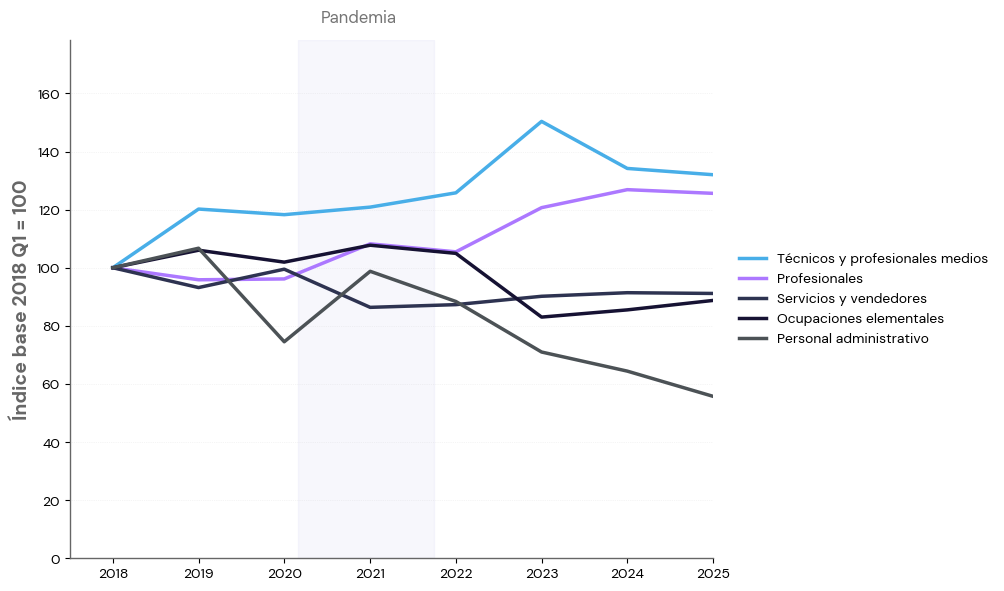

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path
from matplotlib.dates import date2num

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

# Usar fuente encontrada o una por defecto
if found_fonts:
    dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
else:
    dm_font_name = "DejaVu Sans"

dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar Biobío desde 2018 y solo Q1 ───────────────────────────────────────
df_bio = df[df["region_name"] == "Biobío"].copy()
df_bio = df_bio[df_bio["Fecha"] >= "2018-01-01"]
df_bio = df_bio[df_bio["Trimestre"] == "Ene - Mar"].copy()
df_bio["Año"] = df_bio["Fecha"].dt.year
df_bio["Fecha"] = pd.to_datetime(df_bio["Año"].astype(str) + "-01-01")

# ─── Calcular participación porcentual e indexar a 2018 Q1 = 100 ──────────────
cols_informalidad = [
    'PO_F_DGA_informalidadgrupo',
    'PO_F_PRO_informalidadgrupo',
    'PO_F_ADM_informalidadgrupo',
    'PO_F_TEC_informalidadgrupo',
    'PO_F_SERV_informalidadgrupo',
    'PO_F_AGRI_informalidadgrupo',
    'PO_F_ARTES_informalidadgrupo',
    'PO_F_OPER_informalidadgrupo',
    'PO_F_ELEM_informalidadgrupo',
    'PO_F_OTR_informalidadgrupo'
]
col_total = 'PO_F_TOT_informalidadgrupo'

# Calcular % participación
for col in cols_informalidad:
    df_bio[col + '_pct'] = (df_bio[col] / df_bio[col_total]) * 100

# Indexar al valor de 2018 Q1
base_2018 = df_bio[df_bio["Año"] == 2018].iloc[0]
for col in cols_informalidad:
    pct_col = col + '_pct'
    base_val = base_2018[pct_col]
    df_bio[pct_col + '_idx'] = (df_bio[pct_col] / base_val) * 100

# ─── Configurar nombres y colores ─────────────────────────────────────────────
columnas_y_nombres = [
    ("PO_F_PRO_informalidadgrupo_pct_idx", "Profesionales"),
    ("PO_F_TEC_informalidadgrupo_pct_idx", "Técnicos y profesionales medios"),
    ("PO_F_ADM_informalidadgrupo_pct_idx", "Personal administrativo"),
    ("PO_F_SERV_informalidadgrupo_pct_idx", "Servicios y vendedores"),
    ("PO_F_ELEM_informalidadgrupo_pct_idx", "Ocupaciones elementales"),
]

colores = [
    "#ac78ff", "#48aee8", "#4c5256", "#2e3351", "#161233",
    "#3e3cca", "#c0c8eb", "#798dbf", "#6074a3", "#b56eff"
]

# ─── Crear gráfico ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))

# Sombreado pandemia
ax.axvspan(
    date2num(pd.to_datetime("2020-03-01")),
    date2num(pd.to_datetime("2021-10-01")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# Ordenar por último valor
ultimos_valores = []
for (col, nombre), color in zip(columnas_y_nombres, colores):
    y_ultimo = df_bio[col].iloc[-1]
    ultimos_valores.append((y_ultimo, col, nombre, color))
ultimos_valores.sort(reverse=True)

# Trazar líneas
handles, labels = [], []
for _, col, nombre, color in ultimos_valores:
    line, = ax.plot(df_bio["Fecha"], df_bio[col],
                    label=nombre, color=color, linewidth=2.5)
    handles.append(line)
    labels.append(nombre)

# Etiqueta "Pandemia"
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 1.18,
    "Pandemia",
    fontproperties=dm_font_props,
    fontsize=12,
    ha="center",
    va="bottom",
    color="#666666",
    alpha=0.9
)

# Leyenda ordenada
ax.legend(
    handles=handles,
    labels=labels,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    prop=dm_font_props,
    fontsize=11
)

# Ejes y estilo
ax.set_ylabel("Índice base 2018 Q1 = 100", fontproperties=dm_font_bold, fontsize=14, color="#666666")
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color("#666666")
ax.spines["bottom"].set_color("#666666")
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

ax.set_ylim(bottom=0, top=ax.get_ylim()[1] * 1.15)
ax.set_xlim(pd.to_datetime("2017-07-01"), df_bio["Fecha"].max())

fig.patch.set_facecolor('white')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


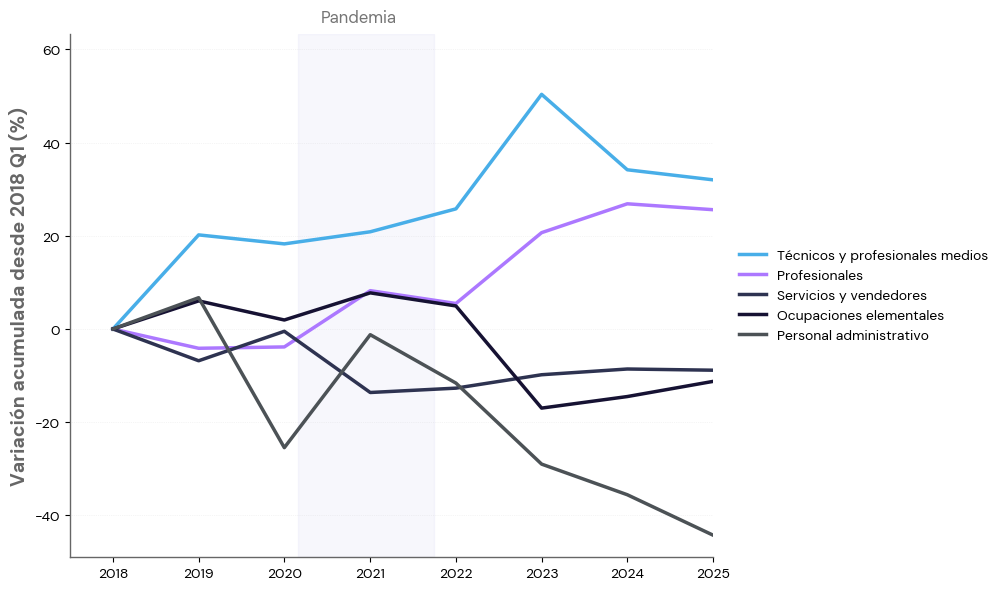

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path
from matplotlib.dates import date2num

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

# Usar fuente encontrada o una por defecto
if found_fonts:
    dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
else:
    dm_font_name = "DejaVu Sans"

dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar Biobío desde 2018 y solo Q1 ───────────────────────────────────────
df_bio = df[df["region_name"] == "Biobío"].copy()
df_bio = df_bio[df_bio["Fecha"] >= "2018-01-01"]
df_bio = df_bio[df_bio["Trimestre"] == "Ene - Mar"].copy()
df_bio["Año"] = df_bio["Fecha"].dt.year
df_bio["Fecha"] = pd.to_datetime(df_bio["Año"].astype(str) + "-01-01")

# ─── Calcular participación porcentual y variación % desde 2018 ───────────────
cols_informalidad = [
    'PO_F_DGA_informalidadgrupo',
    'PO_F_PRO_informalidadgrupo',
    'PO_F_ADM_informalidadgrupo',
    'PO_F_TEC_informalidadgrupo',
    'PO_F_SERV_informalidadgrupo',
    'PO_F_AGRI_informalidadgrupo',
    'PO_F_ARTES_informalidadgrupo',
    'PO_F_OPER_informalidadgrupo',
    'PO_F_ELEM_informalidadgrupo',
    'PO_F_OTR_informalidadgrupo'
]
col_total = 'PO_F_TOT_informalidadgrupo'

# Calcular % participación
for col in cols_informalidad:
    df_bio[col + '_pct'] = (df_bio[col] / df_bio[col_total]) * 100

# Calcular % cambio acumulado respecto a 2018 Q1
base_2018 = df_bio[df_bio["Año"] == 2018].iloc[0]
for col in cols_informalidad:
    pct_col = col + '_pct'
    base_val = base_2018[pct_col]
    df_bio[pct_col + '_chg'] = ((df_bio[pct_col] - base_val) / base_val) * 100

# ─── Configurar nombres y colores ─────────────────────────────────────────────
columnas_y_nombres = [
    ("PO_F_PRO_informalidadgrupo_pct_chg", "Profesionales"),
    ("PO_F_TEC_informalidadgrupo_pct_chg", "Técnicos y profesionales medios"),
    ("PO_F_ADM_informalidadgrupo_pct_chg", "Personal administrativo"),
    ("PO_F_SERV_informalidadgrupo_pct_chg", "Servicios y vendedores"),
    ("PO_F_ELEM_informalidadgrupo_pct_chg", "Ocupaciones elementales"),
]

colores = [
    "#ac78ff", "#48aee8", "#4c5256", "#2e3351", "#161233"
]

# ─── Crear gráfico ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))

# Sombreado pandemia
ax.axvspan(
    date2num(pd.to_datetime("2020-03-01")),
    date2num(pd.to_datetime("2021-10-01")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# Ordenar por último valor
ultimos_valores = []
for (col, nombre), color in zip(columnas_y_nombres, colores):
    y_ultimo = df_bio[col].iloc[-1]
    ultimos_valores.append((y_ultimo, col, nombre, color))
ultimos_valores.sort(reverse=True)

# Trazar líneas
handles, labels = [], []
for _, col, nombre, color in ultimos_valores:
    line, = ax.plot(df_bio["Fecha"], df_bio[col],
                    label=nombre, color=color, linewidth=2.5)
    handles.append(line)
    labels.append(nombre)

# Etiqueta "Pandemia"
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 1.18,
    "Pandemia",
    fontproperties=dm_font_props,
    fontsize=12,
    ha="center",
    va="bottom",
    color="#666666",
    alpha=0.9
)

# Leyenda ordenada
ax.legend(
    handles=handles,
    labels=labels,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    prop=dm_font_props,
    fontsize=11
)

# Ejes y estilo
ax.set_ylabel("Variación acumulada desde 2018 Q1 (%)", fontproperties=dm_font_bold, fontsize=14, color="#666666")
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color("#666666")
ax.spines["bottom"].set_color("#666666")
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

ax.set_ylim(bottom=None, top=ax.get_ylim()[1] * 1.15)
ax.set_xlim(pd.to_datetime("2017-07-01"), df_bio["Fecha"].max())

fig.patch.set_facecolor('white')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


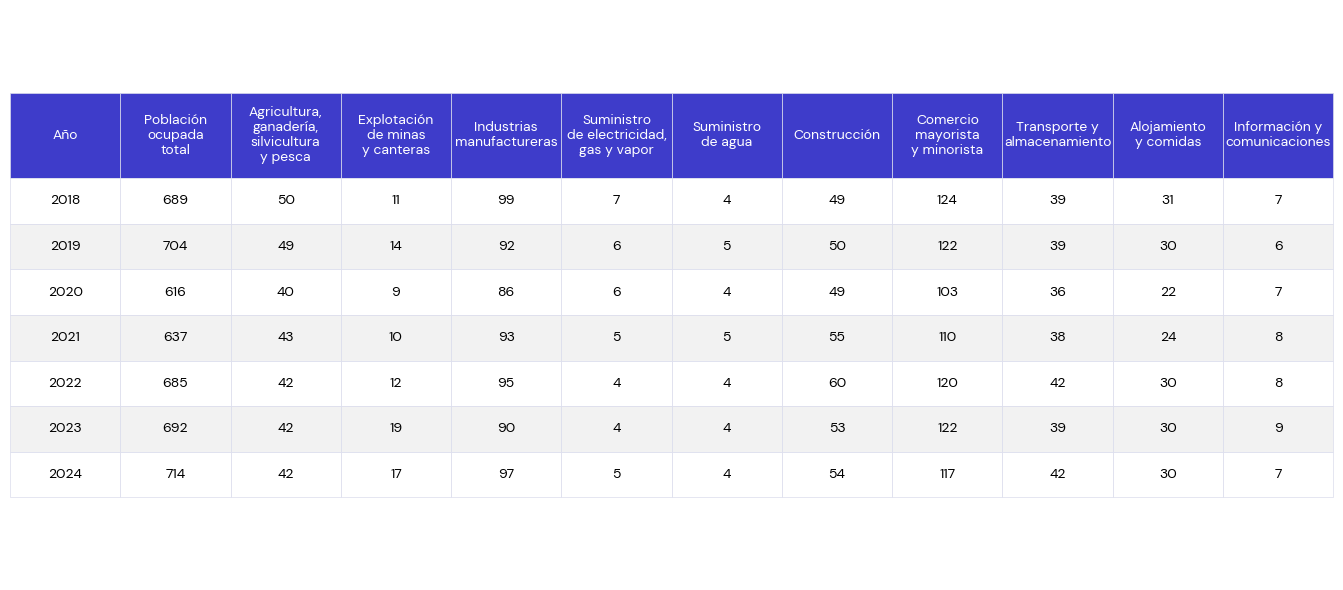

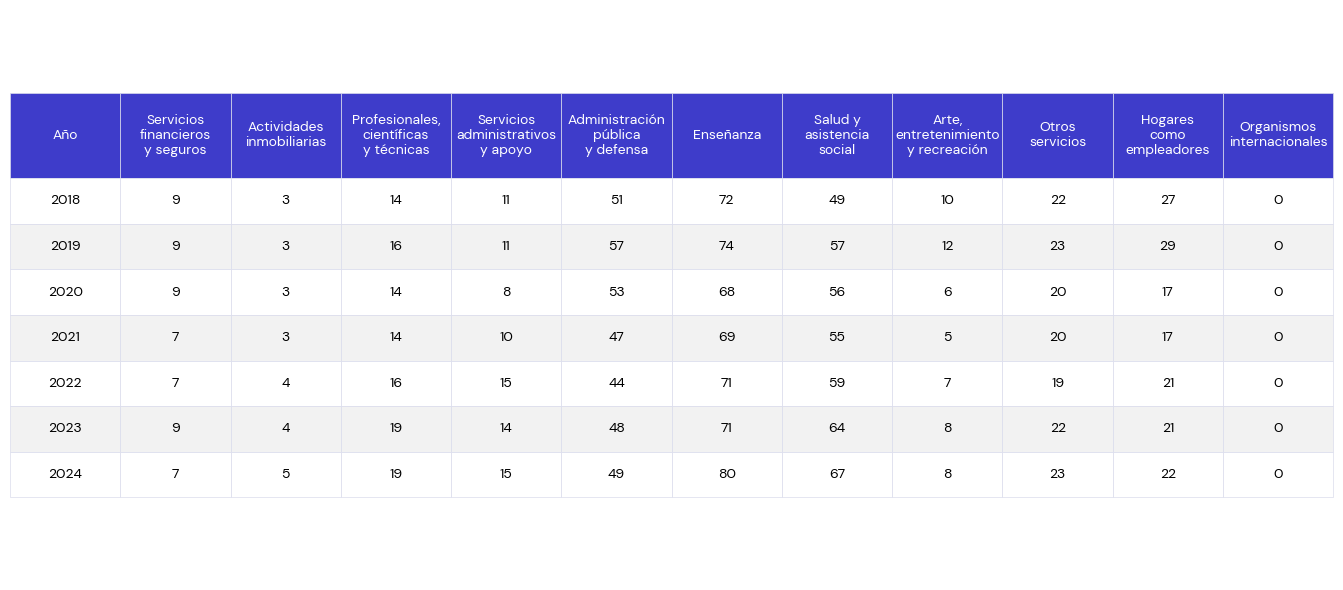

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path

# ─── 1. Fuente personalizada (opcional) ───────────────────────────────────────
font_path = "/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf"
if Path(font_path).exists():
    fm.fontManager.addfont(font_path)
    dm_font = fm.FontProperties(fname=font_path)
else:
    dm_font = fm.FontProperties()

# ─── 2. Cargar y preparar datos ───────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")

# Filtrar por región Biobío
df_bio = df[df["region_name"] == "Biobío"].copy()

# Verificar trimestres y ordenar
orden_trimestres = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}
df_bio["orden"] = df_bio["Trimestre"].map(orden_trimestres)
df_bio = df_bio.sort_values(["Año", "orden"]).drop(columns="orden")

# ─── 3. Mapeo de columnas ─────────────────────────────────────────────────────
column_map = {
    "PO_TOT_rama":   "Población\nocupada\ntotal",
    "PO_AGSP_rama":  "Agricultura,\nganadería,\nsilvicultura\ny pesca",
    "PO_MIN_rama":   "Explotación\nde minas\ny canteras",
    "PO_MANU_rama":  "Industrias\nmanufactureras",
    "PO_ELEC_rama":  "Suministro\nde electricidad,\ngas y vapor",
    "PO_AGUA_rama":  "Suministro\nde agua",
    "PO_CONS_rama":  "Construcción",
    "PO_COM_rama":   "Comercio\nmayorista\ny minorista",
    "PO_TRANS_rama": "Transporte y\nalmacenamiento",
    "PO_HOTE_rama":  "Alojamiento\ny comidas",
    "PO_INFO_rama":  "Información y\ncomunicaciones",
    "PO_FIN_rama":   "Servicios\nfinancieros\ny seguros",
    "PO_INMO_rama":  "Actividades\ninmobiliarias",
    "PO_PROF_rama":  "Profesionales,\ncientíficas\ny técnicas",
    "PO_SADP_rama":  "Servicios\nadministrativos\ny apoyo",
    "PO_APD_rama":   "Administración\npública\ny defensa",
    "PO_ENSE_rama":  "Enseñanza",
    "PO_SALUD_rama": "Salud y\nasistencia\nsocial",
    "PO_ART_rama":   "Arte,\nentretenimiento\ny recreación",
    "PO_OTROS_rama": "Otros\nservicios",
    "PO_HOG_rama":   "Hogares\ncomo\nempleadores",
    "PO_EXTRA_rama": "Organismos\ninternacionales",
}


variables = list(column_map.values())
column_keys = list(column_map.keys())

# ─── 4. Verificar que las columnas tengan datos ──────────────────────────────
for key in column_keys:
    non_null_count = df_bio[key].notna().sum()
    total_count = len(df_bio)

# ─── 5. Datos anuales completos ───────────────────────────────────────────────
# Crear subset con columnas necesarias
subset_cols = ["Año"] + column_keys
df_subset = df_bio[subset_cols].copy()

# Agrupación anual
df_anual_full = df_subset.groupby("Año").mean(numeric_only=True).reset_index()
df_anual_full = df_anual_full.rename(columns=column_map)

# ─── 6. Tabla 1: Promedios anuales desde 2018 ─────────────────────────────────
df_anual = df_anual_full[(df_anual_full["Año"] >= 2018) & (df_anual_full["Año"] <= 2024)].copy()
df_anual["Año"] = df_anual["Año"].astype(int).astype(str)
for var in variables:
    if var in df_anual.columns:
        df_anual[var] = df_anual[var].fillna(0).round().astype(int).astype(str)

# ─── 8. Función para mostrar tablas ───────────────────────────────────────────
def mostrar_tabla(df, title=""):
    fig_width = max(12, 1.2 * len(df.columns))  # Ajuste dinámico
    fig, ax = plt.subplots(figsize=(fig_width, 6))
    ax.axis("off")

    df_display = df.copy()
    for col in df_display.columns:
        if col not in ["Año"]:
            if df_display[col].dtype in ['float64', 'int64', 'float32', 'int32']:
                df_display[col] = df_display[col].apply(lambda x: f"{int(x)}" if pd.notna(x) else "")

    tabla = ax.table(
        cellText=[df_display.columns.tolist()] + df_display.astype(str).values.tolist(),
        cellLoc='center',
        loc='center'
    )
    tabla.auto_set_font_size(False)
    tabla.set_fontsize(11)
    tabla.scale(1.2, 2.0)

    for (row, col), cell in tabla.get_celld().items():
        if row == 0:
            cell.set_facecolor("#3E3CCA")
            cell.set_text_props(color='white', weight='bold', fontproperties=dm_font)
            cell.set_height(0.15)
        else:
            cell.set_facecolor("white" if row % 2 else "#f2f2f2")
            cell.set_text_props(fontproperties=dm_font)
            cell.set_height(0.08)
        cell.set_edgecolor("#DADCEC")
        cell.set_linewidth(0.5)
        cell.set_width(0.12)

    if title:
        plt.title(title, fontsize=14, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()

# ─── 9. Mostrar tabla anual ─────────────────────────────────────────────────
#mostrar_tabla(df_anual)

def mostrar_tabla_en_bloques(df, columnas_por_bloque=12, title_base=""):
    n_cols = len(df.columns)
    bloques = [df.iloc[:, i:i + columnas_por_bloque] for i in range(0, n_cols, columnas_por_bloque)]

    for i, bloque in enumerate(bloques):
        bloque_df = pd.concat([df[["Año"]], bloque], axis=1) if "Año" not in bloque.columns else bloque
        mostrar_tabla(bloque_df)
mostrar_tabla_en_bloques(df_anual, columnas_por_bloque=12)




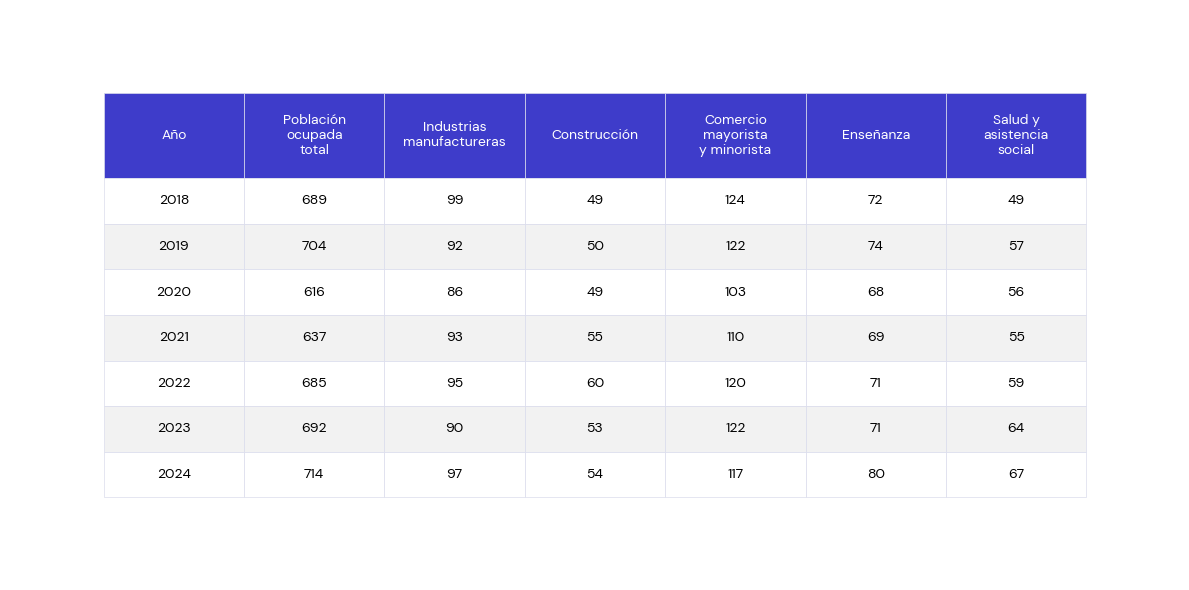

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path

# ─── 1. Fuente personalizada (opcional) ───────────────────────────────────────
font_path = "/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf"
if Path(font_path).exists():
    fm.fontManager.addfont(font_path)
    dm_font = fm.FontProperties(fname=font_path)
else:
    dm_font = fm.FontProperties()

# ─── 2. Cargar y preparar datos ───────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")

# Filtrar por región Biobío
df_bio = df[df["region_name"] == "Biobío"].copy()

# Verificar trimestres y ordenar
orden_trimestres = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}
df_bio["orden"] = df_bio["Trimestre"].map(orden_trimestres)
df_bio = df_bio.sort_values(["Año", "orden"]).drop(columns="orden")

# ─── 3. Mapeo de columnas ─────────────────────────────────────────────────────
column_map = {
    "PO_TOT_rama":   "Población\nocupada\ntotal",
    "PO_MANU_rama":  "Industrias\nmanufactureras",
    "PO_CONS_rama":  "Construcción",
    "PO_COM_rama":   "Comercio\nmayorista\ny minorista",
    "PO_ENSE_rama":  "Enseñanza",
    "PO_SALUD_rama": "Salud y\nasistencia\nsocial",

}


variables = list(column_map.values())
column_keys = list(column_map.keys())

# ─── 4. Verificar que las columnas tengan datos ──────────────────────────────
for key in column_keys:
    non_null_count = df_bio[key].notna().sum()
    total_count = len(df_bio)

# ─── 5. Datos anuales completos ───────────────────────────────────────────────
# Crear subset con columnas necesarias
subset_cols = ["Año"] + column_keys
df_subset = df_bio[subset_cols].copy()

# Agrupación anual
df_anual_full = df_subset.groupby("Año").mean(numeric_only=True).reset_index()
df_anual_full = df_anual_full.rename(columns=column_map)

# ─── 6. Tabla 1: Promedios anuales desde 2018 ─────────────────────────────────
df_anual = df_anual_full[(df_anual_full["Año"] >= 2018) & (df_anual_full["Año"] <= 2024)].copy()
df_anual["Año"] = df_anual["Año"].astype(int).astype(str)
for var in variables:
    if var in df_anual.columns:
        df_anual[var] = df_anual[var].fillna(0).round().astype(int).astype(str)

# ─── 8. Función para mostrar tablas ───────────────────────────────────────────
def mostrar_tabla(df, title=""):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis("off")

    df_display = df.copy()
    for col in df_display.columns:
        if col not in ["Año"]:
            if df_display[col].dtype in ['float64', 'int64', 'float32', 'int32']:
                df_display[col] = df_display[col].apply(lambda x: f"{int(x)}" if pd.notna(x) else "")

    tabla = ax.table(
        cellText=[df_display.columns.tolist()] + df_display.astype(str).values.tolist(),
        cellLoc='center',
        loc='center'
    )
    tabla.auto_set_font_size(False)
    tabla.set_fontsize(11)
    tabla.scale(1.2, 2.0)

    for (row, col), cell in tabla.get_celld().items():
        if row == 0:
            cell.set_facecolor("#3E3CCA")
            cell.set_text_props(color='white', weight='bold', fontproperties=dm_font)
            cell.set_height(0.15)
        else:
            cell.set_facecolor("white" if row % 2 else "#f2f2f2")
            cell.set_text_props(fontproperties=dm_font)
            cell.set_height(0.08)
        cell.set_edgecolor("#DADCEC")
        cell.set_linewidth(0.5)
        cell.set_width(0.12)

    if title:
        plt.title(title, fontsize=14, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()

# ─── 9. Mostrar tabla anual ─────────────────────────────────────────────────
mostrar_tabla(df_anual)




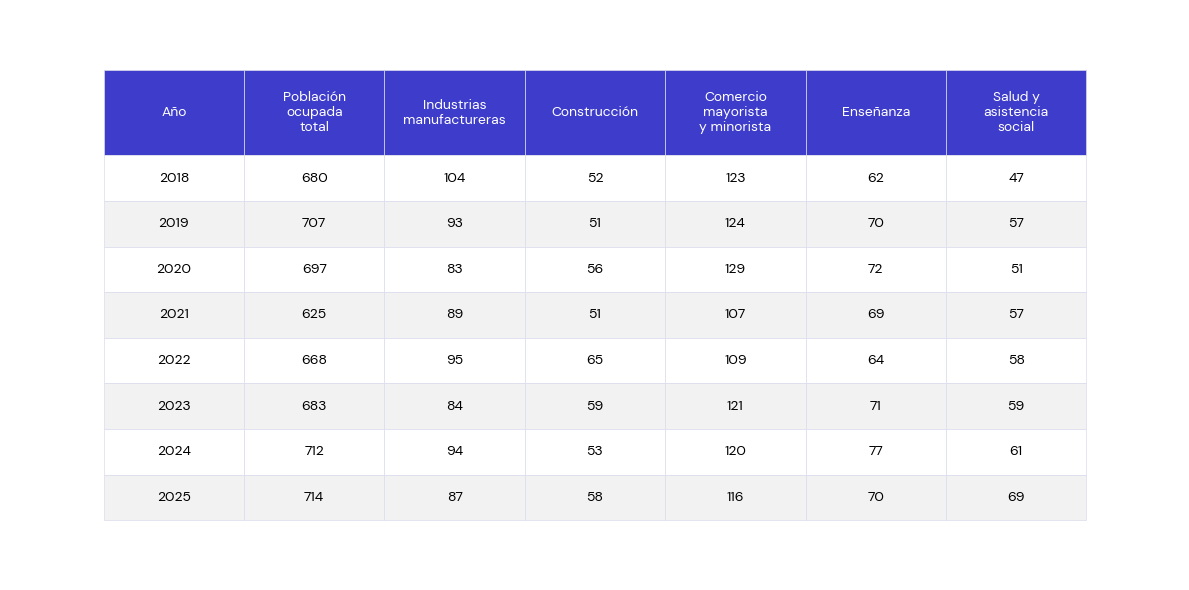

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path

# ─── 1. Fuente personalizada (opcional) ───────────────────────────────────────
font_path = "/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf"
if Path(font_path).exists():
    fm.fontManager.addfont(font_path)
    dm_font = fm.FontProperties(fname=font_path)
else:
    dm_font = fm.FontProperties()

# ─── 2. Cargar y preparar datos ───────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")

# Filtrar por región Biobío
df_bio = df[df["region_name"] == "Biobío"].copy()

# Verificar trimestres y ordenar
orden_trimestres = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}
df_bio["orden"] = df_bio["Trimestre"].map(orden_trimestres)
df_bio = df_bio.sort_values(["Año", "orden"]).drop(columns="orden")

# ─── 3. Mapeo de columnas ─────────────────────────────────────────────────────

column_map = {
    "PO_TOT_rama":   "Población\nocupada\ntotal",
    "PO_MANU_rama":  "Industrias\nmanufactureras",
    "PO_CONS_rama":  "Construcción",
    "PO_COM_rama":   "Comercio\nmayorista\ny minorista",
    "PO_ENSE_rama":  "Enseñanza",
    "PO_SALUD_rama": "Salud y\nasistencia\nsocial",
}


variables = list(column_map.values())
column_keys = list(column_map.keys())

# ─── 4. Verificar que las columnas tengan datos ──────────────────────────────
for key in column_keys:
    non_null_count = df_bio[key].notna().sum()
    total_count = len(df_bio)

# ─── 5. Filtrar solo Q1 de cada año entre 2018 y 2025 ─────────────────────────
df_q1 = df_bio[
    (df_bio["Trimestre"] == "Ene - Mar") &
    (df_bio["Año"].between(2018, 2025))
].copy()

# ─── 6. Seleccionar y renombrar columnas ──────────────────────────────────────
subset_cols = ["Año"] + column_keys
df_q1 = df_q1[subset_cols].copy()
df_q1 = df_q1.rename(columns=column_map)

# Redondear y formatear valores como enteros para mostrar
df_q1["Año"] = df_q1["Año"].astype(int).astype(str)
for var in variables:
    if var in df_q1.columns:
        df_q1[var] = df_q1[var].fillna(0).round().astype(int).astype(str)

# ─── 8. Función para mostrar tablas ───────────────────────────────────────────
def mostrar_tabla(df, title=""):
    fig_width = max(12, 1.2 * len(df.columns))
    fig, ax = plt.subplots(figsize=(fig_width, 6))
    ax.axis("off")

    df_display = df.copy()
    for col in df_display.columns:
        if col not in ["Año"]:
            if df_display[col].dtype in ['float64', 'int64', 'float32', 'int32']:
                df_display[col] = df_display[col].apply(lambda x: f"{int(x)}" if pd.notna(x) else "")

    tabla = ax.table(
        cellText=[df_display.columns.tolist()] + df_display.astype(str).values.tolist(),
        cellLoc='center',
        loc='center'
    )
    tabla.auto_set_font_size(False)
    tabla.set_fontsize(11)
    tabla.scale(1.2, 2.0)

    for (row, col), cell in tabla.get_celld().items():
        if row == 0:
            cell.set_facecolor("#3E3CCA")
            cell.set_text_props(color='white', weight='bold', fontproperties=dm_font)
            cell.set_height(0.15)
        else:
            cell.set_facecolor("white" if row % 2 else "#f2f2f2")
            cell.set_text_props(fontproperties=dm_font)
            cell.set_height(0.08)
        cell.set_edgecolor("#DADCEC")
        cell.set_linewidth(0.5)
        cell.set_width(0.12)

    if title:
        plt.title(title, fontsize=14, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()

# ─── 9. Mostrar tabla anual ─────────────────────────────────────────────────
#mostrar_tabla(df_q1)
def mostrar_tabla_en_bloques(df, columnas_por_bloque=11, title_base=""):
    n_cols = len(df.columns)
    bloques = [df.iloc[:, i:i + columnas_por_bloque] for i in range(1, n_cols, columnas_por_bloque)]

    for i, bloque in enumerate(bloques):
        bloque_df = pd.concat([df[["Año"]], bloque], axis=1)
        mostrar_tabla(bloque_df, title=f"{title_base}")
mostrar_tabla_en_bloques(df_q1, columnas_por_bloque=11)


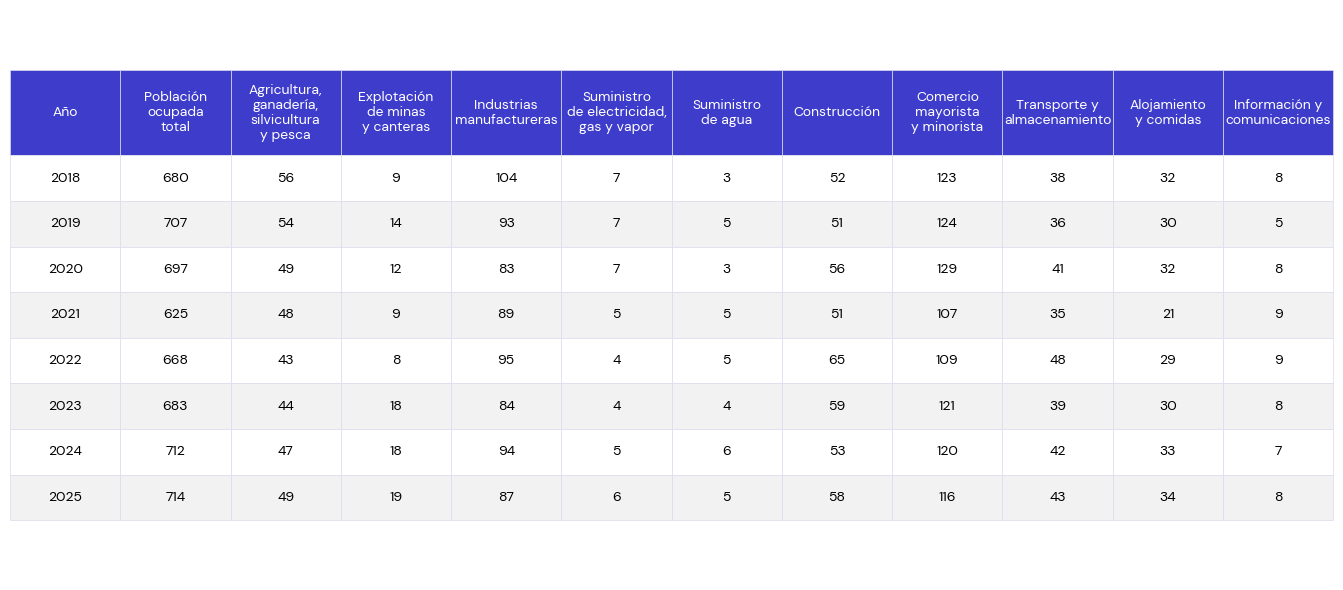

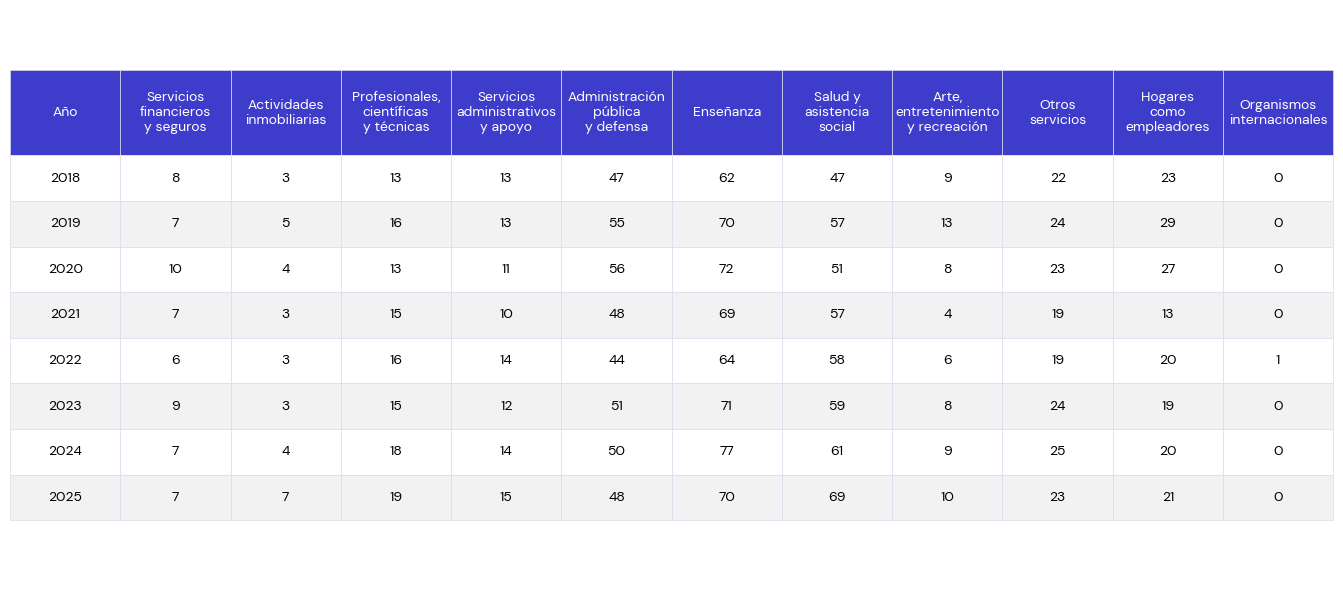

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path

# ─── 1. Fuente personalizada (opcional) ───────────────────────────────────────
font_path = "/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf"
if Path(font_path).exists():
    fm.fontManager.addfont(font_path)
    dm_font = fm.FontProperties(fname=font_path)
else:
    dm_font = fm.FontProperties()

# ─── 2. Cargar y preparar datos ───────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")

# Filtrar por región Biobío
df_bio = df[df["region_name"] == "Biobío"].copy()

# Verificar trimestres y ordenar
orden_trimestres = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}
df_bio["orden"] = df_bio["Trimestre"].map(orden_trimestres)
df_bio = df_bio.sort_values(["Año", "orden"]).drop(columns="orden")

# ─── 3. Mapeo de columnas ─────────────────────────────────────────────────────
column_map = {
      "PO_TOT_rama":   "Población\nocupada\ntotal",
    "PO_AGSP_rama":  "Agricultura,\nganadería,\nsilvicultura\ny pesca",
    "PO_MIN_rama":   "Explotación\nde minas\ny canteras",
    "PO_MANU_rama":  "Industrias\nmanufactureras",
    "PO_ELEC_rama":  "Suministro\nde electricidad,\ngas y vapor",
    "PO_AGUA_rama":  "Suministro\nde agua",
    "PO_CONS_rama":  "Construcción",
    "PO_COM_rama":   "Comercio\nmayorista\ny minorista",
    "PO_TRANS_rama": "Transporte y\nalmacenamiento",
    "PO_HOTE_rama":  "Alojamiento\ny comidas",
    "PO_INFO_rama":  "Información y\ncomunicaciones",
    "PO_FIN_rama":   "Servicios\nfinancieros\ny seguros",
    "PO_INMO_rama":  "Actividades\ninmobiliarias",
    "PO_PROF_rama":  "Profesionales,\ncientíficas\ny técnicas",
    "PO_SADP_rama":  "Servicios\nadministrativos\ny apoyo",
    "PO_APD_rama":   "Administración\npública\ny defensa",
    "PO_ENSE_rama":  "Enseñanza",
    "PO_SALUD_rama": "Salud y\nasistencia\nsocial",
    "PO_ART_rama":   "Arte,\nentretenimiento\ny recreación",
    "PO_OTROS_rama": "Otros\nservicios",
    "PO_HOG_rama":   "Hogares\ncomo\nempleadores",
    "PO_EXTRA_rama": "Organismos\ninternacionales",
}


variables = list(column_map.values())
column_keys = list(column_map.keys())

# ─── 4. Verificar que las columnas tengan datos ──────────────────────────────
for key in column_keys:
    non_null_count = df_bio[key].notna().sum()
    total_count = len(df_bio)

# ─── 5. Filtrar solo Q1 de cada año entre 2018 y 2025 ─────────────────────────
df_q1 = df_bio[
    (df_bio["Trimestre"] == "Ene - Mar") &
    (df_bio["Año"].between(2018, 2025))
].copy()

# ─── 6. Seleccionar y renombrar columnas ──────────────────────────────────────
subset_cols = ["Año"] + column_keys
df_q1 = df_q1[subset_cols].copy()
df_q1 = df_q1.rename(columns=column_map)

# Redondear y formatear valores como enteros para mostrar
df_q1["Año"] = df_q1["Año"].astype(int).astype(str)
for var in variables:
    if var in df_q1.columns:
        df_q1[var] = df_q1[var].fillna(0).round().astype(int).astype(str)

# ─── 8. Función para mostrar tablas ───────────────────────────────────────────
def mostrar_tabla(df, title=""):
    fig_width = max(12, 1.2 * len(df.columns))
    fig, ax = plt.subplots(figsize=(fig_width, 6))
    ax.axis("off")

    df_display = df.copy()
    for col in df_display.columns:
        if col not in ["Año"]:
            if df_display[col].dtype in ['float64', 'int64', 'float32', 'int32']:
                df_display[col] = df_display[col].apply(lambda x: f"{int(x)}" if pd.notna(x) else "")

    tabla = ax.table(
        cellText=[df_display.columns.tolist()] + df_display.astype(str).values.tolist(),
        cellLoc='center',
        loc='center'
    )
    tabla.auto_set_font_size(False)
    tabla.set_fontsize(11)
    tabla.scale(1.2, 2.0)

    for (row, col), cell in tabla.get_celld().items():
        if row == 0:
            cell.set_facecolor("#3E3CCA")
            cell.set_text_props(color='white', weight='bold', fontproperties=dm_font)
            cell.set_height(0.15)
        else:
            cell.set_facecolor("white" if row % 2 else "#f2f2f2")
            cell.set_text_props(fontproperties=dm_font)
            cell.set_height(0.08)
        cell.set_edgecolor("#DADCEC")
        cell.set_linewidth(0.5)
        cell.set_width(0.12)

    if title:
        plt.title(title, fontsize=14, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()

# ─── 9. Mostrar tabla anual ─────────────────────────────────────────────────
#mostrar_tabla(df_q1)
def mostrar_tabla_en_bloques(df, columnas_por_bloque=11, title_base=""):
    n_cols = len(df.columns)
    bloques = [df.iloc[:, i:i + columnas_por_bloque] for i in range(1, n_cols, columnas_por_bloque)]

    for i, bloque in enumerate(bloques):
        bloque_df = pd.concat([df[["Año"]], bloque], axis=1)
        mostrar_tabla(bloque_df, title=f"{title_base}")
mostrar_tabla_en_bloques(df_q1, columnas_por_bloque=11)


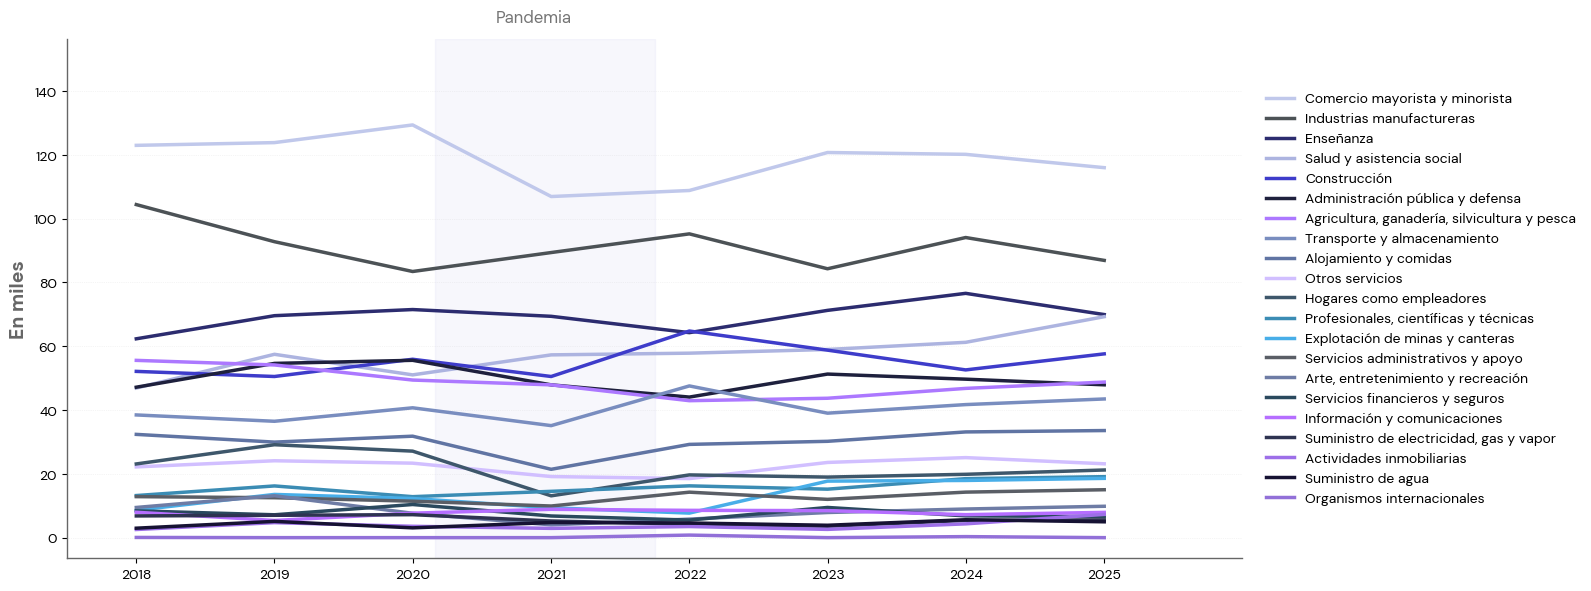

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path
from matplotlib.dates import date2num
from matplotlib.patches import Rectangle

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar solo la región del Biobío desde 2018 ────────────────────────────
df_bio = df[df["region_name"] == "Biobío"]
df_bio = df_bio[df_bio["Fecha"] >= "2018-01-01"]
df_bio['Año'] = df_bio['Fecha'].dt.year
df_bio = df_bio[df_bio["Trimestre"] == "Ene - Mar"]
df_bio = df_bio[df_bio["Año"] <= 2025]

# ─── Calcular promedios anuales ───────────────────────────────────────────────
columnas_y_nombres = [
    ("PO_AGSP_rama",  "Agricultura, ganadería, silvicultura y pesca"),
    ("PO_MIN_rama",   "Explotación de minas y canteras"),
    ("PO_MANU_rama",  "Industrias manufactureras"),
    ("PO_ELEC_rama",  "Suministro de electricidad, gas y vapor"),
    ("PO_AGUA_rama",  "Suministro de agua"),
    ("PO_CONS_rama",  "Construcción"),
    ("PO_COM_rama",   "Comercio mayorista y minorista"),
    ("PO_TRANS_rama", "Transporte y almacenamiento"),
    ("PO_HOTE_rama",  "Alojamiento y comidas"),
    ("PO_INFO_rama",  "Información y comunicaciones"),
    ("PO_FIN_rama",   "Servicios financieros y seguros"),
    ("PO_INMO_rama",  "Actividades inmobiliarias"),
    ("PO_PROF_rama",  "Profesionales, científicas y técnicas"),
    ("PO_SADP_rama",  "Servicios administrativos y apoyo"),
    ("PO_APD_rama",   "Administración pública y defensa"),
    ("PO_ENSE_rama",  "Enseñanza"),
    ("PO_SALUD_rama", "Salud y asistencia social"),
    ("PO_ART_rama",   "Arte, entretenimiento y recreación"),
    ("PO_OTROS_rama", "Otros servicios"),
    ("PO_HOG_rama",   "Hogares como empleadores"),
    ("PO_EXTRA_rama", "Organismos internacionales"),
]


colores = [
    "#ac78ff", "#48aee8", "#4c5256", "#2e3351", "#161233",
    "#3e3cca", "#c0c8eb", "#798dbf", "#6074a3", "#b56eff", "#2a495e",
    "#9d6fe8", "#3b8cb4", "#5a5e66", "#1e203d", "#2c2c6f", "#adb4e0",
    "#6e7ca5", "#d1bfff", "#3e576b", "#9270d8", "#44516f", "#26304d"
]

columnas = [col for col, _ in columnas_y_nombres]

promedios_q1 = df_bio.copy()
promedios_q1['Fecha'] = pd.to_datetime(promedios_q1['Año'].astype(str) + '-01-01')


# ─── Crear gráfico ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(16, 6))

# Sombreado pandemia
ax.axvspan(
    date2num(pd.to_datetime("2020-03-01")),
    date2num(pd.to_datetime("2021-10-01")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# Preparar datos para trazado ordenado
ultimos_valores = []
for (col, nombre), color in zip(columnas_y_nombres, colores):
    y_ultimo = promedios_anuales[col].iloc[-1]
    ultimos_valores.append((y_ultimo, col, nombre, color))

# Ordenar de mayor a menor según valor final
ultimos_valores.sort(reverse=True)

# Trazar líneas y recolectar handles para leyenda
handles = []
labels = []
for _, col, nombre, color in ultimos_valores:
    line, = ax.plot(promedios_q1["Fecha"], promedios_q1[col],
                    label=nombre, color=color, linewidth=2.5, marker=None)
    handles.append(line)
    labels.append(nombre)


# Texto "Pandemia" desplazado hacia arriba
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 1.18,
    "Pandemia",
    fontproperties=dm_font_props,
    fontsize=12,
    ha="center",
    va="bottom",
    color="#666666",
    alpha=0.9
)

# Leyenda externa ordenada
ax.legend(
    handles=handles,
    labels=labels,
    loc='center left',
    bbox_to_anchor=(1.01, 0.5),
    frameon=False,
    prop=dm_font_props,
    fontsize=11
)


# Ajustar el layout para dejar espacio a la derecha
plt.tight_layout(rect=[0, 0, 0.88, 1])


# Ejes y estilos
ax.set_ylabel("En miles", fontproperties=dm_font_bold, fontsize=14, color="#666666")
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color("#666666")
ax.spines["bottom"].set_color("#666666")
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

ax.set_ylim(bottom=ax.get_ylim()[0], top=ax.get_ylim()[1] * 1.15)
ax.set_xlim(pd.to_datetime("2017-07-01"), pd.to_datetime("2025-12-31"))

fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()


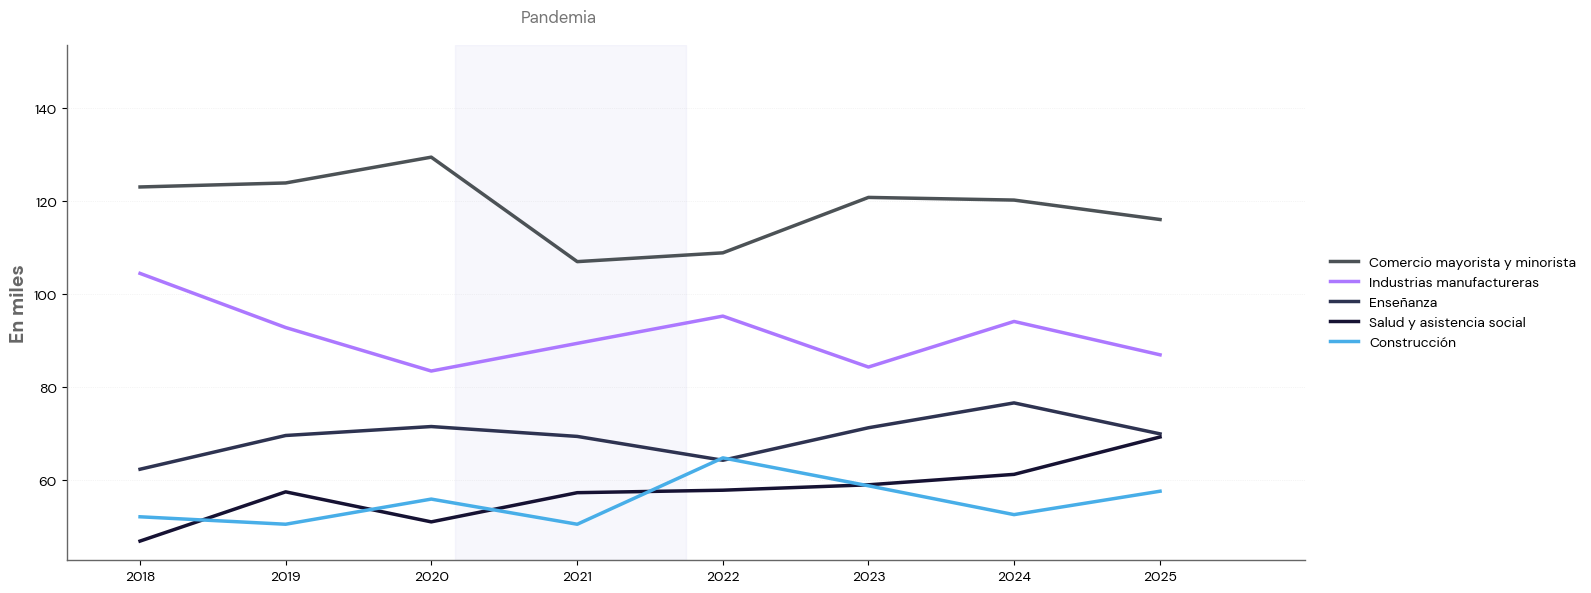

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path
from matplotlib.dates import date2num
from matplotlib.patches import Rectangle

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar solo la región del Biobío desde 2018 ────────────────────────────
df_bio = df[df["region_name"] == "Biobío"]
df_bio = df_bio[df_bio["Fecha"] >= "2018-01-01"]
df_bio['Año'] = df_bio['Fecha'].dt.year
df_bio = df_bio[df_bio["Trimestre"] == "Ene - Mar"]
df_bio = df_bio[df_bio["Año"] <= 2025]

# ─── Calcular promedios anuales ───────────────────────────────────────────────
columnas_y_nombres = [
    ("PO_MANU_rama",  "Industrias manufactureras"),
    ("PO_CONS_rama",  "Construcción"),
    ("PO_COM_rama",   "Comercio mayorista y minorista"),
    ("PO_ENSE_rama",  "Enseñanza"),
    ("PO_SALUD_rama", "Salud y asistencia social"),
]


colores = [
    "#ac78ff", "#48aee8", "#4c5256", "#2e3351", "#161233",
    "#3e3cca", "#c0c8eb", "#798dbf", "#6074a3", "#b56eff", "#2a495e",
    "#9d6fe8", "#3b8cb4", "#5a5e66", "#1e203d", "#2c2c6f", "#adb4e0",
    "#6e7ca5", "#d1bfff", "#3e576b", "#9270d8", "#44516f", "#26304d"
]

columnas = [col for col, _ in columnas_y_nombres]

promedios_q1 = df_bio.copy()
promedios_q1['Fecha'] = pd.to_datetime(promedios_q1['Año'].astype(str) + '-01-01')


# ─── Crear gráfico ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(16, 6))

# Sombreado pandemia
ax.axvspan(
    date2num(pd.to_datetime("2020-03-01")),
    date2num(pd.to_datetime("2021-10-01")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# Preparar datos para trazado ordenado
ultimos_valores = []
for (col, nombre), color in zip(columnas_y_nombres, colores):
    y_ultimo = promedios_anuales[col].iloc[-1]
    ultimos_valores.append((y_ultimo, col, nombre, color))

# Ordenar de mayor a menor según valor final
ultimos_valores.sort(reverse=True)

# Trazar líneas y recolectar handles para leyenda
handles = []
labels = []
for _, col, nombre, color in ultimos_valores:
    line, = ax.plot(promedios_q1["Fecha"], promedios_q1[col],
                    label=nombre, color=color, linewidth=2.5, marker=None)
    handles.append(line)
    labels.append(nombre)


# Texto "Pandemia" desplazado hacia arriba
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 1.18,
    "Pandemia",
    fontproperties=dm_font_props,
    fontsize=12,
    ha="center",
    va="bottom",
    color="#666666",
    alpha=0.9
)

# Leyenda externa ordenada
ax.legend(
    handles=handles,
    labels=labels,
    loc='center left',
    bbox_to_anchor=(1.01, 0.5),
    frameon=False,
    prop=dm_font_props,
    fontsize=11
)


# Ajustar el layout para dejar espacio a la derecha
plt.tight_layout(rect=[0, 0, 0.88, 1])


# Ejes y estilos
ax.set_ylabel("En miles", fontproperties=dm_font_bold, fontsize=14, color="#666666")
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color("#666666")
ax.spines["bottom"].set_color("#666666")
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

ax.set_ylim(bottom=ax.get_ylim()[0], top=ax.get_ylim()[1] * 1.15)
ax.set_xlim(pd.to_datetime("2017-07-01"), pd.to_datetime("2025-12-31"))

fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()


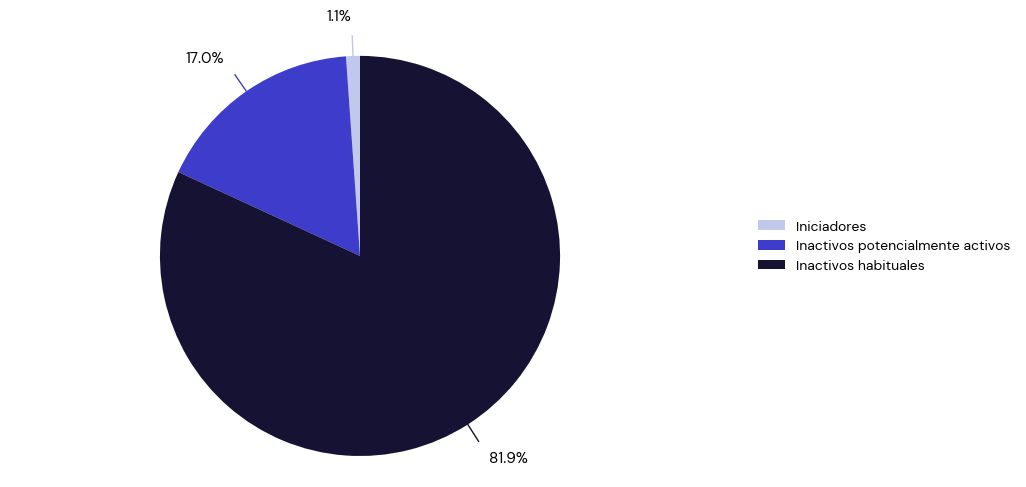

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.font_manager as fm
from pathlib import Path
import numpy as np

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar solo la región del Biobío y el primer trimestre de 2025 ─────────
df_bio = df[(df["region_name"] == "Biobío") & (df["Periodo"] == "2025Q1")]

# ─── Variables y etiquetas ────────────────────────────────────────────────────
variables = [
    "FFT_INI_indicadoresprincipales",
    "FFT_PACT_indicadoresprincipales",
    "FFT_HAB_indicadoresprincipales"
]

etiquetas = [
    "Iniciadores",
    "Inactivos potencialmente activos",
    "Inactivos habituales"
]

valores = df_bio[variables].iloc[0].values
colores = ["#c0c8eb", "#3e3cca", "#161233"]

# ─── Crear gráfico ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))

# Pie sin labels ni título
wedges, texts = ax.pie(valores, startangle=90, colors=colores, labels=['']*len(etiquetas), wedgeprops={'edgecolor': 'none', 'linewidth': 0})

# Porcentajes fuera de la torta, conectados con línea
porcentajes = 100 * valores / valores.sum()
for i, (p, w) in enumerate(zip(porcentajes, wedges)):
    ang = (w.theta2 + w.theta1) / 2.
    x = np.cos(np.deg2rad(ang))
    y = np.sin(np.deg2rad(ang))
    ha = 'left' if x > 0 else 'right'
    ax.text(x * 1.2, y * 1.2, f'{p:.1f}%', ha=ha, va='center', fontsize=11, fontproperties=dm_font_props)
    ax.plot([x * 0.9, x * 1.1], [y * 0.9, y * 1.1], color=colores[i], lw=1)

# Leyenda con color e identificación
from matplotlib.patches import Patch
leyenda = [Patch(facecolor=color, label=f'{etiqueta}')
           for etiqueta, valor, color in zip(etiquetas, valores, colores)]

ax.legend(handles=leyenda,
          loc='center left',
          bbox_to_anchor=(1.05, 0.5),
          frameon=False,
          prop=dm_font_props,
          fontsize=11)


# Ajuste general
plt.axis('equal')
plt.subplots_adjust(left=0.05, right=0.75)
plt.show()


# Cambio

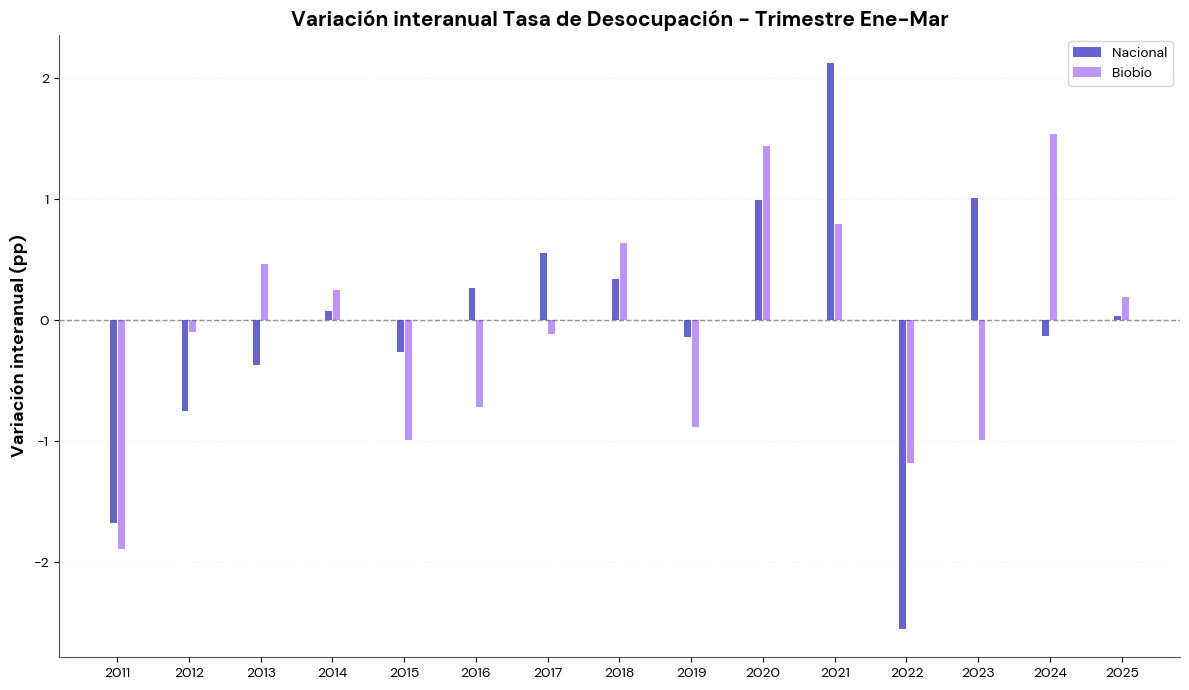

In [ ]:
# ─── 1. Cargar librerías y fuente DM Sans ─────────────────────────────────────
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
import matplotlib.dates as mdates

# Configurar fuente DM Sans desde Google Drive
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]

found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            found_fonts.append(font_path)
            fm.fontManager.addfont(str(font_path))

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold = fm.FontProperties(family=dm_font_name, weight='bold')

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans', 'Arial']
})

# ─── 2. Cargar datos desde archivo Excel ──────────────────────────────────────
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
df = pd.read_excel(PANEL_PATH, sheet_name="panel_data")

df["Fecha"] = pd.to_datetime(df["Fecha"])
df.sort_values("Fecha", inplace=True)

# ─── 3. Paleta de colores ─────────────────────────────────────────────────────
PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",
]

# ─── 4. Filtrar solo trimestres Ene - Mar ─────────────────────────────────────
df_q1 = df[df["Trimestre"] == "Ene - Mar"].copy()

# ─── 5. Calcular variación interanual por región ──────────────────────────────
def variacion_interanual_q1(df_region):
    df_region = df_region.sort_values("Fecha").copy()
    df_region["var"] = (
        df_region["T_TDO_indicadoresprincipales"]
        - df_region["T_TDO_indicadoresprincipales"].shift(1)
    )
    return df_region

nac_q1 = variacion_interanual_q1(df_q1[df_q1["region_name"] == "Nacional"].copy())
bio_q1 = variacion_interanual_q1(df_q1[df_q1["region_name"] == "Biobío"].copy())

# ─── 6. Gráfico de barras comparando variación Ene-Mar ────────────────────────
fig, ax = plt.subplots(figsize=(12, 7))

# Barras Nacional (a la izquierda)
ax.bar(nac_q1["Fecha"] - pd.DateOffset(days=20), nac_q1["var"], width=35,
       label="Nacional", color=PALETTE[3], alpha=0.8)

# Barras Biobío (a la derecha)
ax.bar(bio_q1["Fecha"] + pd.DateOffset(days=20), bio_q1["var"], width=35,
       label="Biobío", color=PALETTE[6], alpha=0.8)

# Línea base 0
ax.axhline(0, color=PALETTE[0], linestyle="--", linewidth=1, alpha=0.6)

# Ejes y etiquetas
ax.set_title("Variación interanual Tasa de Desocupación - Trimestre Ene-Mar",
             fontproperties=dm_font_bold, fontsize=15)

ax.set_ylabel("Variación interanual (pp)",
              fontproperties=dm_font_bold, fontsize=13)

ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Leyenda y estética
ax.legend(prop=dm_font_props)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)

plt.tight_layout()
plt.show()


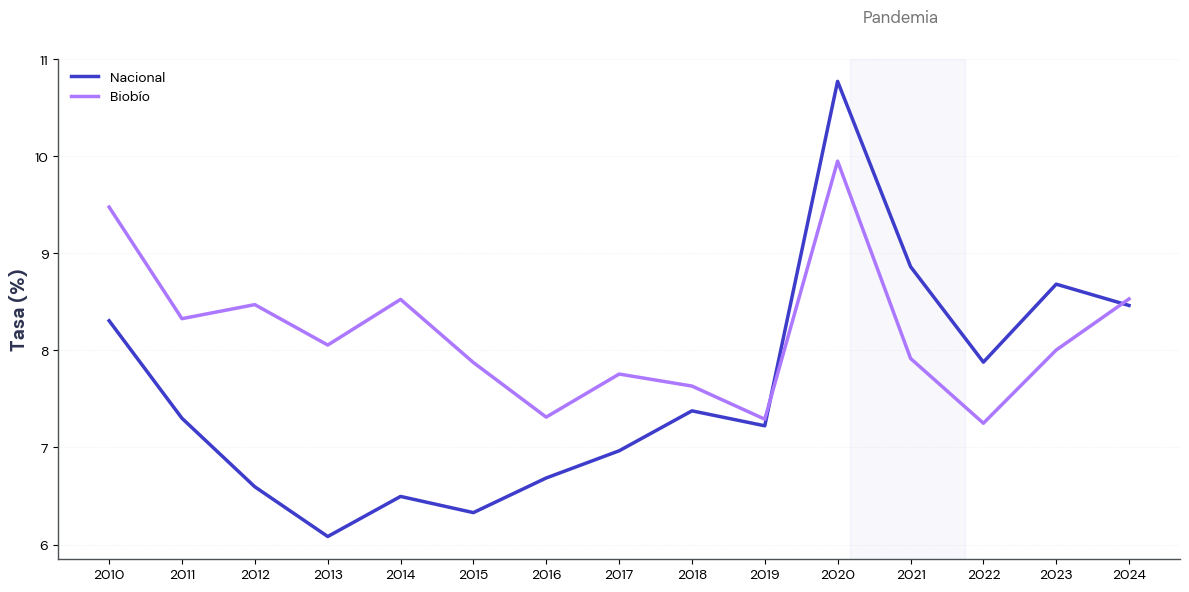

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})



# ─── Paleta de colores ────────────────────────────────────────────────────────
PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",  # azul institucional
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",  # otros tonos
]

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar Nacional y Biobío ────────────────────────────────────────────────
df_nac = df[df["region_name"] == "Nacional"]
df_bio = df[df["region_name"] == "Biobío"]


# ─── Calcular promedio anual ──────────────────────────────────────────────────
df_nac_anual = df_nac.groupby("Año")["T_TDO_indicadoresprincipales"].mean().reset_index()
df_bio_anual = df_bio.groupby("Año")["T_TDO_indicadoresprincipales"].mean().reset_index()

df_nac_anual = df_nac_anual[df_nac_anual["Año"] <= 2024]
df_bio_anual = df_bio_anual[df_bio_anual["Año"] <= 2024]

# ─── Convertir año a fecha para usar eje temporal ─────────────────────────────
df_nac_anual["Fecha"] = pd.to_datetime(df_nac_anual["Año"].astype(str) + "-01-01")
df_bio_anual["Fecha"] = pd.to_datetime(df_bio_anual["Año"].astype(str) + "-01-01")

import matplotlib.dates as mdates
from matplotlib.dates import date2num

# ─── Crear gráfico ────────────────────────────────────────────────────────────
# ─── Crear gráfico con fechas como eje ────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))

# Sombreado leve para pandemia
ax.axvspan(
    date2num(pd.to_datetime("2020-03-01")),
    date2num(pd.to_datetime("2021-10-01")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# Líneas de promedio anual
ax.plot(df_nac_anual["Fecha"], df_nac_anual["T_TDO_indicadoresprincipales"],
        label="Nacional", color=PALETTE[3], linewidth=2.5)
ax.plot(df_bio_anual["Fecha"], df_bio_anual["T_TDO_indicadoresprincipales"],
        label="Biobío", color=PALETTE[6], linewidth=2.5)

# Texto “Pandemia”
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 1.03,
    "Pandemia",
    fontproperties=dm_font,
    fontsize=12,
    ha="center",
    va="bottom",
    color="#666666",
    alpha=0.9
)

# Ejes y formato
ax.set_ylabel("Tasa (%)", fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])

ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font)

ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

ax.legend(frameon=False, loc="upper left", fontsize=12, prop=dm_font)

plt.tight_layout()
plt.show()



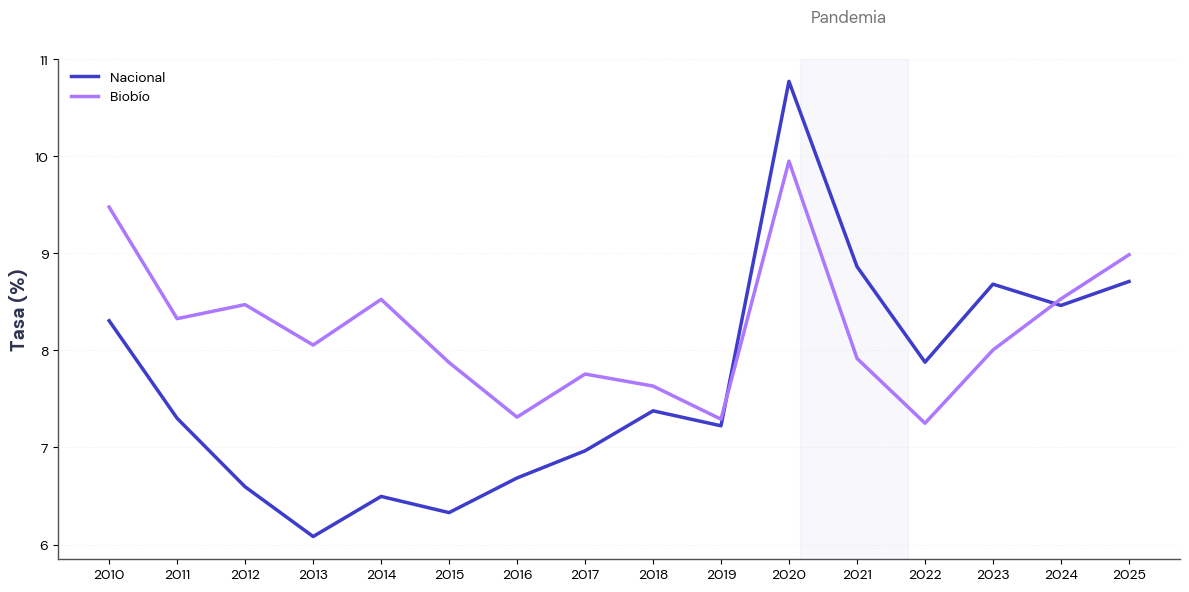

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})



# ─── Paleta de colores ────────────────────────────────────────────────────────
PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",  # azul institucional
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",  # otros tonos
]

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar Nacional y Biobío ────────────────────────────────────────────────
df_nac = df[df["region_name"] == "Nacional"]
df_bio = df[df["region_name"] == "Biobío"]


# ─── Calcular promedio anual ──────────────────────────────────────────────────
df_nac_anual = df_nac.groupby("Año")["T_TDO_indicadoresprincipales"].mean().reset_index()
df_bio_anual = df_bio.groupby("Año")["T_TDO_indicadoresprincipales"].mean().reset_index()

# ─── Convertir año a fecha para usar eje temporal ─────────────────────────────
df_nac_anual["Fecha"] = pd.to_datetime(df_nac_anual["Año"].astype(str) + "-01-01")
df_bio_anual["Fecha"] = pd.to_datetime(df_bio_anual["Año"].astype(str) + "-01-01")

import matplotlib.dates as mdates
from matplotlib.dates import date2num

# ─── Crear gráfico ────────────────────────────────────────────────────────────
# ─── Crear gráfico con fechas como eje ────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))

# Sombreado leve para pandemia
ax.axvspan(
    date2num(pd.to_datetime("2020-03-01")),
    date2num(pd.to_datetime("2021-10-01")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# Líneas de promedio anual
ax.plot(df_nac_anual["Fecha"], df_nac_anual["T_TDO_indicadoresprincipales"],
        label="Nacional", color=PALETTE[3], linewidth=2.5)
ax.plot(df_bio_anual["Fecha"], df_bio_anual["T_TDO_indicadoresprincipales"],
        label="Biobío", color=PALETTE[6], linewidth=2.5)

# Texto “Pandemia”
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 1.03,
    "Pandemia",
    fontproperties=dm_font,
    fontsize=12,
    ha="center",
    va="bottom",
    color="#666666",
    alpha=0.9
)

# Ejes y formato
ax.set_ylabel("Tasa (%)", fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])

ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font)

ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

ax.legend(frameon=False, loc="upper left", fontsize=12, prop=dm_font)

plt.tight_layout()
plt.show()



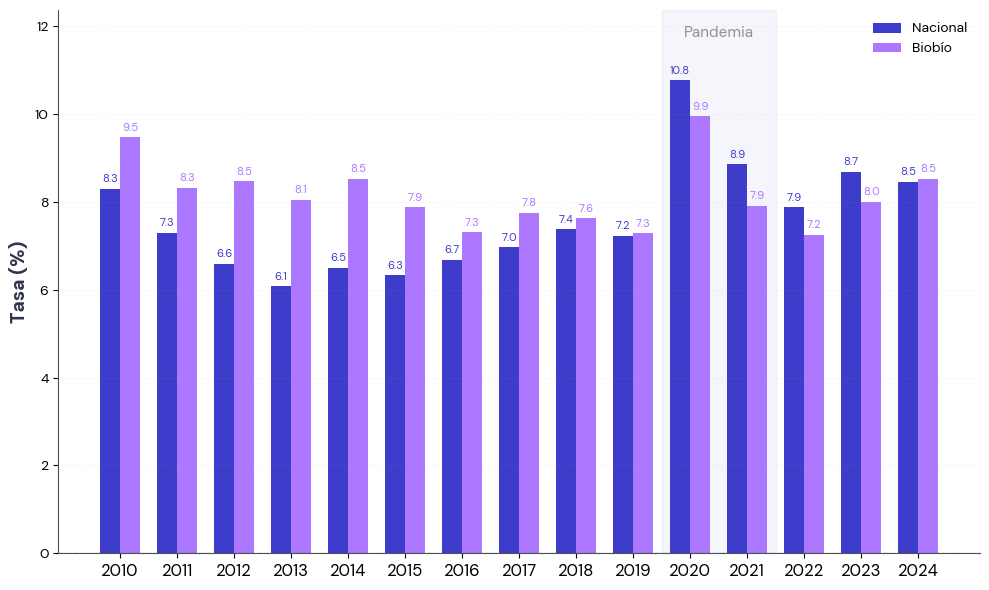

✅ Gráfico guardado: /content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo.png


<Figure size 640x480 with 0 Axes>

In [ ]:
# ─── 1. Configuración inicial ─────────────────────────────────────────────────
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path

# Paleta institucional
PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",
]

# Paths
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
OUT_FILE   = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo.png")

# ─── 2. Cargar fuentes DM Sans desde Drive ────────────────────────────────────
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── 3. Cargar datos y calcular promedio anual ────────────────────────────────
df = pd.read_excel(PANEL_PATH, sheet_name="biobio_vs_nacional")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df["Año"] = df["Fecha"].dt.year

prom = df.groupby(["Año", "region_name"])["T_TDO_indicadoresprincipales"].mean().unstack()
prom = prom[(prom.index >= 2010) & (prom.index <= 2024)]  # Filtro hasta 2024

# ─── 4. Gráfico de barras ─────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(prom.index))

# Barras
ax.bar(x - bar_width/2, prom["Nacional"], width=bar_width,
       color=PALETTE[3], label="Nacional")
ax.bar(x + bar_width/2, prom["Biobío"], width=bar_width,
       color=PALETTE[6], label="Biobío")

# Eje X
ax.set_xticks(x)
ax.set_xticklabels(prom.index, fontproperties=dm_font_props, fontsize=12)

# Eje Y
ax.set_ylabel("Tasa (%)",
              fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])
ax.tick_params(axis='y', labelsize=11)
for label in ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Línea cero y rejilla
ax.axhline(0, color=PALETTE[0], linestyle="--", linewidth=1, alpha=0.4)
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

# Sombreado pandemia
x_dict = {año: i for i, año in enumerate(prom.index)}
if 2020 in x_dict and 2021 in x_dict:
    ax.axvspan(x_dict[2020] - 0.5, x_dict[2021] + 0.5,
               color=PALETTE[3], alpha=0.05, zorder=0)
    x_centro = (x_dict[2020] + x_dict[2021]) / 2  # ← Definir aquí

# Layout antes de insertar texto para conocer los límites
plt.tight_layout()
plt.draw()

# 1. Subimos límite del eje Y con margen cómodo
y_max = prom.max().max() + 1.6
ax.set_ylim(0, y_max)

# 2. Texto “Pandemia” más arriba, sin superposición
ax.text(x_centro, y_max * 0.97,
        "Pandemia", ha="center", va="top",
        fontsize=11, fontproperties=dm_font_props,
        color=PALETTE[0], alpha=0.6)

# 3. Etiquetas sobre barras, más espaciadas
for i, año in enumerate(prom.index):
    nac_val = prom.loc[año, "Nacional"]
    bio_val = prom.loc[año, "Biobío"]

    ax.text(x[i] - bar_width/2, nac_val + 0.15, f"{nac_val:.1f}",
            ha="center", fontsize=8, fontproperties=dm_font_props,
            color=PALETTE[3])

    ax.text(x[i] + bar_width/2, bio_val + 0.15, f"{bio_val:.1f}",
            ha="center", fontsize=8, fontproperties=dm_font_props,
            color=PALETTE[6])

# Leyenda
ax.legend(frameon=False, loc="upper right",
          prop=dm_font_props, fontsize=12)

# Bordes
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])

# Mostrar y guardar
plt.show()

try:
    OUT_FILE.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUT_FILE, dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    print(f"✅ Gráfico guardado: {OUT_FILE}")
except Exception as e:
    print(f"⚠️ Error al guardar: {e}")


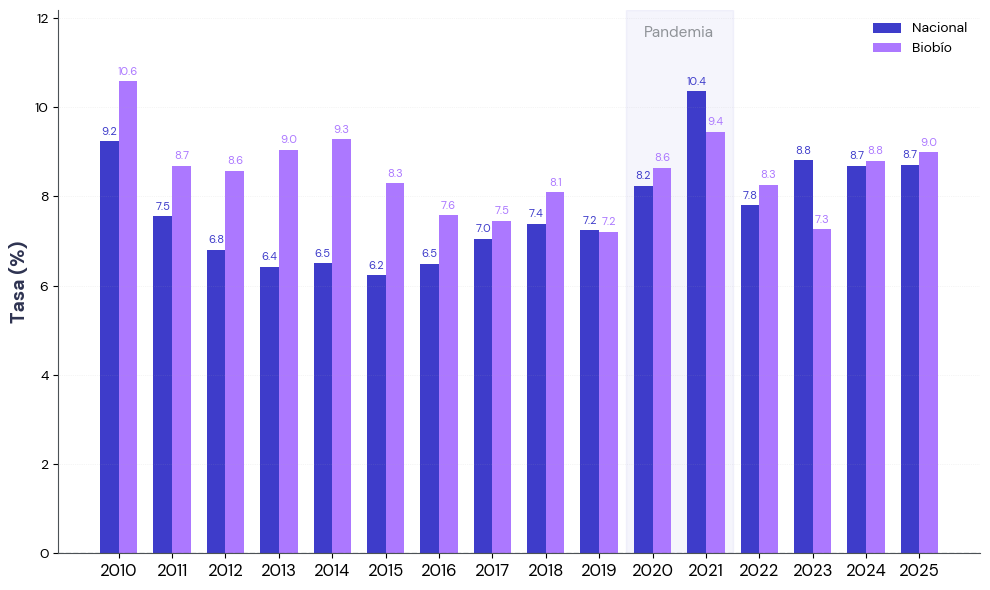

✅ Gráfico guardado: /content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo.png


<Figure size 640x480 with 0 Axes>

In [ ]:
# ─── 1. Configuración inicial ─────────────────────────────────────────────────
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path

# Paleta institucional
PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",
]

# Paths
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
OUT_FILE   = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo.png")

# ─── 2. Cargar fuentes DM Sans desde Drive ────────────────────────────────────
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── 3. Cargar datos y filtrar por "Ene - Mar" ────────────────────────────────
df = pd.read_excel(PANEL_PATH, sheet_name="biobio_vs_nacional")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df["Año"] = df["Fecha"].dt.year

# Filtrar solo los datos correspondientes a "Ene - Mar"
df_q1 = df[df['Trimestre'] == "Ene - Mar"]

# Agrupar por Año y region_name, luego calcular el promedio de "T_TDO_indicadoresprincipales"
prom = df_q1.groupby(["Año", "region_name"])["T_TDO_indicadoresprincipales"].mean().unstack()

# Filtrar hasta 2025
prom = prom[prom.index <= 2025]

# ─── 4. Gráfico de barras ─────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(prom.index))

# Barras
ax.bar(x - bar_width/2, prom["Nacional"], width=bar_width,
       color=PALETTE[3], label="Nacional")
ax.bar(x + bar_width/2, prom["Biobío"], width=bar_width,
       color=PALETTE[6], label="Biobío")

# Eje X
ax.set_xticks(x)
ax.set_xticklabels(prom.index, fontproperties=dm_font_props, fontsize=12)

# Eje Y
ax.set_ylabel("Tasa (%)",
              fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])
ax.tick_params(axis='y', labelsize=11)
for label in ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Línea cero y rejilla
ax.axhline(0, color=PALETTE[0], linestyle="--", linewidth=1, alpha=0.4)
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

# Sombreado pandemia
x_dict = {año: i for i, año in enumerate(prom.index)}
if 2020 in x_dict and 2021 in x_dict:
    ax.axvspan(x_dict[2020] - 0.5, x_dict[2021] + 0.5,
               color=PALETTE[3], alpha=0.05, zorder=0)
    x_centro = (x_dict[2020] + x_dict[2021]) / 2  # ← Definir aquí

# Layout antes de insertar texto para conocer los límites
plt.tight_layout()
plt.draw()

# 1. Subimos límite del eje Y con margen cómodo
y_max = prom.max().max() + 1.6
ax.set_ylim(0, y_max)

# 2. Texto “Pandemia” más arriba, sin superposición
ax.text(x_centro, y_max * 0.97,
        "Pandemia", ha="center", va="top",
        fontsize=11, fontproperties=dm_font_props,
        color=PALETTE[0], alpha=0.6)

# 3. Etiquetas sobre barras, más espaciadas
for i, año in enumerate(prom.index):
    nac_val = prom.loc[año, "Nacional"]
    bio_val = prom.loc[año, "Biobío"]

    ax.text(x[i] - bar_width/2, nac_val + 0.15, f"{nac_val:.1f}",
            ha="center", fontsize=8, fontproperties=dm_font_props,
            color=PALETTE[3])

    ax.text(x[i] + bar_width/2, bio_val + 0.15, f"{bio_val:.1f}",
            ha="center", fontsize=8, fontproperties=dm_font_props,
            color=PALETTE[6])

# Leyenda
ax.legend(frameon=False, loc="upper right",
          prop=dm_font_props, fontsize=12)

# Bordes
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])

# Mostrar y guardar
plt.show()

try:
    OUT_FILE.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUT_FILE, dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    print(f"✅ Gráfico guardado: {OUT_FILE}")
except Exception as e:
    print(f"⚠️ Error al guardar: {e}")



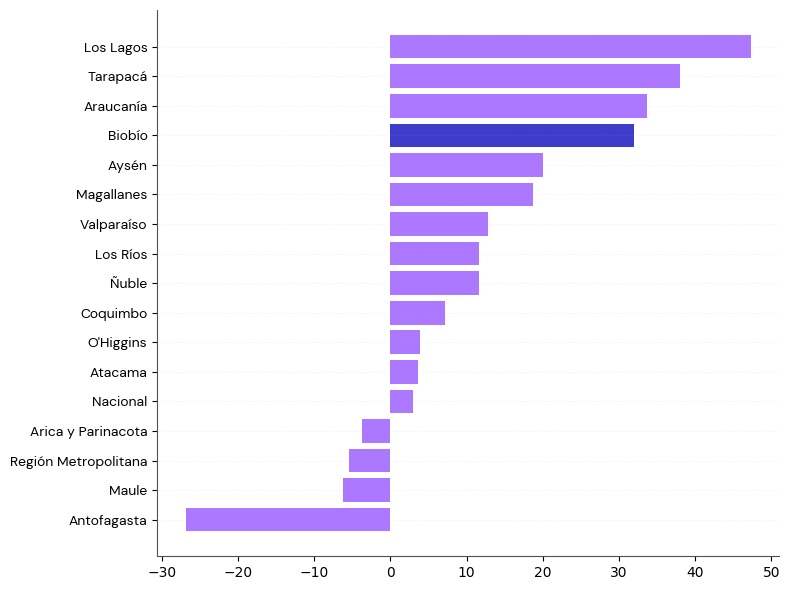

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path

# ─── 1. Configurar fuente DM Sans ────────────────────────────────────────────
font_path = Path("/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf")
if font_path.exists():
    fm.fontManager.addfont(str(font_path))
    dm_font = fm.FontProperties(fname=str(font_path))
else:
    dm_font = fm.FontProperties(family="sans-serif")

# ─── 2. Cargar panel y filtrar Q1 2023 & Q1 2025 ─────────────────────────────
ruta = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
df = pd.read_excel(ruta, sheet_name="panel_data")
df2 = df[df["Periodo"].isin(["2023Q1", "2025Q1"])].copy()
df2["region_name"] = df2["region_name"].str.replace("’","'").str.strip()

# ─── 3. Extraer sólo Personas Desocupadas y pivoteo ─────────────────────────
col = "PDO_TOT_indicadoresprincipales"
pivot = (
    df2.set_index(["region_name","Periodo"])[col]
       .unstack("Periodo")
)

# ─── 4. Calcular crecimiento % 2023→2025 ────────────────────────────────────
growth = ((pivot["2025Q1"] - pivot["2023Q1"]) / pivot["2023Q1"]) * 100

# ─── 5. Ordenar rankings de mayor a menor ────────────────────────────────────
growth = growth.sort_values(ascending=False)

# ─── 6. Gráfico horizontal ───────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 6))
bar_colors = ["#3E3CCA" if reg=="Biobío" else "#AC78FF" for reg in growth.index]
bars = ax.barh(growth.index, growth.values, color=bar_colors)


# invertir eje Y para que el mayor quede arriba
ax.invert_yaxis()

ax.tick_params(axis='y', labelsize=10)
for lbl in ax.get_yticklabels():
    lbl.set_fontproperties(dm_font)

# Bordes
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])

# grid de fondo
ax.axhline(0, color=PALETTE[0], linestyle="", linewidth=1, alpha=0.4)
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

plt.tight_layout()
plt.show()


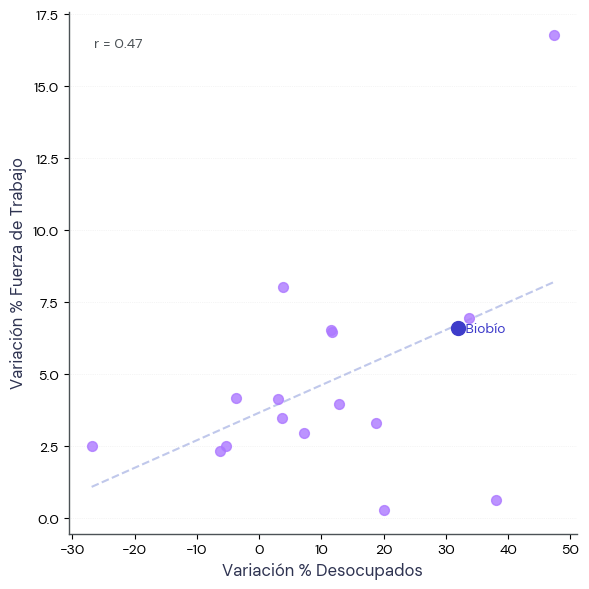

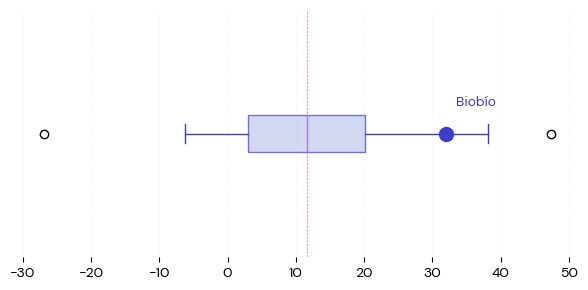

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path

# ─── 1. Registrar DM Sans ───────────────────────────────────────────────────
font_path = Path("/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf")
if not font_path.exists():
    raise FileNotFoundError(f"No encontré la fuente en {font_path}")
fm.fontManager.addfont(str(font_path))
dm_font      = fm.FontProperties(fname=str(font_path))
dm_font_bold = fm.FontProperties(fname=str(font_path), weight="bold")
dm_name      = dm_font.get_name()

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": [dm_name, "DejaVu Sans"],
    "figure.facecolor": "white",
    "axes.facecolor":   "white"
})

# ─── 2. Paleta institucional y ruta ──────────────────────────────────────────
PALETTE    = ["#4c5256","#2e3351","#161233","#3e3cca","#c0c8eb","#798dbf","#ac78ff","#48aee8"]
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")

# ─── 3. Leer y pivotar ───────────────────────────────────────────────────────
df = pd.read_excel(PANEL_PATH, sheet_name="panel_data")
df = df[df["Periodo"].isin(["2023Q1","2025Q1"])].copy()
df["region_name"] = df["region_name"].str.replace("’","'").str.strip()

# armar series de desocupados y fuerza
unemp = df.set_index(["region_name","Periodo"])["PDO_TOT_indicadoresprincipales"].unstack()
work  = df.set_index(["region_name","Periodo"])["FT_TOT_indicadoresprincipales"].unstack()

# calcular % Δ
gdf = pd.DataFrame({
    "region":    unemp.index,
    "Δ_desocup": (unemp["2025Q1"] - unemp["2023Q1"]) / unemp["2023Q1"] * 100,
    "Δ_fuerza":  (work ["2025Q1"] - work ["2023Q1"]) / work ["2023Q1"] * 100
}).dropna()

# extraer Biobío
bio = gdf[gdf["region"]=="Biobío"].iloc[0]
others = gdf[gdf["region"]!="Biobío"]

# ─── 4. Scatter + línea de regresión ────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6,6))

# otros
ax.scatter(others["Δ_desocup"], others["Δ_fuerza"],
           color="#AC78FF", s=50, alpha=0.8, zorder=2)

# Biobío
ax.scatter(bio["Δ_desocup"], bio["Δ_fuerza"],
           color=PALETTE[3], s=100, zorder=3)
ax.text(bio["Δ_desocup"], bio["Δ_fuerza"],
        "  Biobío", fontproperties=dm_font_bold,
        color=PALETTE[3], va="center")

# línea de regresión
coef = np.polyfit(gdf["Δ_desocup"], gdf["Δ_fuerza"], 1)
x0, x1 = gdf["Δ_desocup"].min(), gdf["Δ_desocup"].max()
y0, y1 = coef[0]*x0+coef[1], coef[0]*x1+coef[1]
ax.plot([x0,x1], [y0,y1],
        linestyle="--", color="#C0C8EB", linewidth=1.5, zorder=1)

# r en pantalla
r = gdf["Δ_desocup"].corr(gdf["Δ_fuerza"])
ax.text(0.05, 0.95, f"r = {r:.2f}",
        transform=ax.transAxes, fontproperties=dm_font,
        color=PALETTE[0], va="top")

# grilla horizontal
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

# bordes mínimos
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

# etiquetas
ax.set_xlabel("Variación % Desocupados",
              fontproperties=dm_font_bold, color=PALETTE[1], fontsize=12)
ax.set_ylabel("Variación % Fuerza de Trabajo",
              fontproperties=dm_font_bold, color=PALETTE[1], fontsize=12)
ax.tick_params(axis="both", labelsize=10)
for lbl in ax.get_xticklabels()+ax.get_yticklabels():
    lbl.set_fontproperties(dm_font)

plt.tight_layout()
plt.show()


# ─── 5. Boxplot minimalista ─────────────────────────────────────────────────
# ─── 5. Boxplot minimalista ─────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6,3))

data = gdf["Δ_desocup"].dropna()

# Boxplot horizontal
bp = ax.boxplot(
    data, vert=False, patch_artist=True,
    boxprops   =dict(facecolor=PALETTE[4], edgecolor=PALETTE[3], alpha=0.7),
    medianprops=dict(color="#ac78ff", linewidth=1),
    whiskerprops=dict(color=PALETTE[3]),
    capprops   =dict(color=PALETTE[3])
)

# Punto para Biobío
ax.scatter(
    bio["Δ_desocup"], 1,
    color=PALETTE[3], s=100, zorder=2
)

# Desplazamiento horizontal (2% rango) y vertical (0.1 unidad en y)
x_min, x_max = data.min(), data.max()
offset_x = (x_max - x_min) * 0.02  # 2% del rango de X
offset_y = 0.1                     # sobreelevar Y un poco

ax.text(
    bio["Δ_desocup"] + offset_x, 1 + offset_y,
    "Biobío",
    fontproperties=dm_font_bold,
    color=PALETTE[3],
    va="bottom",    # alineado por abajo
    ha="left"
)

# Línea punteada de la mediana
med = np.median(data)
ax.axvline(med, color="#ac78ff", linestyle="--", linewidth=0.5)

# Ejes limpios
ax.set_yticks([])
ax.xaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)

for spine in ["top","right","left","bottom"]:
    ax.spines[spine].set_visible(False)

# Ticks en DM Sans
ax.tick_params(axis="x", labelsize=10)
for lbl in ax.get_xticklabels():
    lbl.set_fontproperties(dm_font)

plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path

# ─── 1. Registrar DM Sans ────────────────────────────────────────────────────
font_path = Path("/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf")
fm.fontManager.addfont(str(font_path))
dm_prop = fm.FontProperties(fname=str(font_path))
dm_name = dm_prop.get_name()
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": [dm_name]
})

# ─── 2. Paleta institucional ─────────────────────────────────────────────────
PALETTE = ["#4c5256", "#2e3351", "#161233", "#3e3cca",
           "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8"]

# ─── 3. Cargar los datos ──────────────────────────────────────────────────────
PANEL = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
df = pd.read_excel(PANEL, sheet_name="panel_data")
# convertir a PeriodIndex (ya deberías tenerlo, si no):
df["Periodo"] = pd.PeriodIndex(df["Periodo"].astype(str), freq="Q")

# ─── 4. Filtrar sólo Q1 y a partir de 2018 Q1 ─────────────────────────────────
#    (suponiendo que quieres sólo el primer trimestre de cada año)
q1 = df[df["Periodo"].dt.quarter == 1]
q1 = q1[q1["Periodo"] >= pd.Period("2018Q1")]

# ─── 5. Pivot para tener cada variable en columnas, para Biobío ───────────────
vars_ = [
    "PET_indicadoresprincipales",
    "FT_TOT_indicadoresprincipales",
    "PO_TOT_indicadoresprincipales",
    "PDO_TOT_indicadoresprincipales",
    "FFT_TOT_indicadoresprincipales"
]
bio = (q1[q1["region_name"] == "Biobío"]
       .set_index("Periodo")[vars_]
       .sort_index())

# ─── 6. Rebasear a 100 en 2018Q1 ──────────────────────────────────────────────
base = bio.loc[pd.Period("2018Q1")]
idx = bio.div(base).mul(100)

# ─── 7. Gráfico minimalista ──────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8,4))

for i, var in enumerate(vars_):
    ax.plot(
        idx.index.to_timestamp(),
        idx[var],
        lw=2,
        color=PALETTE[3+i],  # vas rotando colores de tu paleta
        label={
            "PET_indicadoresprincipales": "PET",
            "FT_TOT_indicadoresprincipales": "FT",
            "PO_TOT_indicadoresprincipales": "PO",
            "PDO_TOT_indicadoresprincipales":"PDO",
            "FFT_TOT_indicadoresprincipales":"FFT",
        }[var]
    )

# ─── 8. Ejes y estilo minimalista ────────────────────────────────────────────
ax.set_xlim(pd.Timestamp("2018-01-01"), pd.Timestamp("2025-01-01"))
ax.set_ylim(idx.min().min()*0.98, idx.max().max()*1.02)

# Líneas de rejilla sólo horizontal
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

# Bordes: sólo izquierdo y inferior
for sp in ["top","right"]:
    ax.spines[sp].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])

# Ticks y labels en DM Sans
ax.tick_params(axis="both", labelsize=10)
for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    lbl.set_fontproperties(dm_prop)

ax.set_ylabel("Índice (2018Q1 = 100)", fontsize=11, fontproperties=dm_prop)
ax.set_xlabel("")  # sin label en X

# Leyenda minimalista arriba
ax.legend(frameon=False, loc="upper left", prop=dm_prop, ncol=5)

plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf'

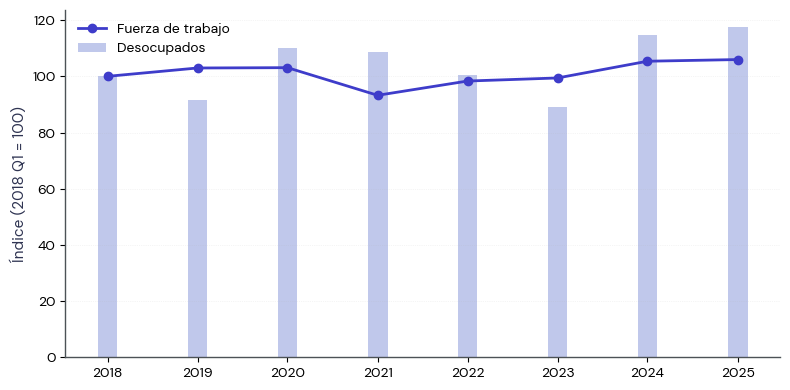

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
from pathlib import Path

# ─── 1. Registrar DM Sans ─────────────────────────────────────────────────────
font_path = Path("/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf")
fm.fontManager.addfont(str(font_path))
dm_prop      = fm.FontProperties(fname=str(font_path))
dm_prop_bold = fm.FontProperties(fname=str(font_path), weight="bold")
dm_name = dm_prop.get_name()
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": [dm_name, "DejaVu Sans"],
})

# ─── 2. Paleta institucional ─────────────────────────────────────────────────
PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",
]

# ─── 3. Cargar datos y rehacer Periodo como PeriodIndex ──────────────────────
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
df = pd.read_excel(PANEL_PATH, sheet_name="panel_data")

# convertir el string "2018Q1" → Periodo periódico
df["Periodo"] = pd.PeriodIndex(df["Periodo"].astype(str), freq="Q")

# filtrar sólo Q1 a partir de 2018
df_q1 = df[
    (df["Periodo"].dt.quarter == 1) &
    (df["Periodo"].dt.year >= 2018)
].copy()

# sacar las series de Biobío
unemp = df_q1.pivot(index="Periodo", columns="region_name", values="PDO_TOT_indicadoresprincipales")
work  = df_q1.pivot(index="Periodo", columns="region_name", values="FT_TOT_indicadoresprincipales")

ser_u = unemp["Biobío"]
ser_w = work ["Biobío"]

# índice base 2018Q1 = 100
base_u = ser_u.loc[pd.Period("2018Q1", freq="Q")]
base_w = ser_w.loc[pd.Period("2018Q1", freq="Q")]
idx_u  = ser_u / base_u * 100
idx_w  = ser_w / base_w * 100

# ─── 4. Dibujar combinado ─────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8,4))

x = idx_u.index.to_timestamp()  # fechas para eje X

# barras para desocupados
ax.bar(
    x, idx_u,
    width=80,
    color=PALETTE[4],
    edgecolor="none",
    label="Desocupados"
)

# línea para fuerza de trabajo
ax.plot(
    x, idx_w,
    marker="o",
    linewidth=2,
    color=PALETTE[3],
    label="Fuerza de trabajo"
)

# ─── 5. Estilo minimalista ────────────────────────────────────────────────────
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

ax.set_ylabel("Índice (2018 Q1 = 100)",
              fontproperties=dm_prop_bold,
              color=PALETTE[1],
              fontsize=11)
ax.tick_params(axis="both", labelsize=10)
for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    lbl.set_fontproperties(dm_prop)

ax.legend(frameon=False, prop=dm_prop, fontsize=10, loc="upper left")

plt.tight_layout()
plt.show()


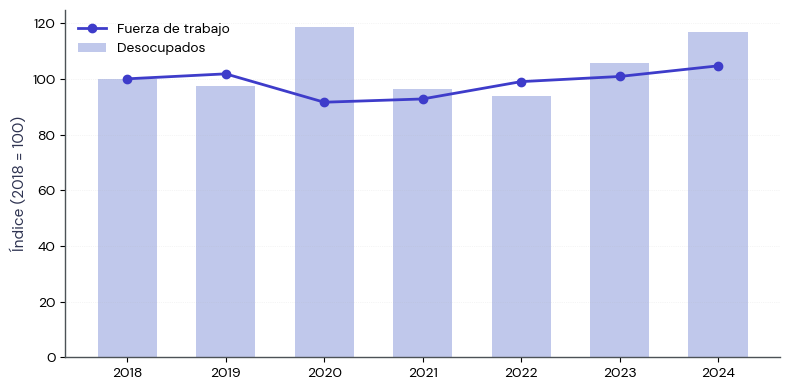

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
from pathlib import Path

# ─── 1. Registrar fuente DM Sans ─────────────────────────────────────────────
font_path = Path("/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf")
fm.fontManager.addfont(str(font_path))
dm_prop      = fm.FontProperties(fname=str(font_path))
dm_prop_bold = fm.FontProperties(fname=str(font_path), weight="bold")
dm_name = dm_prop.get_name()
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": [dm_name, "DejaVu Sans"],
})

# ─── 2. Paleta institucional ─────────────────────────────────────────────────
PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",
]

# ─── 3. Cargar datos y convertir Periodo ─────────────────────────────────────
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
df = pd.read_excel(PANEL_PATH, sheet_name="panel_data")
df["Periodo"] = pd.PeriodIndex(df["Periodo"].astype(str), freq="Q")
df["Año"] = df["Periodo"].dt.year

# ─── 4. Filtrar Biobío y desde 2018 hasta 2024 ─────────────────────────────────
df_bio = df[(df["region_name"] == "Biobío") & (df["Año"] >= 2018) & (df["Año"] <= 2024)].copy()


# ─── 5. Calcular promedios anuales ───────────────────────────────────────────
unemp_annual = df_bio.groupby("Año")["PDO_TOT_indicadoresprincipales"].mean()
work_annual  = df_bio.groupby("Año")["FT_TOT_indicadoresprincipales"].mean()

# ─── 6. Índices base 2018 = 100 ──────────────────────────────────────────────
base_u = unemp_annual.loc[2018]
base_w = work_annual.loc[2018]
idx_u = unemp_annual / base_u * 100
idx_w = work_annual / base_w * 100

# ─── 7. Dibujar gráfico combinado ────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 4))
x = idx_u.index.astype(str)

# Barras: Desocupados
ax.bar(
    x, idx_u,
    width=0.6,
    color=PALETTE[4],
    edgecolor="none",
    label="Desocupados"
)

# Línea: Fuerza de trabajo
ax.plot(
    x, idx_w,
    marker="o",
    linewidth=2,
    color=PALETTE[3],
    label="Fuerza de trabajo"
)

# ─── 8. Estilo minimalista ───────────────────────────────────────────────────
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

ax.set_ylabel("Índice (2018 = 100)",
              fontproperties=dm_prop_bold,
              color=PALETTE[1],
              fontsize=11)

ax.tick_params(axis="both", labelsize=10)
for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    lbl.set_fontproperties(dm_prop)

ax.legend(frameon=False, prop=dm_prop, fontsize=10, loc="upper left")

plt.tight_layout()
plt.show()


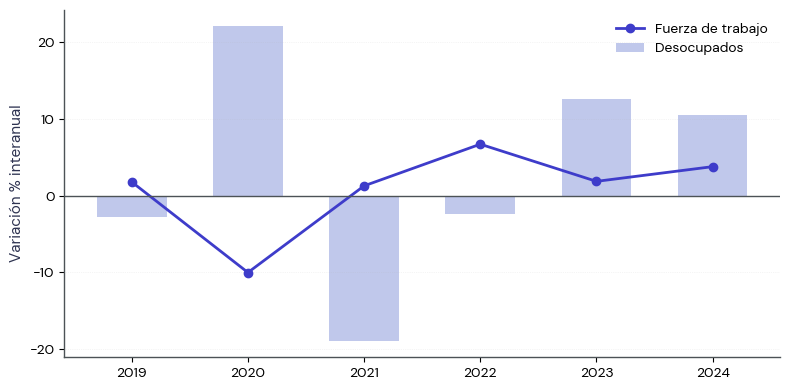

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
from pathlib import Path

# ─── 1. Registrar fuente DM Sans ─────────────────────────────────────────────
font_path = Path("/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf")
fm.fontManager.addfont(str(font_path))
dm_prop      = fm.FontProperties(fname=str(font_path))
dm_prop_bold = fm.FontProperties(fname=str(font_path), weight="bold")
dm_name = dm_prop.get_name()
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": [dm_name, "DejaVu Sans"],
})

# ─── 2. Paleta institucional ─────────────────────────────────────────────────
PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",
]

# ─── 3. Cargar datos y preparar ──────────────────────────────────────────────
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
df = pd.read_excel(PANEL_PATH, sheet_name="panel_data")
df["Periodo"] = pd.PeriodIndex(df["Periodo"].astype(str), freq="Q")
df["Año"] = df["Periodo"].dt.year

# ─── 4. Filtrar Biobío y desde 2018 ──────────────────────────────────────────
df_bio = df[(df["region_name"] == "Biobío") & (df["Año"] >= 2018) & (df["Año"] <= 2024)].copy()

# ─── 5. Calcular promedios anuales ───────────────────────────────────────────
unemp_annual = df_bio.groupby("Año")["PDO_TOT_indicadoresprincipales"].mean()
work_annual  = df_bio.groupby("Año")["FT_TOT_indicadoresprincipales"].mean()

# ─── 6. Calcular variaciones % interanuales ──────────────────────────────────
var_u = unemp_annual.pct_change() * 100
var_w = work_annual.pct_change() * 100

# ─── 7. Graficar variación % ─────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 4))
x = var_u.index.astype(str)

# Barras: variación % desocupados
ax.bar(
    x, var_u,
    width=0.6,
    color=PALETTE[4],
    edgecolor="none",
    label="Desocupados"
)

# Línea: variación % fuerza de trabajo
ax.plot(
    x, var_w,
    marker="o",
    linewidth=2,
    color=PALETTE[3],
    label="Fuerza de trabajo"
)

# Línea base cero
ax.axhline(0, color=PALETTE[0], linewidth=1, linestyle="-")

# ─── 8. Estilo gráfico ───────────────────────────────────────────────────────
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

ax.set_ylabel("Variación % interanual",
              fontproperties=dm_prop_bold,
              color=PALETTE[1],
              fontsize=11)

ax.tick_params(axis="both", labelsize=10)
for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    lbl.set_fontproperties(dm_prop)

ax.legend(
    frameon=False,
    prop=dm_prop,
    fontsize=10,
    loc="upper right"
)


plt.tight_layout()
plt.show()


# Mapas de calor


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
from pathlib import Path
import matplotlib.font_manager as fm
import numpy as np

# ─── 1. Rutas y carga ────────────────────────────────────────────────────────
shp_path = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/shp_regiones/Regional.shp")
xls_path = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")

gdf = gpd.read_file(shp_path)
df = pd.read_excel(xls_path, sheet_name='panel_data')
df = df[(df['Periodo'] == '2025Q1') & (~df['region_name'].isin(['Nacional']))]

# ─── 2. Eliminar comillas para asegurar match de nombres ─────────────────────
def quitar_comillas(s):
    if isinstance(s, str):
        return s.replace("'", "").replace("’", "").replace("‘", "").replace("`", "").strip()
    return s

df['region_name'] = df['region_name'].apply(quitar_comillas)
gdf['Region'] = gdf['Region'].apply(quitar_comillas)

# ─── 3. Verificar nombres únicos y crear mapeo ──────────────────────────────

# Diccionario de mapeo actualizado
mapeo = {
    'Antofagasta': 'Región de Antofagasta',
    'Araucanía': 'Región de La Araucanía',
    'Arica y Parinacota': 'Región de Arica y Parinacota',
    'Atacama': 'Región de Atacama',
    'Aysén': 'Región de Aysén del Gral.Ibañez del Campo',
    'Biobío': 'Región del Bío-Bío',
    'Coquimbo': 'Región de Coquimbo',
    'Los Lagos': 'Región de Los Lagos',
    'Los Ríos': 'Región de Los Ríos',
    'Magallanes': 'Región de Magallanes y Antártica Chilena',
    'Maule': 'Región del Maule',
    'OHiggins': 'Región del Libertador Bernardo OHiggins',
    'Región Metropolitana': 'Región Metropolitana de Santiago',
    'Tarapacá': 'Región de Tarapacá',
    'Valparaíso': 'Región de Valparaíso',
    'Ñuble': 'Región de Ñuble'
}

df['region_shp'] = df['region_name'].map(mapeo)


df_grouped = df.groupby('region_shp')['T_TDO_indicadoresprincipales'].mean().reset_index(name='tasa_desocupacion')
gdf = gdf.merge(df_grouped, left_on='Region', right_on='region_shp', how='left')

gdf[gdf["Region"].str.contains("Magallanes")]


regiones_con_datos = set(df_grouped['region_shp'].unique())
regiones_shp = set(gdf['Region'].unique())
sin_datos = regiones_shp - regiones_con_datos
print(sin_datos)


gdf = gdf[gdf['Region'] != 'Zona sin demarcar']


regiones_na = gdf[gdf['tasa_desocupacion'].isna()]['Region'].tolist()

# ─── 4. Cargar fuente DM Sans (opcional) ─────────────────────────────────────
try:
    font_path = "/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf"
    fm.fontManager.addfont(font_path)
    dm_font = fm.FontProperties(fname=font_path)
except:
    dm_font = None

# ─── 5. Paleta continua: blanco a azul institucional ─────────────────────────
cmap = LinearSegmentedColormap.from_list("degrade_continuo", [
    "#ffffff",  # claro para valores bajos
    "#3e3cca"   # azul institucional para valores altos
], N=256)

# ─── 6. Crear figura simple ──────────────────────────────────────────────────
fig, ax_map = plt.subplots(figsize=(12, 16))

# Crear el mapa
im = gdf.plot(
    column='tasa_desocupacion',
    cmap=cmap,
    linewidth=0.2,
    edgecolor='white',
    ax=ax_map,
    legend=False,
    vmin=gdf['tasa_desocupacion'].min(),
    vmax=gdf['tasa_desocupacion'].max(),
    missing_kwds={"color": "#e8e8e8", "edgecolor": "white", "linewidth": 0.8}
)

# ─── 7. Añadir rectángulo sobre el Biobío ───────────────────────────────────
try:
    row_bio = gdf[gdf['region_shp'] == 'Región del Bío-Bío'].iloc[0]
    bounds = row_bio.geometry.bounds
    x_center = (bounds[0] + bounds[2]) / 2
    y_center = (bounds[1] + bounds[3]) / 2
    width = (bounds[2] - bounds[0]) * 1.1
    height = (bounds[3] - bounds[1]) * 1.1

    ax_map.add_patch(Rectangle(
        (x_center - width/2, y_center - height/2), width, height,
        facecolor='none',
        edgecolor='#C0C8EB',
        linewidth=3,
        zorder=5
    ))
except:
    print("No se pudo encontrar la región del Biobío")

# ─── 8. Crear barra minimalista y compacta ──────────────────────────────────
# Calcular rangos
min_val = gdf['tasa_desocupacion'].min()
max_val = gdf['tasa_desocupacion'].max()

# Posición de la barra - más pequeña y centrada
bar_x = 1.2     # posición horizontal
bar_y = 0.4       # centrada verticalmente
bar_width = 0.02  # más delgada
bar_height = 0.25 # solo 25% del alto total (minimalista)

# Crear la barra gradiente compacta
bar_ax = fig.add_axes([bar_x, bar_y, bar_width, bar_height])
gradient = np.linspace(0, 1, 256).reshape(256, -1)
bar_ax.imshow(gradient, aspect='auto', cmap=cmap, extent=[0, 1, min_val, max_val])

# Configurar la barra
bar_ax.set_xlim(0, 1)
bar_ax.set_ylim(min_val, max_val)
bar_ax.set_xticks([])

# Solo 3 etiquetas (mínimo, medio, máximo) - súper minimalista
tick_values = [min_val, (min_val + max_val) / 2, max_val]
tick_labels = [f'{val:.1f}%' for val in tick_values]

bar_ax.set_yticks(tick_values)
bar_ax.set_yticklabels(tick_labels, fontsize=9,
                       fontproperties=dm_font if dm_font else None)
bar_ax.tick_params(axis='y', length=0, pad=8)

# Quitar todos los bordes
for spine in bar_ax.spines.values():
    spine.set_visible(False)

# ─── 9. Configurar mapa principal ────────────────────────────────────────────
ax_map.set_axis_off()

# Ajustar layout
# plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

plt.show()

# Provincias BioBío


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ================= 1. LIBRERÍAS Y RUTA ========================================
from pathlib import Path
import pandas as pd
import re

ROOT = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio")
ORIG_DIR = ROOT / "Datos_ENE_provincias"
CLEAN_DIR = ROOT / "Datos_ENE_limpios_provincias"
CLEAN_DIR.mkdir(parents=True, exist_ok=True)

MAP_FILE = ROOT / "resultados/variables_por_base.xlsx"
MAP_SHEET = 0

# ================= 2. DICCIONARIO DE ABREVIATURAS =====================
def load_abbreviations() -> dict:
    df_map = (
        pd.read_excel(MAP_FILE, sheet_name=MAP_SHEET, usecols="A:C")
        .rename(columns=str.lower)
        .dropna()
    )
    df_map["base"] = (
        df_map["base"].str.strip().str.replace(".xlsx", "", regex=False).str.lower()
    )
    df_map["var_original"] = df_map["var_original"].str.strip()
    df_map["abreviatura"] = df_map["abreviatura"].str.strip()
    return {(r.base, r.var_original): r.abreviatura for r in df_map.itertuples()}

# ================= 4. HOJAS A CONSERVAR ================================
ID_VARS = ["Año", "Trimestre"]
HOJAS_OBJETIVO = {
    "081",
    "082",
    "083",
}

# ================= 5. CONVERSIÓN NÚMEROS CORREGIDA =======================

def texto_a_numero(valor: str):
    """Convierte correctamente comas decimales a float."""
    if pd.isna(valor):
        return None

    texto = str(valor).strip()

    # Si es un guión, vacío, o 'b', retornar None
    if not texto or texto in ['-', 'b']:
        return None

    # Solo cambiar coma por punto para decimales
    # 898,82 → 898.82 (NO 898820)
    texto_convertido = texto.replace(',', '.')

    try:
        return float(texto_convertido)
    except ValueError:
        return None

# ================= 6. LIMPIADOR DE HOJAS ===============================

# ================= 6. LIMPIADOR DE HOJAS ===============================
def limpiar_hoja(df: pd.DataFrame, base_alias: str, abbr: dict) -> pd.DataFrame:
    df = df.copy()
    df.columns = df.columns.str.strip()
    columnas_a_borrar = []
    renombres = {}
    columnas = list(df.columns)

    for i, col in enumerate(columnas):
        if col in ID_VARS or "Unnamed" not in col:
            continue
        anterior = columnas[i - 1].strip() if i > 0 else ""
        if anterior in ID_VARS or not anterior:
            columnas_a_borrar.append(col)
            continue
        alias = abbr.get((base_alias, anterior))
        if alias:
            renombres[col] = f"{alias}_{base_alias}"
        else:
            columnas_a_borrar.append(col)

    df = df.drop(columns=columnas_a_borrar, errors="ignore").rename(columns=renombres)
    df = df[df[ID_VARS[0]].notna() | df[ID_VARS[1]].notna()].reset_index(drop=True)

    # ================= MAPEADO Y NORMALIZACIÓN DE TRIMESTRES =================
    quarter_map = {
        "1": "Ene - Mar",
        "2": "Abr - Jun",
        "3": "Jul - Sep",
        "4": "Oct - Dic",
        "ene-mar": "Ene - Mar",
        "abr-jun": "Abr - Jun",
        "jul-sep": "Jul - Sep",
        "oct-dic": "Oct - Dic",
        "ene - mar": "Ene - Mar",
        "abr - jun": "Abr - Jun",
        "jul - sep": "Jul - Sep",
        "oct - dic": "Oct - Dic",
        "feb - abr": "Feb - Abr",
        "mar - may": "Mar - May",
        "may - jul": "May - Jul",
        "jun - ago": "Jun - Ago",
        "ago - oct": "Ago - Oct",
        "sep - nov": "Sep - Nov",
        "nov - ene": "Nov - Ene",
        "dic - feb": "Dic - Feb",
    }

    # Normalizar trimestres con una sola capitalización
    df["Trimestre"] = df["Trimestre"].str.strip().str.lower()

    # Mapear trimestres usando el mapeo más exhaustivo
    df["Trimestre"] = df["Trimestre"].replace(quarter_map)

    # Convertir el año a numérico
    df["Año"] = pd.to_numeric(df["Año"], errors="coerce")

    for col in renombres.values():
        df[col] = df[col].apply(texto_a_numero)

    return df[[*ID_VARS, *renombres.values()]]

# ================= 7. PROCESAR ARCHIVOS =================================
def procesar_archivos():
    abbr = load_abbreviations()
    for src in ORIG_DIR.glob("*.xlsx"):
        base_alias = src.stem.split("_")[0].lower()
        dest = CLEAN_DIR / f"{base_alias}_limpia.xlsx"
        if dest.exists():
            print(f"↻  Reemplazando {dest.name}")
        else:
            print(f"→ Procesando {src.name} (base={base_alias})")
        xls = pd.ExcelFile(src)
        with pd.ExcelWriter(dest, engine="openpyxl") as xlw:
            hojas_guardadas = 0
            for hoja in xls.sheet_names:
                if hoja not in HOJAS_OBJETIVO:
                    continue
                try:
                    # CAMBIO: usar header=6 en lugar de header=5
                    raw = xls.parse(hoja, header=5, dtype=str)
                    limpio = limpiar_hoja(raw, base_alias, abbr)
                    if not limpio.empty:
                        limpio.to_excel(xlw, sheet_name=hoja, index=False)
                        hojas_guardadas += 1
                except Exception as e:
                    print(f"⚠️ Error en hoja '{hoja}': {e}")
            if hojas_guardadas == 0:
                print(f"⚠️ Ninguna hoja válida guardada en {src.name}")
    print("\n✅ Limpieza completada. Archivos en:", CLEAN_DIR)

if __name__ == "__main__":
    procesar_archivos()

↻  Reemplazando provincias_limpia.xlsx

✅ Limpieza completada. Archivos en: /content/drive/MyDrive/Data/Mercado_Laboral/Biobio/Datos_ENE_limpios_provincias


In [ ]:
# ================= 1. LIBRERÍAS Y RUTA ========================================
from pathlib import Path
import pandas as pd

ROOT = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio")
CLEAN_DIR = ROOT / "Datos_ENE_limpios_provincias"
PANEL_FILE = ROOT / "resultados" / "panel_provincias.xlsx"

TRIM_OK = {"Ene - Mar", "Abr - Jun", "Jul - Sep", "Oct - Dic"}
MAPA_PROVINCIAS = {
    "081": "Concepción",
    "082": "Arauco",
    "083": "Biobío",
}
PROVINCIAS = set(MAPA_PROVINCIAS.keys())
ID_VARS = ["Año", "Trimestre", "provincia_code", "provincia_name"]
TRIM_MAP = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}

# ================= 2. CARGAR BASE DE DATOS ===========================
def cargar_base_provincias(path: Path) -> pd.DataFrame:
    xls = pd.ExcelFile(path)
    registros = []
    for hoja in xls.sheet_names:
        if hoja not in PROVINCIAS:
            continue
        df = pd.read_excel(xls, sheet_name=hoja)
        df = df[df["Trimestre"].isin(TRIM_OK)].copy()
        df["provincia_code"] = hoja
        df["provincia_name"] = MAPA_PROVINCIAS[hoja]
        registros.append(df)
    if registros:
        return pd.concat(registros, ignore_index=True)
    return pd.DataFrame(columns=ID_VARS)

# ================= 3. CONSTRUCCIÓN DEL PANEL ===========================
def construir_panel():
    panel = None
    for archivo in CLEAN_DIR.glob("*_limpia.xlsx"):
        df_base = cargar_base_provincias(archivo)
        if df_base.empty:
            continue
        if panel is None:
            panel = df_base
        else:
            panel = pd.merge(panel, df_base, on=ID_VARS, how="outer")

    if panel is None:
        print("No se encontraron archivos limpios")
        return

    # Convertir Trimestre a formato numérico
    panel["Trimestre_num"] = panel["Trimestre"].map(TRIM_MAP)

    # Ordenar y limpiar el panel
    panel = (
        panel.sort_values(
            ["Año", "Trimestre_num", "provincia_code", "provincia_name"]
        )
        .drop(columns="Trimestre_num")
        .reset_index(drop=True)
    )

    # Crear la columna de Periodo como índice
    panel["Periodo"] = pd.PeriodIndex(
        year=panel["Año"],
        quarter=panel["Trimestre"].map(TRIM_MAP),
        freq="Q",
    )
    panel["Fecha"] = panel["Periodo"].dt.start_time

    # Guardar el panel en el archivo de salida
    PANEL_FILE.parent.mkdir(parents=True, exist_ok=True)
    if PANEL_FILE.exists():
        print(f"↻  Reemplazando {PANEL_FILE.name}")

    panel.to_excel(PANEL_FILE, index=False, sheet_name="panel_data")
    print("✅ Panel construido y guardado en:", PANEL_FILE)

if __name__ == "__main__":
    construir_panel()


/tmp/ipython-input-22-687121272.py:64: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  panel["Periodo"] = pd.PeriodIndex(


↻  Reemplazando panel_provincias.xlsx
✅ Panel construido y guardado en: /content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_provincias.xlsx


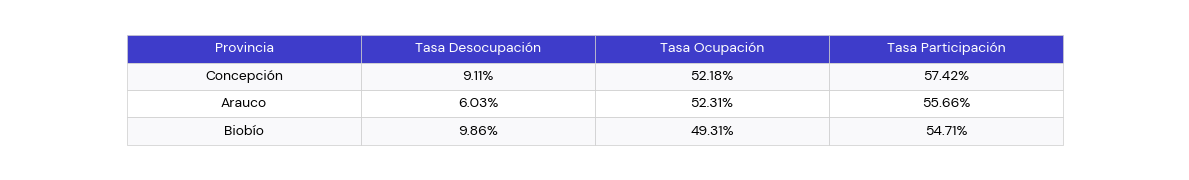

✅ Tabla de tasas para 2025Q1 guardada en /content/tabla_tasas_2025Q1.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path

# ─── 1. Configurar fuente DM Sans ────────────────────────────────────────────
font_path = Path("/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf")
if font_path.exists():
    fm.fontManager.addfont(str(font_path))
    dm_font = fm.FontProperties(fname=str(font_path))
else:
    dm_font = fm.FontProperties()

# ─── 2. Cargar panel y filtrar Q1 2025 ─────────────────────────────
ruta = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_provincias.xlsx")
df = pd.read_excel(ruta, sheet_name="panel_data")
df["provincia_name"] = (
    df["provincia_name"].astype(str)
       .str.replace("’","'")
       .str.strip()
)
df["Periodo"] = df["Periodo"].astype(str)

# Filtrar los datos para 2025Q1
df_2025Q1 = df[df["Periodo"] == "2025Q1"].copy()

# ─── 3. Definir las variables relevantes ─────────────────────────────────────
variables = {
    "T_TDO_provincias": "Tasa Desocupación",
    "T_TO_provincias": "Tasa Ocupación",
    "T_TP_provincias": "Tasa Participación"
}

# ─── 4. Seleccionar solo las columnas necesarias ────────────────────────────
df_tasas = df_2025Q1[["provincia_name"] + list(variables.keys())]

# Eliminar filas con valores NaN en las columnas seleccionadas
df_tasas = df_tasas.dropna(subset=list(variables.keys()))

# Renombrar las columnas para hacerlas más amigables
df_tasas = df_tasas.rename(columns=variables)

# ─── 5. Redondear y formatear las tasas como porcentaje con 1 decimal ───────
for col in list(variables.values()):
    df_tasas[col] = df_tasas[col].apply(lambda x: f"{round(x, 2):.2f}%")

# ─── 6. Crear la tabla para mostrar ────────────────────────────────────────
# Keep the province name as a column instead of index
df_tasas = df_tasas.reset_index(drop=True)

# ─── 7. Dibujar tabla con matplotlib ────────────────────────────────────────
n_rows = len(df_tasas)
fig, ax = plt.subplots(figsize=(12, 1 + 0.3 * n_rows))
ax.axis("off")

col_labels = ["Provincia"] + list(variables.values())
cell_data  = df_tasas.values.tolist()

# Definir los anchos de las columnas para hacerlas más angostas
col_widths = [0.2] * len(col_labels)  # Ajustar el tamaño de las columnas (aquí se hace uniforme para todas)

# Aseguramos que las filas de datos coincidan con las columnas
tabla = ax.table(
    cellText=[col_labels] + cell_data,
    cellLoc="center",
    loc="center",
    colWidths=col_widths  # Ajuste de los anchos de columna
)
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1, 1.5)

for (r, c), cell in tabla.get_celld().items():
    if r == 0:
        cell.set_facecolor("#3E3CCA")
        cell.set_text_props(color="white", weight="bold", fontproperties=dm_font)
    else:
        cell.set_facecolor("#f9f9fb" if r % 2 == 1 else "white")
        cell.set_text_props(fontproperties=dm_font)
    cell.set_edgecolor("#CCCCCC")
    cell.set_linewidth(0.5)

plt.tight_layout()
output_path = Path("/content/tabla_tasas_2025Q1.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

print(f"✅ Tabla de tasas para 2025Q1 guardada en {output_path}")


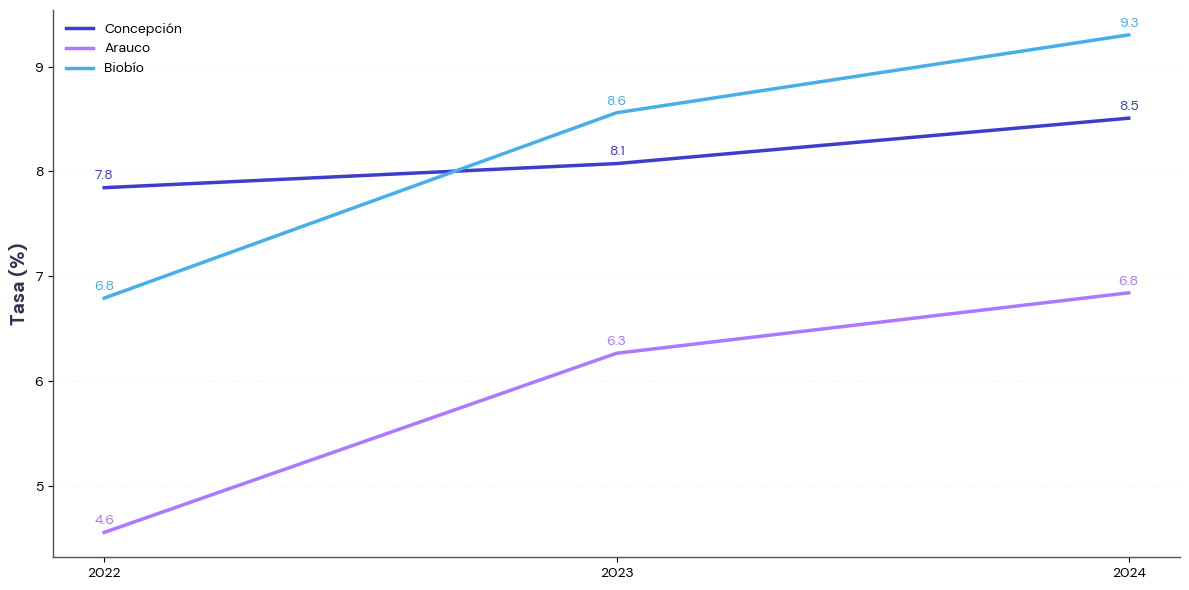

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── Paleta de colores ────────────────────────────────────────────────────────
PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",  # azul institucional
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",  # otros tonos
]

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_provincias.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar las provincias específicas ───────────────────────────────────────
df_concepcion = df[df["provincia_name"] == "Concepción"]
df_arauco = df[df["provincia_name"] == "Arauco"]
df_bio = df[df["provincia_name"] == "Biobío"]

# ─── Filtrar desde 2021Q3 ─────────────────────────────────────────────────────
df_concepcion = df_concepcion[df_concepcion["Fecha"] >= pd.to_datetime("2022-01-01")]
df_arauco = df_arauco[df_arauco["Fecha"] >= pd.to_datetime("2022-01-01")]
df_bio = df_bio[df_bio["Fecha"] >= pd.to_datetime("2022-01-01")]

# ─── Calcular promedio anual ──────────────────────────────────────────────────
df_concepcion_anual = df_concepcion.groupby("Año")["T_TDO_provincias"].mean().reset_index()
df_arauco_anual = df_arauco.groupby("Año")["T_TDO_provincias"].mean().reset_index()
df_bio_anual = df_bio.groupby("Año")["T_TDO_provincias"].mean().reset_index()

df_concepcion_anual = df_concepcion_anual[df_concepcion_anual["Año"] < 2025]
df_arauco_anual = df_arauco_anual[df_arauco_anual["Año"] < 2025]
df_bio_anual = df_bio_anual[df_bio_anual["Año"] < 2025]

# ─── Convertir año a fecha para usar eje temporal ─────────────────────────────
df_concepcion_anual["Fecha"] = pd.to_datetime(df_concepcion_anual["Año"].astype(str) + "-01-01")
df_arauco_anual["Fecha"] = pd.to_datetime(df_arauco_anual["Año"].astype(str) + "-01-01")
df_bio_anual["Fecha"] = pd.to_datetime(df_bio_anual["Año"].astype(str) + "-01-01")

# ─── Crear gráfico ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))

# Líneas de promedio anual
ax.plot(df_concepcion_anual["Fecha"], df_concepcion_anual["T_TDO_provincias"],
        label="Concepción", color=PALETTE[3], linewidth=2.5)
ax.plot(df_arauco_anual["Fecha"], df_arauco_anual["T_TDO_provincias"],
        label="Arauco", color=PALETTE[6], linewidth=2.5)
ax.plot(df_bio_anual["Fecha"], df_bio_anual["T_TDO_provincias"],
        label="Biobío", color=PALETTE[7], linewidth=2.5)

# Agregar valores sobre las líneas y mover un poco más arriba
for i, row in df_concepcion_anual.iterrows():
    ax.text(row["Fecha"], row["T_TDO_provincias"] + 0.05, f"{row['T_TDO_provincias']:.1f}",
            color=PALETTE[3], ha='center', va='bottom', fontsize=10)
for i, row in df_arauco_anual.iterrows():
    ax.text(row["Fecha"], row["T_TDO_provincias"] + 0.05, f"{row['T_TDO_provincias']:.1f}",
            color=PALETTE[6], ha='center', va='bottom', fontsize=10)
for i, row in df_bio_anual.iterrows():
    ax.text(row["Fecha"], row["T_TDO_provincias"] + 0.05, f"{row['T_TDO_provincias']:.1f}",
            color=PALETTE[7], ha='center', va='bottom', fontsize=10)

# Ejes y formato
ax.set_ylabel("Tasa (%)", fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])

ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font)

ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

ax.legend(frameon=False, loc="upper left", fontsize=12, prop=dm_font)

plt.tight_layout()
plt.show()


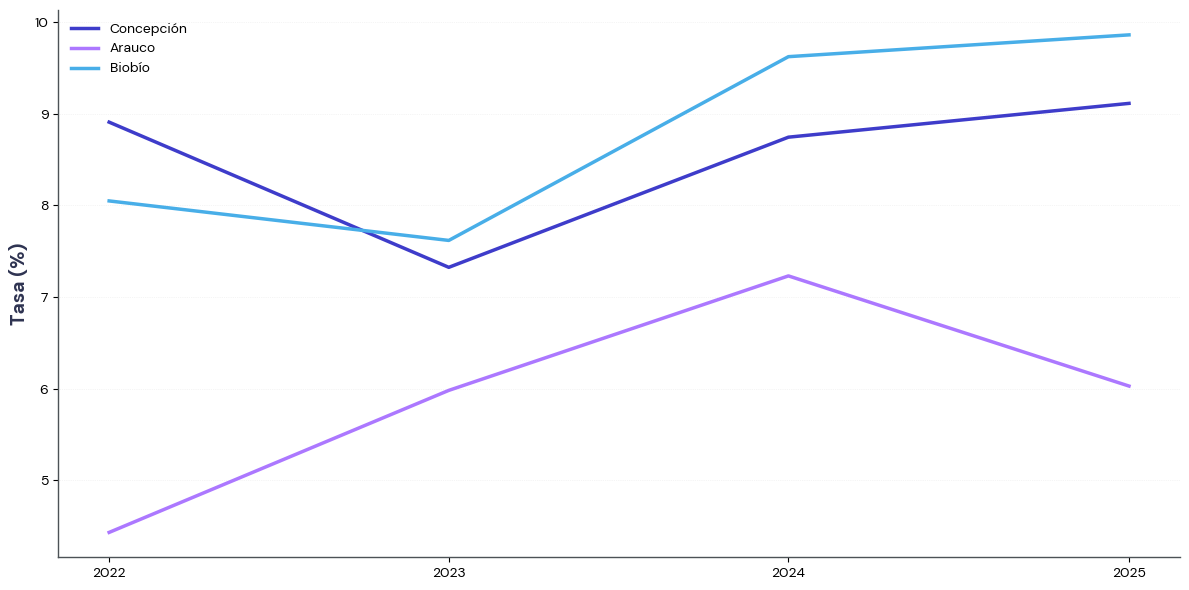

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── Paleta de colores ────────────────────────────────────────────────────────
PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",  # azul institucional
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",  # otros tonos
]

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_provincias.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Crear la columna Trimestre ───────────────────────────────────────────────
df["Trimestre"] = df["Fecha"].dt.month.map({
    1: "Ene - Mar", 2: "Ene - Mar", 3: "Ene - Mar",
    4: "Abr - Jun", 5: "Abr - Jun", 6: "Abr - Jun",
    7: "Jul - Sep", 8: "Jul - Sep", 9: "Jul - Sep",
    10: "Oct - Dic", 11: "Oct - Dic", 12: "Oct - Dic"
})

# ─── Filtrar desde 2022 y solo para el trimestre "Ene - Mar" ───────────────────
df_concepcion = df[(df["provincia_name"] == "Concepción") &
                   (df["Fecha"] >= pd.to_datetime("2022-01-01")) &
                   (df["Trimestre"] == "Ene - Mar")]

df_arauco = df[(df["provincia_name"] == "Arauco") &
               (df["Fecha"] >= pd.to_datetime("2022-01-01")) &
               (df["Trimestre"] == "Ene - Mar")]

df_bio = df[(df["provincia_name"] == "Biobío") &
            (df["Fecha"] >= pd.to_datetime("2022-01-01")) &
            (df["Trimestre"] == "Ene - Mar")]

# ─── Crear gráfico ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))

# Líneas de datos trimestrales
ax.plot(df_concepcion["Fecha"], df_concepcion["T_TDO_provincias"],
        label="Concepción", color=PALETTE[3], linewidth=2.5)
ax.plot(df_arauco["Fecha"], df_arauco["T_TDO_provincias"],
        label="Arauco", color=PALETTE[6], linewidth=2.5)
ax.plot(df_bio["Fecha"], df_bio["T_TDO_provincias"],
        label="Biobío", color=PALETTE[7], linewidth=2.5)

# Ejes y formato
ax.set_ylabel("Tasa (%)", fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])

ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font)

ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

ax.legend(frameon=False, loc="upper left", fontsize=12, prop=dm_font)

plt.tight_layout()
plt.show()


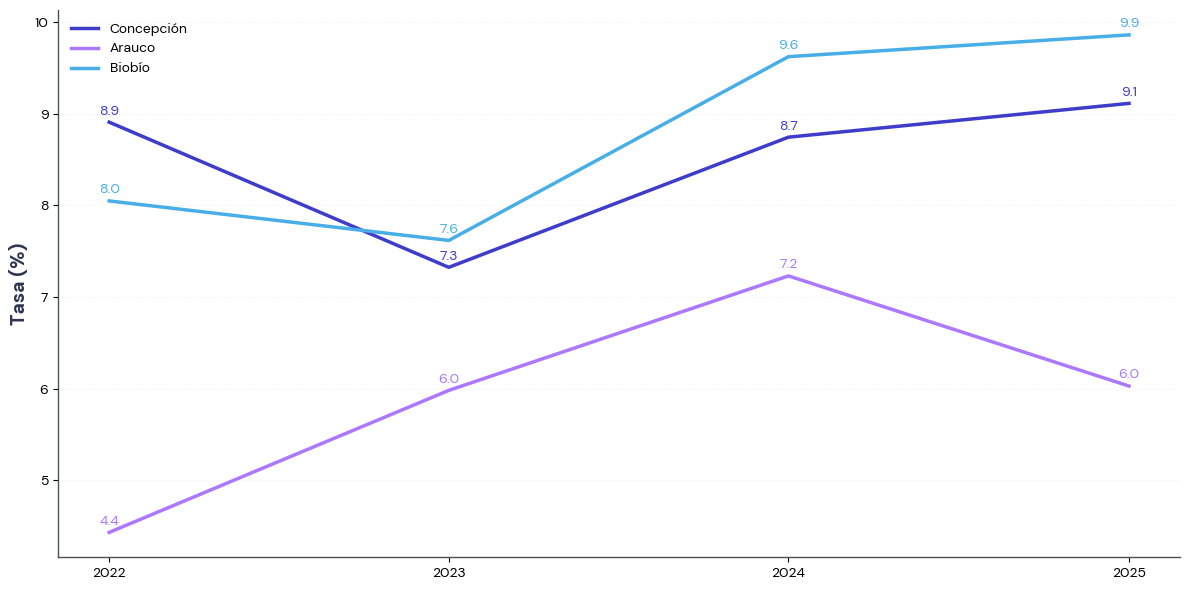

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── Paleta de colores ────────────────────────────────────────────────────────
PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",  # azul institucional
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",  # otros tonos
]

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_provincias.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Crear la columna Trimestre ───────────────────────────────────────────────
df["Trimestre"] = df["Fecha"].dt.month.map({
    1: "Ene - Mar", 2: "Ene - Mar", 3: "Ene - Mar",
    4: "Abr - Jun", 5: "Abr - Jun", 6: "Abr - Jun",
    7: "Jul - Sep", 8: "Jul - Sep", 9: "Jul - Sep",
    10: "Oct - Dic", 11: "Oct - Dic", 12: "Oct - Dic"
})

# ─── Filtrar desde 2022 y solo para el trimestre "Ene - Mar" ───────────────────
df_concepcion = df[(df["provincia_name"] == "Concepción") &
                   (df["Fecha"] >= pd.to_datetime("2022-01-01")) &
                   (df["Trimestre"] == "Ene - Mar")]

df_arauco = df[(df["provincia_name"] == "Arauco") &
               (df["Fecha"] >= pd.to_datetime("2022-01-01")) &
               (df["Trimestre"] == "Ene - Mar")]

df_bio = df[(df["provincia_name"] == "Biobío") &
            (df["Fecha"] >= pd.to_datetime("2022-01-01")) &
            (df["Trimestre"] == "Ene - Mar")]

# ─── Crear gráfico ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))

# Líneas de datos trimestrales
ax.plot(df_concepcion["Fecha"], df_concepcion["T_TDO_provincias"],
        label="Concepción", color=PALETTE[3], linewidth=2.5)
ax.plot(df_arauco["Fecha"], df_arauco["T_TDO_provincias"],
        label="Arauco", color=PALETTE[6], linewidth=2.5)
ax.plot(df_bio["Fecha"], df_bio["T_TDO_provincias"],
        label="Biobío", color=PALETTE[7], linewidth=2.5)

# Agregar valores sobre las líneas con 1 decimal y un desplazamiento de 0.5
for i, row in df_concepcion.iterrows():
    ax.text(row["Fecha"], row["T_TDO_provincias"] + 0.05, f"{row['T_TDO_provincias']:.1f}",
            color=PALETTE[3], ha='center', va='bottom', fontsize=10)

for i, row in df_arauco.iterrows():
    ax.text(row["Fecha"], row["T_TDO_provincias"] + 0.05, f"{row['T_TDO_provincias']:.1f}",
            color=PALETTE[6], ha='center', va='bottom', fontsize=10)

for i, row in df_bio.iterrows():
    ax.text(row["Fecha"], row["T_TDO_provincias"] + 0.05, f"{row['T_TDO_provincias']:.1f}",
            color=PALETTE[7], ha='center', va='bottom', fontsize=10)

# Ejes y formato
ax.set_ylabel("Tasa (%)", fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])

ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font)

ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

ax.legend(frameon=False, loc="upper left", fontsize=12, prop=dm_font)

plt.tight_layout()
plt.show()


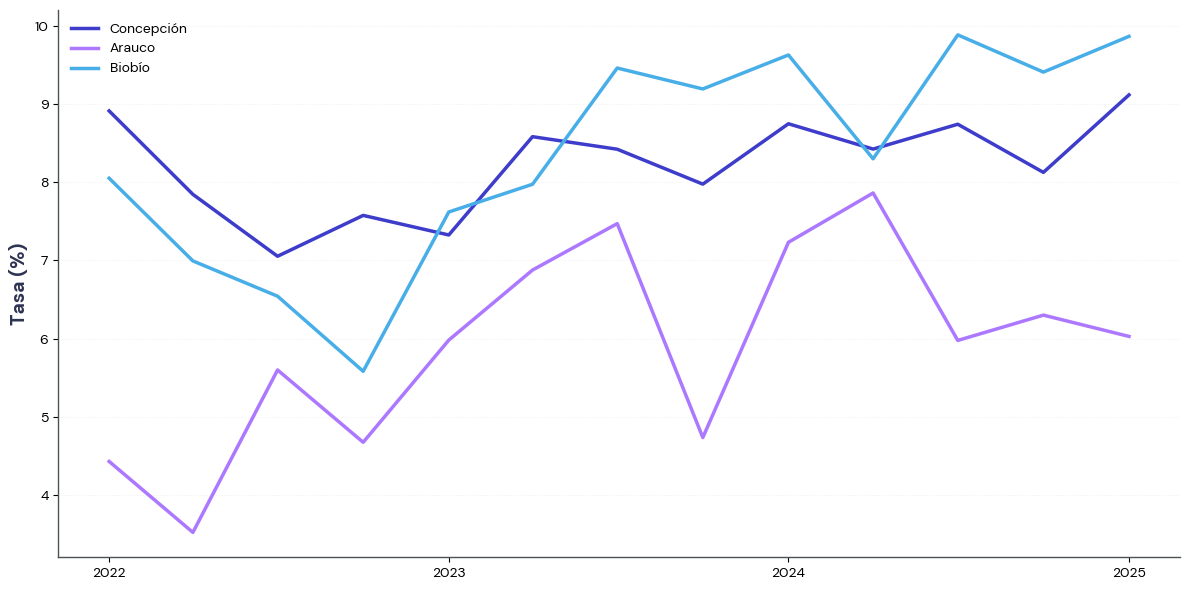

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── Paleta de colores ────────────────────────────────────────────────────────
PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",  # azul institucional
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",  # otros tonos
]

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_provincias.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar las provincias específicas ───────────────────────────────────────
df_concepcion = df[df["provincia_name"] == "Concepción"]
df_arauco = df[df["provincia_name"] == "Arauco"]
df_bio = df[df["provincia_name"] == "Biobío"]

# ─── Filtrar desde 2021Q3 ─────────────────────────────────────────────────────
df_concepcion = df_concepcion[df_concepcion["Fecha"] >= pd.to_datetime("2022-01-01")]
df_arauco = df_arauco[df_arauco["Fecha"] >= pd.to_datetime("2022-01-01")]
df_bio = df_bio[df_bio["Fecha"] >= pd.to_datetime("2022-01-01")]

# ─── Crear gráfico ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))

# Líneas de datos trimestrales
ax.plot(df_concepcion["Fecha"], df_concepcion["T_TDO_provincias"],
        label="Concepción", color=PALETTE[3], linewidth=2.5)
ax.plot(df_arauco["Fecha"], df_arauco["T_TDO_provincias"],
        label="Arauco", color=PALETTE[6], linewidth=2.5)
ax.plot(df_bio["Fecha"], df_bio["T_TDO_provincias"],
        label="Biobío", color=PALETTE[7], linewidth=2.5)

# Ejes y formato
ax.set_ylabel("Tasa (%)", fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])

ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font)

ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

ax.legend(frameon=False, loc="upper left", fontsize=12, prop=dm_font)

plt.tight_layout()
plt.show()


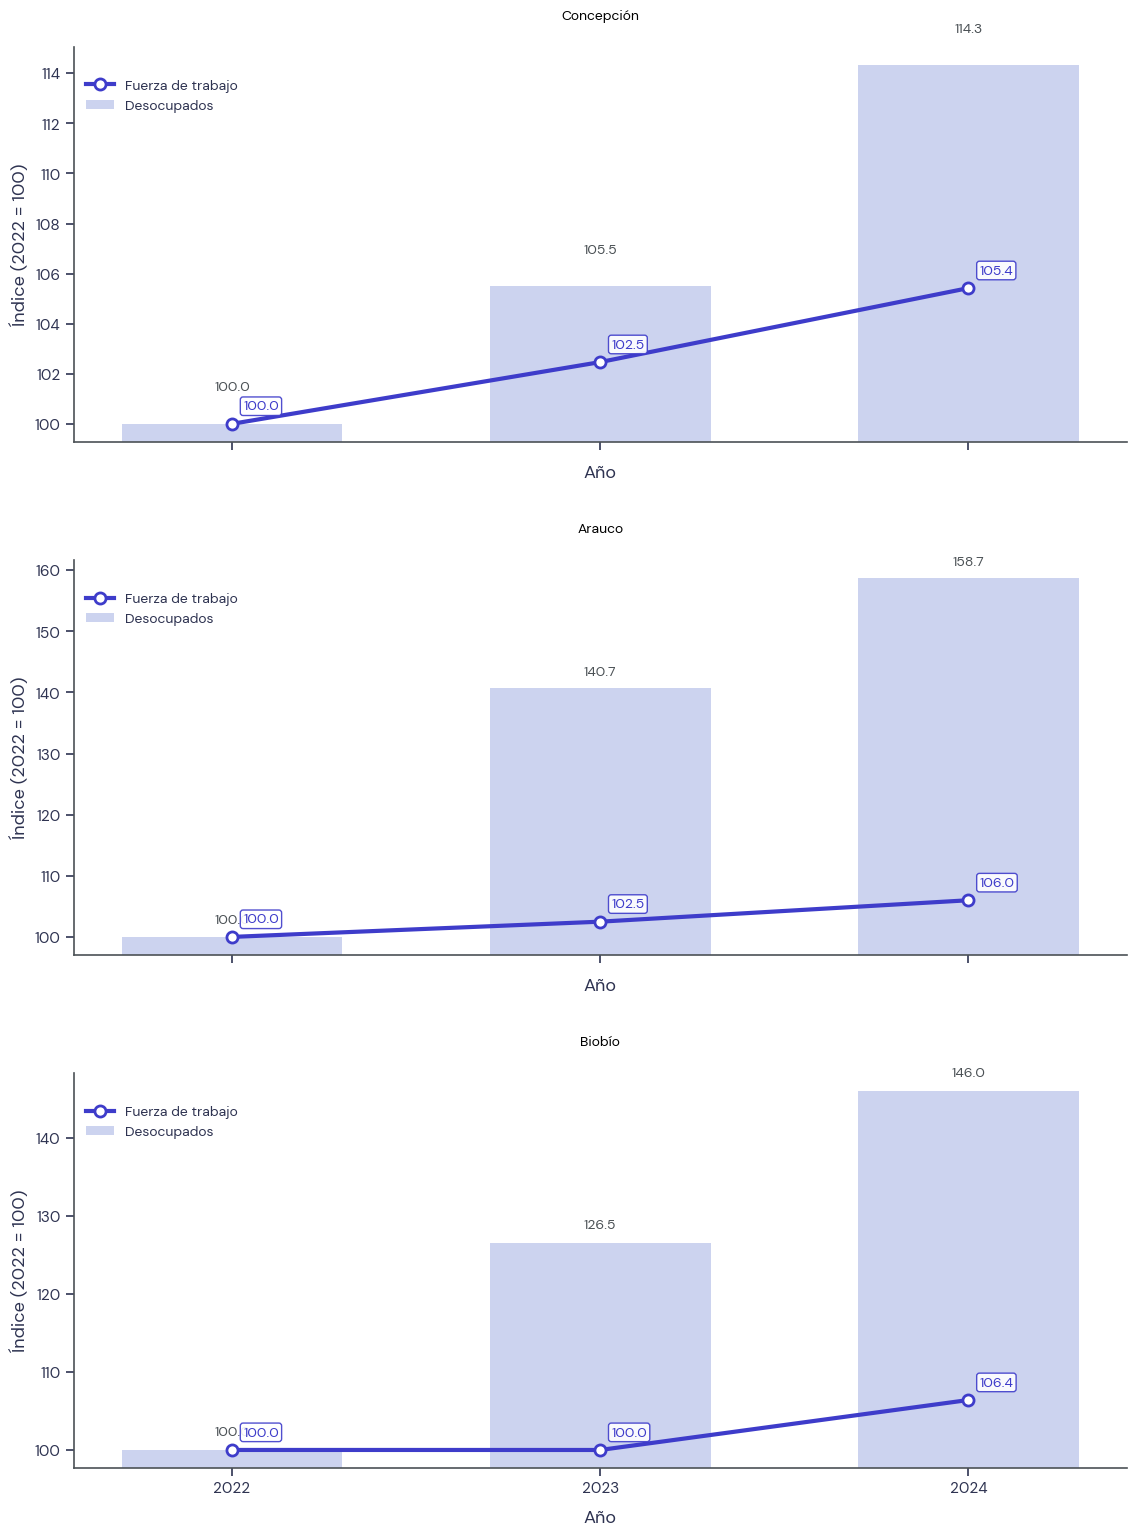

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
from pathlib import Path
import matplotlib.dates as mdates

# ─── 1. Registrar fuente DM Sans ─────────────────────────────────────────────
font_path = Path("/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf")
fm.fontManager.addfont(str(font_path))
dm_prop      = fm.FontProperties(fname=str(font_path))
dm_prop_bold = fm.FontProperties(fname=str(font_path), weight="bold")
dm_name = dm_prop.get_name()
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": [dm_name, "DejaVu Sans"],
})

# ─── 2. Paleta institucional ─────────────────────────────────────────────────
PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",
]

# ─── 3. Cargar datos y convertir Periodo ─────────────────────────────────────
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_provincias.xlsx")
df = pd.read_excel(PANEL_PATH, sheet_name="panel_data")
df["Periodo"] = pd.PeriodIndex(df["Periodo"].astype(str), freq="Q")
df["Año"] = df["Periodo"].dt.year

# ─── 4. Filtrar provincias y desde 2022 ──────────────────────────────────────
df_concepcion = df[(df["provincia_name"] == "Concepción") & (df["Año"] >= 2022) & (df["Año"] <= 2024)]
df_arauco = df[(df["provincia_name"] == "Arauco") & (df["Año"] >= 2022) & (df["Año"] <= 2024)]
df_bio = df[(df["provincia_name"] == "Biobío") & (df["Año"] >= 2022) & (df["Año"] <= 2024)]

# ─── 5. Calcular promedios anuales ───────────────────────────────────────────
def calculate_annual_avg(df):
    unemp_annual = df.groupby("Año")["PDO_TOT_provincias"].mean()
    work_annual  = df.groupby("Año")["FT_TOT_provincias"].mean()
    return unemp_annual, work_annual

# Calcular promedios anuales para cada provincia
unemp_concepcion, work_concepcion = calculate_annual_avg(df_concepcion)
unemp_arauco, work_arauco = calculate_annual_avg(df_arauco)
unemp_bio, work_bio = calculate_annual_avg(df_bio)

# ─── 6. Calcular índices base 2022 = 100 ─────────────────────────────────────
def calculate_index_from_annual(unemp_annual, work_annual, year_base=2022):
    base_u = unemp_annual.loc[year_base]
    base_w = work_annual.loc[year_base]
    idx_u = unemp_annual / base_u * 100
    idx_w = work_annual / base_w * 100
    return idx_u, idx_w

# Calcular los índices de cada provincia
idx_u_concepcion, idx_w_concepcion = calculate_index_from_annual(unemp_concepcion, work_concepcion)
idx_u_arauco, idx_w_arauco = calculate_index_from_annual(unemp_arauco, work_arauco)
idx_u_bio, idx_w_bio = calculate_index_from_annual(unemp_bio, work_bio)

# ─── 7. Crear gráficos mejorados ──────────────────────────────────────────────
fig, axes = plt.subplots(3, 1, figsize=(12, 16), sharex=True)

def create_improved_chart(ax, idx_u, idx_w, title):
    """Función para crear gráficos con mejor posicionamiento de números"""

    # Crear barras
    bars = ax.bar(
        idx_u.index.astype(str), idx_u,
        width=0.6, color=PALETTE[4], edgecolor="none",
        label="Desocupados", alpha=0.8
    )

    # Crear línea
    line = ax.plot(
        idx_w.index.astype(str), idx_w,
        marker="o", linewidth=3, color=PALETTE[3],
        label="Fuerza de trabajo", markersize=8, markerfacecolor='white',
        markeredgewidth=2, markeredgecolor=PALETTE[3]
    )

    # Configurar título y ejes
    ax.set_title(title, fontsize=18, fontproperties=dm_prop_bold, pad=20)
    ax.set_ylabel("Índice (2022 = 100)", fontproperties=dm_prop_bold,
                  fontsize=13, color=PALETTE[1])

    # Mejorar la leyenda
    legend = ax.legend(frameon=False, loc="upper left", fontsize=11,
                      prop=dm_prop, bbox_to_anchor=(0, 0.95))
    legend.get_texts()[0].set_color(PALETTE[1])
    legend.get_texts()[1].set_color(PALETTE[1])

    # ── MEJORAS EN POSICIONAMIENTO DE NÚMEROS ──

    # 1. Números sobre las barras (desocupados) - mejor posicionamiento
    for i, (bar, value) in enumerate(zip(bars, idx_u)):
        # Calcular altura dinámica basada en el rango de datos
        y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
        offset = y_range * 0.01  # 2% del rango total

        ax.text(bar.get_x() + bar.get_width()/2, value + offset,
                f'{value:.1f}',
                ha='center', va='bottom',
                fontsize=10, fontweight='600',
                color=PALETTE[0],
                bbox=dict(boxstyle="round,pad=0.2",
                         facecolor='white', edgecolor='none', alpha=0.8))

    # 2. Números en los puntos de la línea (fuerza de trabajo)
    for i, (x, y) in enumerate(zip(idx_w.index.astype(str), idx_w)):
        # Posicionar el texto a la derecha del punto para evitar solapamiento
        ax.annotate(f'{y:.1f}',
                   xy=(i, y),
                   xytext=(8, 8),  # Desplazamiento en píxeles
                   textcoords='offset points',
                   ha='left', va='bottom',
                   fontsize=10, fontweight='600',
                   color=PALETTE[3],
                   bbox=dict(boxstyle="round,pad=0.2",
                            facecolor='white', edgecolor=PALETTE[3],
                            linewidth=1, alpha=0.9))

    # 3. Ajustar límites del eje Y para mejor visualización
    y_max = max(max(idx_u), max(idx_w))
    y_min = min(min(idx_u), min(idx_w))
    y_range = y_max - y_min

    # Agregar padding arriba y abajo
    ax.set_ylim(y_min - y_range * 0.05, y_max + y_range * 0.05)

# Aplicar mejoras a cada gráfico
create_improved_chart(axes[0], idx_u_concepcion, idx_w_concepcion, "Concepción")
create_improved_chart(axes[1], idx_u_arauco, idx_w_arauco, "Arauco")
create_improved_chart(axes[2], idx_u_bio, idx_w_bio, "Biobío")


# ─── 8. Estilo minimalista mejorado ───────────────────────────────────────────
for ax in axes:
    # Grid más sutil
    ax.yaxis.grid(True, linestyle=":", linewidth=0.8, alpha=0, color=PALETTE[0])
    ax.xaxis.grid(False)

    # Etiquetas de eje X más elegantes
    ax.set_xlabel("Año", fontsize=13, fontproperties=dm_prop_bold,
                  color=PALETTE[1], labelpad=10)

    # Mejorar spines
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    ax.spines["left"].set_color(PALETTE[0])
    ax.spines["bottom"].set_color(PALETTE[0])
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)

    # Mejorar ticks
    ax.tick_params(axis='both', which='major', labelsize=11,
                   colors=PALETTE[1], length=6, width=1.2)
    ax.tick_params(axis='both', which='minor', length=3, width=0.8)

# Ajustar espaciado
plt.tight_layout(pad=3.0)
plt.subplots_adjust(hspace=0.3)


plt.show()

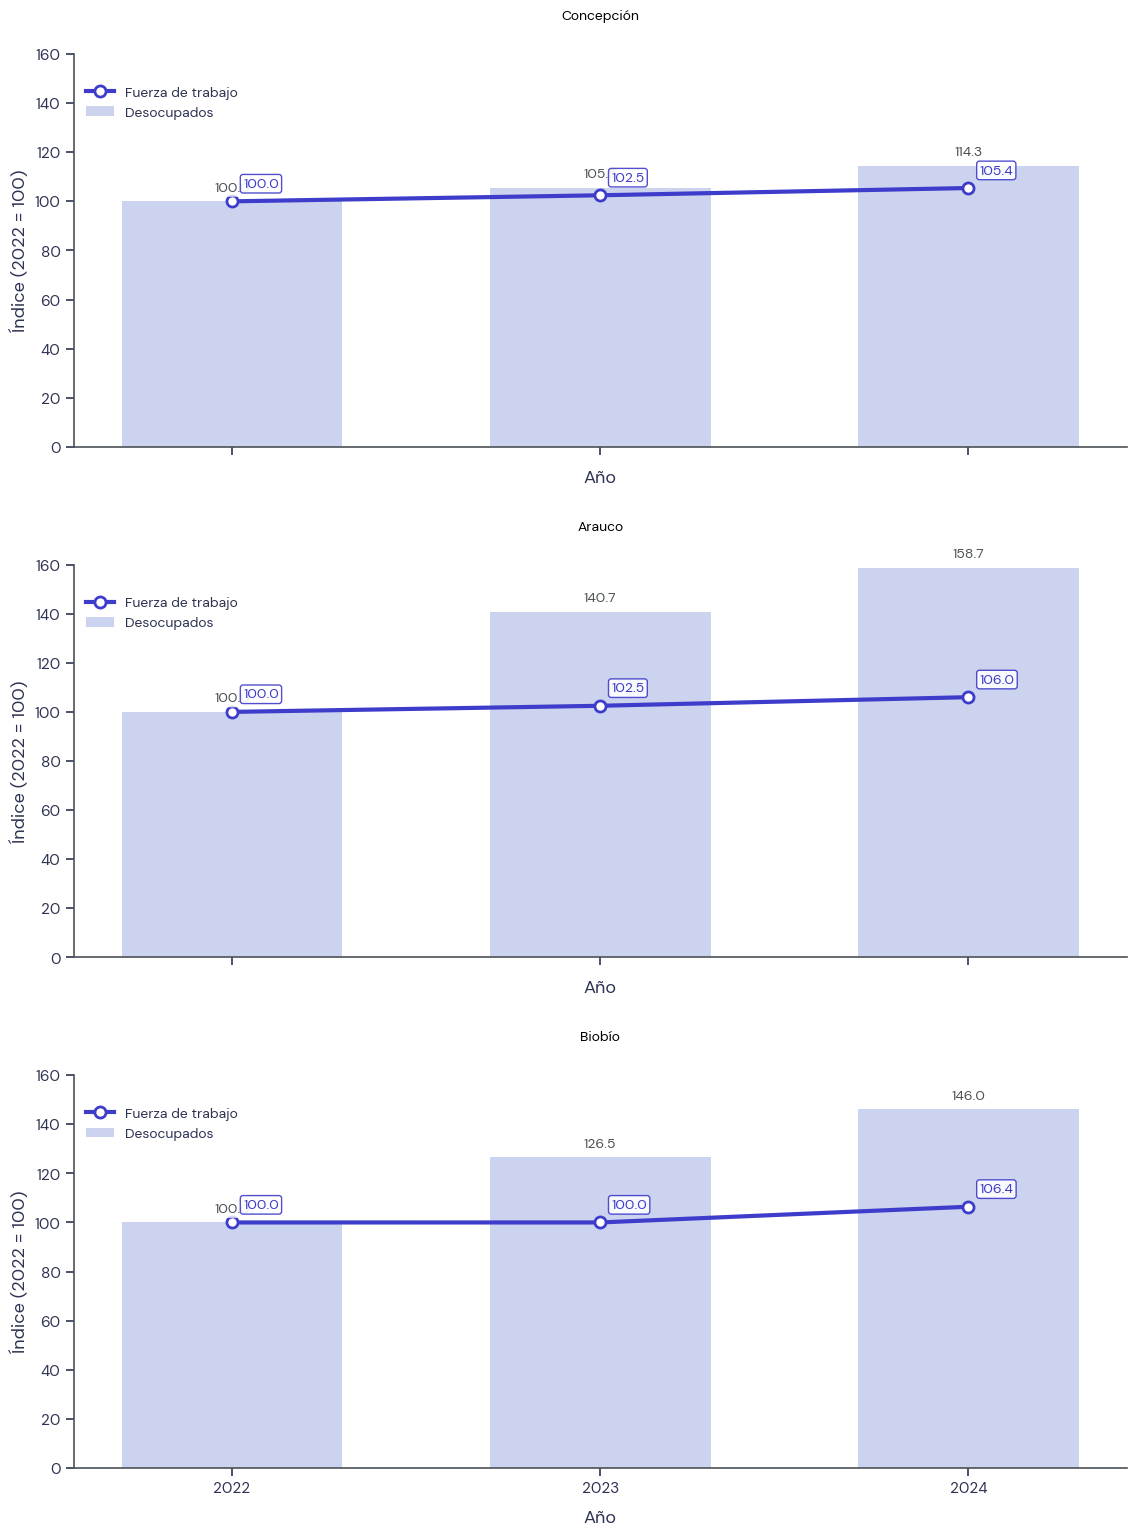

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
from pathlib import Path
import matplotlib.dates as mdates

# ─── 1. Registrar fuente DM Sans ─────────────────────────────────────────────
font_path = Path("/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf")
fm.fontManager.addfont(str(font_path))
dm_prop      = fm.FontProperties(fname=str(font_path))
dm_prop_bold = fm.FontProperties(fname=str(font_path), weight="bold")
dm_name = dm_prop.get_name()
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": [dm_name, "DejaVu Sans"],
})

# ─── 2. Paleta institucional ─────────────────────────────────────────────────
PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",
]

# ─── 3. Cargar datos y convertir Periodo ─────────────────────────────────────
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_provincias.xlsx")
df = pd.read_excel(PANEL_PATH, sheet_name="panel_data")
df["Periodo"] = pd.PeriodIndex(df["Periodo"].astype(str), freq="Q")
df["Año"] = df["Periodo"].dt.year

# ─── 4. Filtrar provincias y desde 2022 ──────────────────────────────────────
df_concepcion = df[(df["provincia_name"] == "Concepción") & (df["Año"] >= 2022) & (df["Año"] <= 2024)]
df_arauco = df[(df["provincia_name"] == "Arauco") & (df["Año"] >= 2022) & (df["Año"] <= 2024)]
df_bio = df[(df["provincia_name"] == "Biobío") & (df["Año"] >= 2022) & (df["Año"] <= 2024)]

# ─── 5. Calcular promedios anuales ───────────────────────────────────────────
def calculate_annual_avg(df):
    unemp_annual = df.groupby("Año")["PDO_TOT_provincias"].mean()
    work_annual  = df.groupby("Año")["FT_TOT_provincias"].mean()
    return unemp_annual, work_annual

# Calcular promedios anuales para cada provincia
unemp_concepcion, work_concepcion = calculate_annual_avg(df_concepcion)
unemp_arauco, work_arauco = calculate_annual_avg(df_arauco)
unemp_bio, work_bio = calculate_annual_avg(df_bio)

# ─── 6. Calcular índices base 2022 = 100 ─────────────────────────────────────
def calculate_index_from_annual(unemp_annual, work_annual, year_base=2022):
    base_u = unemp_annual.loc[year_base]
    base_w = work_annual.loc[year_base]
    idx_u = unemp_annual / base_u * 100
    idx_w = work_annual / base_w * 100
    return idx_u, idx_w

# Calcular los índices de cada provincia
idx_u_concepcion, idx_w_concepcion = calculate_index_from_annual(unemp_concepcion, work_concepcion)
idx_u_arauco, idx_w_arauco = calculate_index_from_annual(unemp_arauco, work_arauco)
idx_u_bio, idx_w_bio = calculate_index_from_annual(unemp_bio, work_bio)

# ─── 7. Crear gráficos mejorados ──────────────────────────────────────────────
fig, axes = plt.subplots(3, 1, figsize=(12, 16), sharex=True)

def create_improved_chart(ax, idx_u, idx_w, title):
    """Función para crear gráficos con mejor posicionamiento de números"""

    # Crear barras
    bars = ax.bar(
        idx_u.index.astype(str), idx_u,
        width=0.6, color=PALETTE[4], edgecolor="none",
        label="Desocupados", alpha=0.8
    )

    # Crear línea
    line = ax.plot(
        idx_w.index.astype(str), idx_w,
        marker="o", linewidth=3, color=PALETTE[3],
        label="Fuerza de trabajo", markersize=8, markerfacecolor='white',
        markeredgewidth=2, markeredgecolor=PALETTE[3]
    )

    # Configurar título y ejes
    ax.set_title(title, fontsize=24, fontproperties=dm_prop_bold, pad=25)
    ax.set_ylabel("Índice (2022 = 100)", fontproperties=dm_prop_bold,
                  fontsize=13, color=PALETTE[1])

    # Mejorar la leyenda
    legend = ax.legend(frameon=False, loc="upper left", fontsize=11,
                      prop=dm_prop, bbox_to_anchor=(0, 0.95))
    legend.get_texts()[0].set_color(PALETTE[1])
    legend.get_texts()[1].set_color(PALETTE[1])

    # ── MEJORAS EN POSICIONAMIENTO DE NÚMEROS ──

    # 1. Números sobre las barras (desocupados) - mejor posicionamiento
    for i, (bar, value) in enumerate(zip(bars, idx_u)):
        # Calcular offset fijo para escala uniforme
        offset = 3  # Offset fijo en unidades del eje Y

        ax.text(bar.get_x() + bar.get_width()/2, value + offset,
                f'{value:.1f}',
                ha='center', va='bottom',
                fontsize=10, fontweight='600',
                color=PALETTE[0],
                bbox=dict(boxstyle="round,pad=0.2",
                         facecolor='white', edgecolor='none', alpha=0.8))

    # 2. Números en los puntos de la línea (fuerza de trabajo)
    for i, (x, y) in enumerate(zip(idx_w.index.astype(str), idx_w)):
        # Posicionar el texto a la derecha del punto para evitar solapamiento
        ax.annotate(f'{y:.1f}',
                   xy=(i, y),
                   xytext=(8, 8),  # Desplazamiento en píxeles
                   textcoords='offset points',
                   ha='left', va='bottom',
                   fontsize=10, fontweight='600',
                   color=PALETTE[3],
                   bbox=dict(boxstyle="round,pad=0.2",
                            facecolor='white', edgecolor=PALETTE[3],
                            linewidth=1, alpha=0.9))

    # 3. Ajustar límites del eje Y para escala uniforme
    # Fijar escala común para todos los gráficos
    ax.set_ylim(0, 160)

# Aplicar mejoras a cada gráfico
create_improved_chart(axes[0], idx_u_concepcion, idx_w_concepcion, "Concepción")
create_improved_chart(axes[1], idx_u_arauco, idx_w_arauco, "Arauco")
create_improved_chart(axes[2], idx_u_bio, idx_w_bio, "Biobío")

# ─── 8. Estilo minimalista mejorado ───────────────────────────────────────────
for ax in axes:
    # Grid más sutil
    ax.yaxis.grid(True, linestyle=":", linewidth=0.8, alpha=0, color=PALETTE[0])
    ax.xaxis.grid(False)

    # Etiquetas de eje X más elegantes
    ax.set_xlabel("Año", fontsize=13, fontproperties=dm_prop_bold,
                  color=PALETTE[1], labelpad=10)

    # Mejorar spines
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    ax.spines["left"].set_color(PALETTE[0])
    ax.spines["bottom"].set_color(PALETTE[0])
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)

    # Mejorar ticks
    ax.tick_params(axis='both', which='major', labelsize=11,
                   colors=PALETTE[1], length=6, width=1.2)
    ax.tick_params(axis='both', which='minor', length=3, width=0.8)

# Ajustar espaciado
plt.tight_layout(pad=3.0)
plt.subplots_adjust(hspace=0.3)


plt.show()

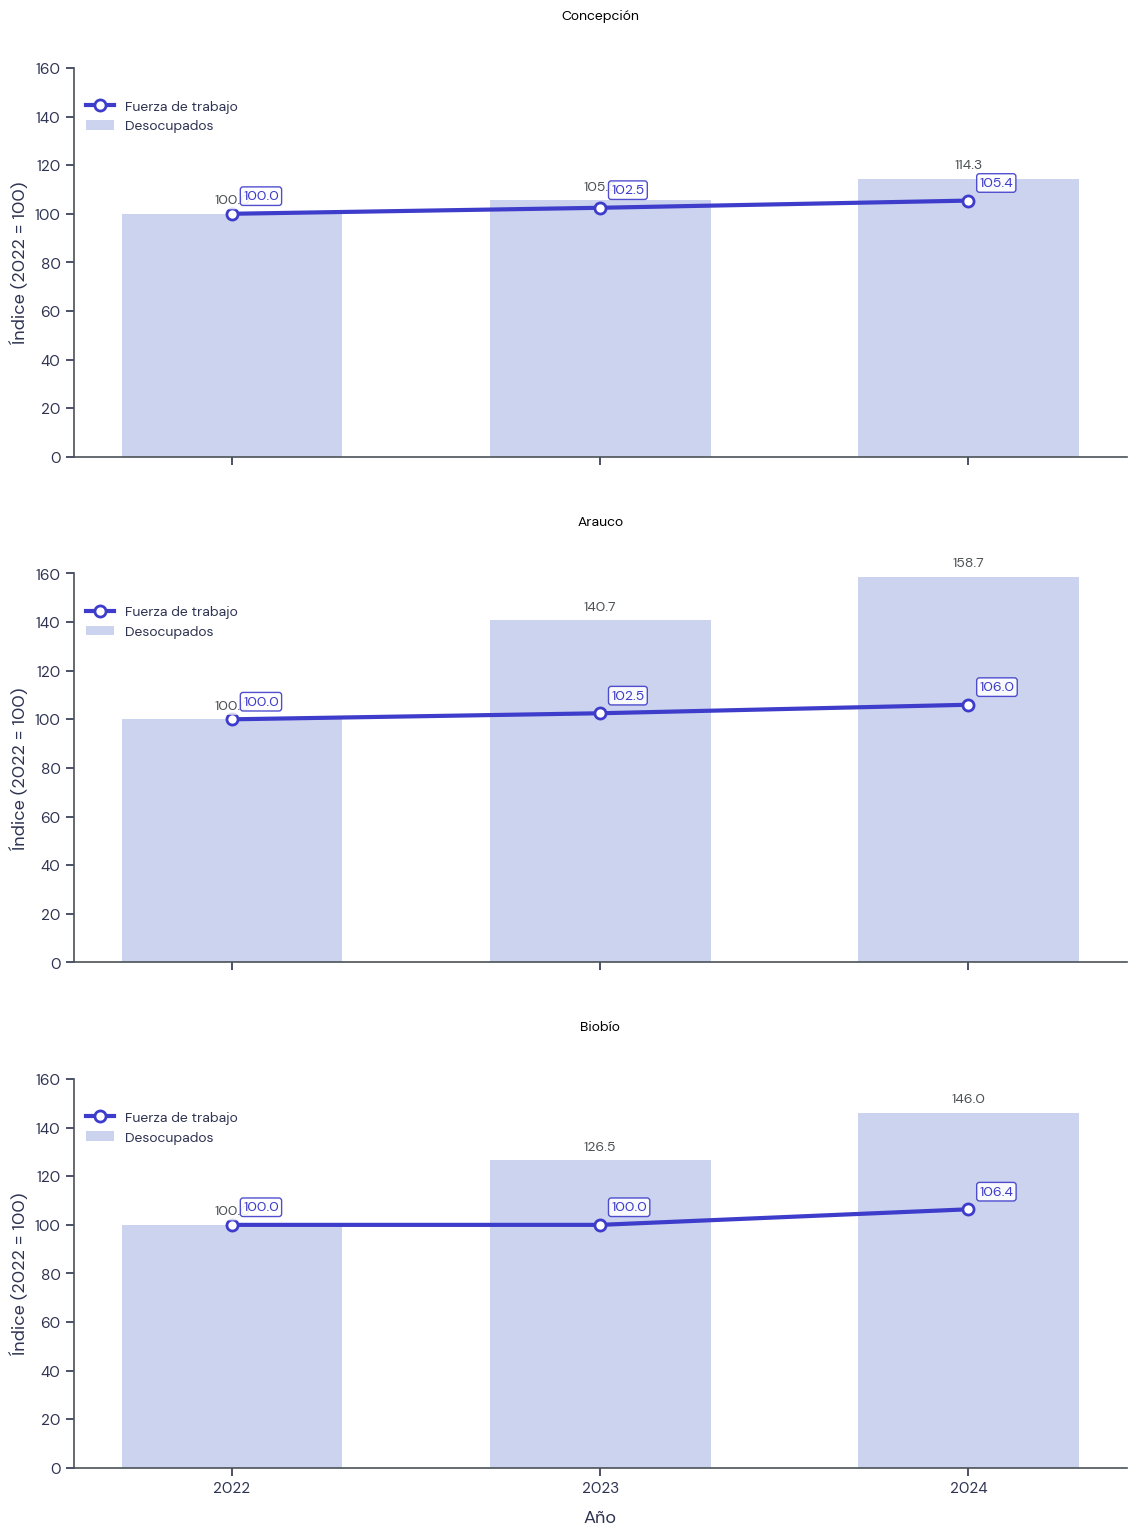

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
from pathlib import Path
import matplotlib.dates as mdates

# ─── 1. Registrar fuente DM Sans ─────────────────────────────────────────────
font_path = Path("/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf")
fm.fontManager.addfont(str(font_path))
dm_prop      = fm.FontProperties(fname=str(font_path))
dm_prop_bold = fm.FontProperties(fname=str(font_path), weight="bold")
dm_name = dm_prop.get_name()
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": [dm_name, "DejaVu Sans"],
})

# ─── 2. Paleta institucional ─────────────────────────────────────────────────
PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",
]

# ─── 3. Cargar datos y convertir Periodo ─────────────────────────────────────
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_provincias.xlsx")
df = pd.read_excel(PANEL_PATH, sheet_name="panel_data")
df["Periodo"] = pd.PeriodIndex(df["Periodo"].astype(str), freq="Q")
df["Año"] = df["Periodo"].dt.year

# ─── 4. Filtrar provincias y desde 2022 ──────────────────────────────────────
df_concepcion = df[(df["provincia_name"] == "Concepción") & (df["Año"] >= 2022) & (df["Año"] <= 2024)]
df_arauco = df[(df["provincia_name"] == "Arauco") & (df["Año"] >= 2022) & (df["Año"] <= 2024)]
df_bio = df[(df["provincia_name"] == "Biobío") & (df["Año"] >= 2022) & (df["Año"] <= 2024)]

# ─── 5. Calcular promedios anuales ───────────────────────────────────────────
def calculate_annual_avg(df):
    unemp_annual = df.groupby("Año")["PDO_TOT_provincias"].mean()
    work_annual  = df.groupby("Año")["FT_TOT_provincias"].mean()
    return unemp_annual, work_annual

# Calcular promedios anuales para cada provincia
unemp_concepcion, work_concepcion = calculate_annual_avg(df_concepcion)
unemp_arauco, work_arauco = calculate_annual_avg(df_arauco)
unemp_bio, work_bio = calculate_annual_avg(df_bio)

# ─── 6. Calcular índices base 2022 = 100 ─────────────────────────────────────
def calculate_index_from_annual(unemp_annual, work_annual, year_base=2022):
    base_u = unemp_annual.loc[year_base]
    base_w = work_annual.loc[year_base]
    idx_u = unemp_annual / base_u * 100
    idx_w = work_annual / base_w * 100
    return idx_u, idx_w

# Calcular los índices de cada provincia
idx_u_concepcion, idx_w_concepcion = calculate_index_from_annual(unemp_concepcion, work_concepcion)
idx_u_arauco, idx_w_arauco = calculate_index_from_annual(unemp_arauco, work_arauco)
idx_u_bio, idx_w_bio = calculate_index_from_annual(unemp_bio, work_bio)

# ─── 7. Crear gráficos mejorados ──────────────────────────────────────────────
fig, axes = plt.subplots(3, 1, figsize=(12, 16), sharex=True)

def create_improved_chart(ax, idx_u, idx_w, title):
    """Función para crear gráficos con mejor posicionamiento de números"""

    # Crear barras
    bars = ax.bar(
        idx_u.index.astype(str), idx_u,
        width=0.6, color=PALETTE[4], edgecolor="none",
        label="Desocupados", alpha=0.8
    )

    # Crear línea
    line = ax.plot(
        idx_w.index.astype(str), idx_w,
        marker="o", linewidth=3, color=PALETTE[3],
        label="Fuerza de trabajo", markersize=8, markerfacecolor='white',
        markeredgewidth=2, markeredgecolor=PALETTE[3]
    )

    # Configurar título y ejes
    ax.set_title(title, fontsize=40, fontproperties=dm_prop_bold, pad=35)
    ax.set_ylabel("Índice (2022 = 100)", fontproperties=dm_prop_bold,
                  fontsize=13, color=PALETTE[1])

    # Mejorar la leyenda
    legend = ax.legend(frameon=False, loc="upper left", fontsize=11,
                      prop=dm_prop, bbox_to_anchor=(0, 0.95))
    legend.get_texts()[0].set_color(PALETTE[1])
    legend.get_texts()[1].set_color(PALETTE[1])

    # ── MEJORAS EN POSICIONAMIENTO DE NÚMEROS ──

    # 1. Números sobre las barras (desocupados) - mejor posicionamiento
    for i, (bar, value) in enumerate(zip(bars, idx_u)):
        # Calcular offset fijo para escala uniforme
        offset = 3  # Offset fijo en unidades del eje Y

        ax.text(bar.get_x() + bar.get_width()/2, value + offset,
                f'{value:.1f}',
                ha='center', va='bottom',
                fontsize=10, fontweight='600',
                color=PALETTE[0],
                bbox=dict(boxstyle="round,pad=0.2",
                         facecolor='white', edgecolor='none', alpha=0.8))

    # 2. Números en los puntos de la línea (fuerza de trabajo)
    for i, (x, y) in enumerate(zip(idx_w.index.astype(str), idx_w)):
        # Posicionar el texto a la derecha del punto para evitar solapamiento
        ax.annotate(f'{y:.1f}',
                   xy=(i, y),
                   xytext=(8, 8),  # Desplazamiento en píxeles
                   textcoords='offset points',
                   ha='left', va='bottom',
                   fontsize=10, fontweight='600',
                   color=PALETTE[3],
                   bbox=dict(boxstyle="round,pad=0.2",
                            facecolor='white', edgecolor=PALETTE[3],
                            linewidth=1, alpha=0.9))

    # 3. Ajustar límites del eje Y para escala uniforme
    # Fijar escala común para todos los gráficos
    ax.set_ylim(0, 160)

# Aplicar mejoras a cada gráfico
create_improved_chart(axes[0], idx_u_concepcion, idx_w_concepcion, "Concepción")
create_improved_chart(axes[1], idx_u_arauco, idx_w_arauco, "Arauco")
create_improved_chart(axes[2], idx_u_bio, idx_w_bio, "Biobío")

# ─── 8. Estilo minimalista mejorado ───────────────────────────────────────────
for i, ax in enumerate(axes):
    # Grid más sutil
    ax.yaxis.grid(True, linestyle=":", linewidth=0.8, alpha=0, color=PALETTE[0])
    ax.xaxis.grid(False)

    # Solo añadir etiqueta X al último gráfico para evitar sobreposición con títulos
    if i == len(axes) - 1:  # Solo el último gráfico
        ax.set_xlabel("Año", fontsize=13, fontproperties=dm_prop_bold,
                      color=PALETTE[1], labelpad=10)

    # Mejorar spines
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    ax.spines["left"].set_color(PALETTE[0])
    ax.spines["bottom"].set_color(PALETTE[0])
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)

    # Mejorar ticks
    ax.tick_params(axis='both', which='major', labelsize=11,
                   colors=PALETTE[1], length=6, width=1.2)
    ax.tick_params(axis='both', which='minor', length=3, width=0.8)

# Ajustar espaciado
plt.tight_layout(pad=3.0)
plt.subplots_adjust(hspace=0.3)

plt.show()